# Policy Gradient

In this part, we will create an agent that can learn to solve tasks from OpenAI Gym by applying the Policy Gradient method. We will implement the agent with a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

Since this is a deep learning course, we will model the policy as a neural network with parameters $\theta$ and train it with gradient descent (now the name 'Policy Gradient' should start to make sense). 
When the set of available actions is discrete, we can use a network with softmax output. 

The core idea of training the policy network is simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

The expectation over the (discounted) total reward, $R$, is:

$$
\mathbb{E}[R|\theta] = \int p_\theta({\bf a}|{\bf s}) R({\bf a}) d{\bf a} \ ,
$$

where ${\bf a} = a_1,\ldots,a_T$, ${\bf s}=s_1,\ldots,s_T$. 

Then we can use the gradient to maximize the total reward:

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta({\bf a}|{\bf s}) R({\bf a}) \, d{\bf a} \\
&= \int \nabla_\theta p_\theta({\bf a}|{\bf s}) R({\bf a})  \, d{\bf a} \\
&= \int p_\theta({\bf a}|{\bf s}) \nabla_\theta \log p_\theta({\bf a}|{\bf s}) R({\bf a}) \, d{\bf a} \\
&= \mathbb{E}[R({\bf a}) \nabla_\theta \log p_\theta({\bf a}|{\bf s})]
\end{align}
$$

using the identity 

$$
\nabla_\theta p_\theta({\bf a}|{\bf s}) = p_\theta({\bf a}|{\bf s}) \nabla_\theta \log p_\theta({\bf a}|{\bf s})
$$

to express the gradient as an average over $p_\theta({\bf a},{\bf s})$.

We cannot evaluate the average over roll-outs analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return the sequence of action, states and rewards. This allows us to replace the integral by a Monte Carlo average over $V$ roll-outs:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{V} \sum_{v=1}^V \nabla_\theta \log p_\theta({\bf a}^{(v)}|{\bf s}^{(v)}) R({\bf a}^{(v)}) \ .
$$

In practice, to reduce the variance of the gradient, instead of $R$, we use the adjusted discounted future reward, also known as the *advantage*, $A$:

$$
A_t = R_t - b_t \ ,
$$

where the *baseline*, $b_t$, is the (discounted) total future reward at timestep $t$ averaged over the $V$ roll-outs:

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

This way we are always encouraging and discouraging roughly half of the performed actions, which gives us the final gradient estimator:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{V} \sum_{v=1}^V \nabla_\theta \log p_\theta({\bf a}^{(v)}|{\bf s}^{(v)}) A({\bf a}^{(v)})
$$

And that's it! Please refer to [this blog post](http://karpathy.github.io/2016/05/31/rl/) by Karpathy for more discussion on the Policy Gradient method.

--

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy Gradient code

In [2]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.nn import relu, softmax
import gym
from utils import Viewer

In [3]:
# create gym environment
env = gym.make('CartPole-v0')

[2017-10-11 13:04:12,157] Making new env: CartPole-v0


Let us see how the environment looks when we just take random actions.

[2017-10-11 13:04:22,325] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.



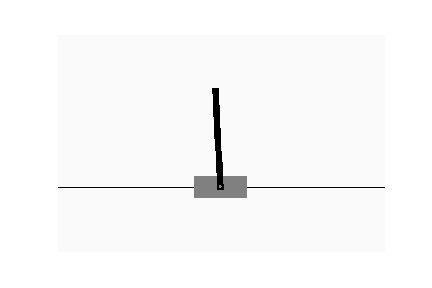
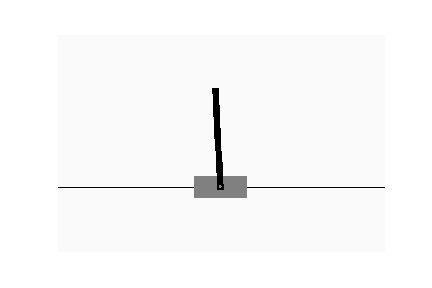
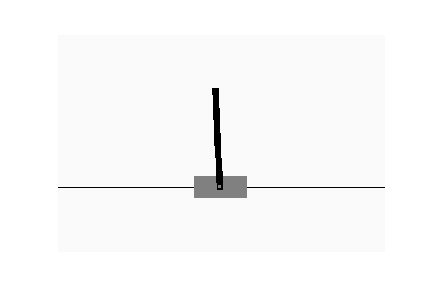
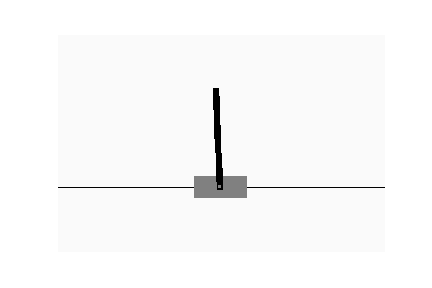
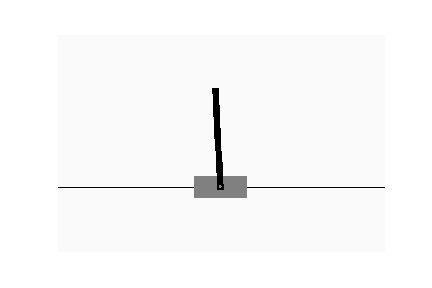
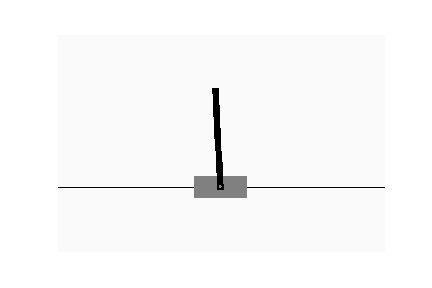
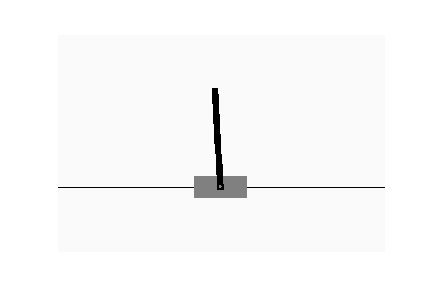
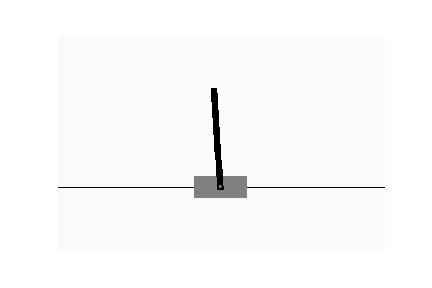
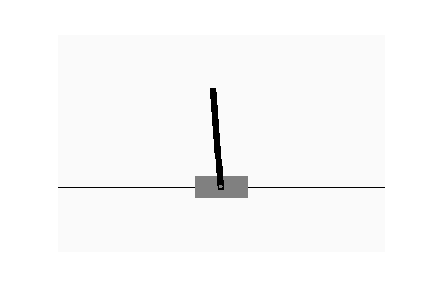
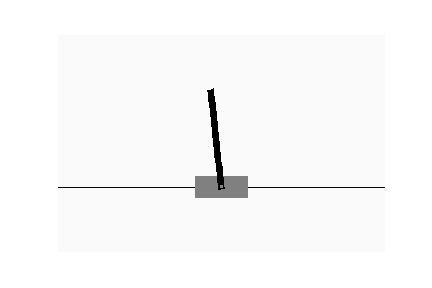
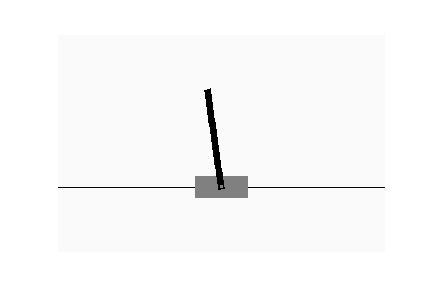
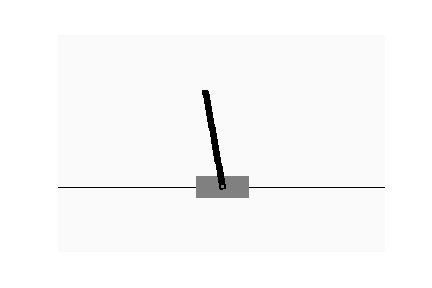
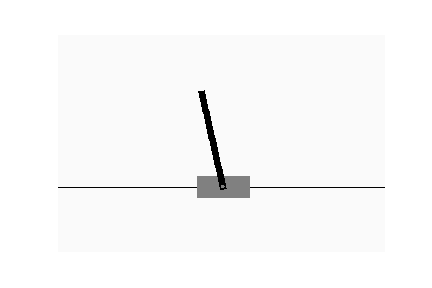
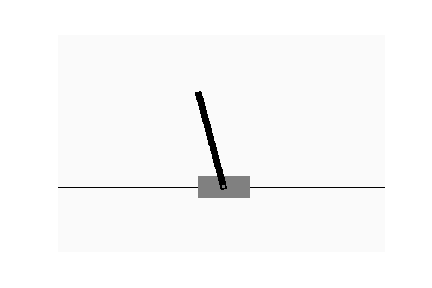
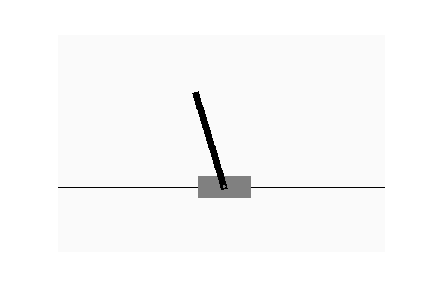
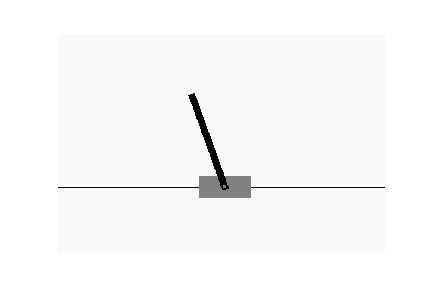
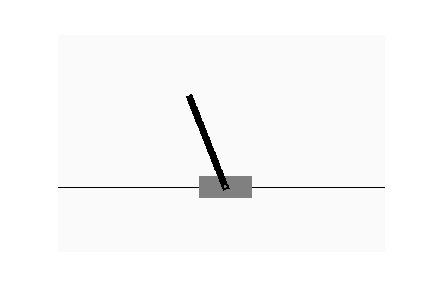
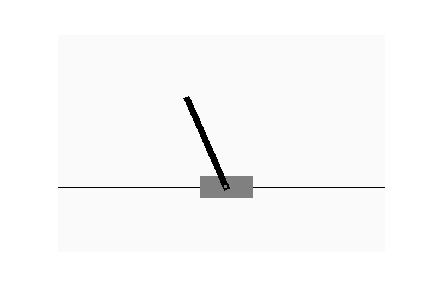
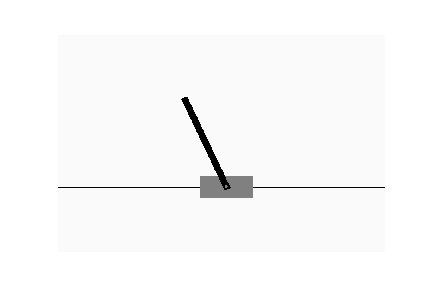
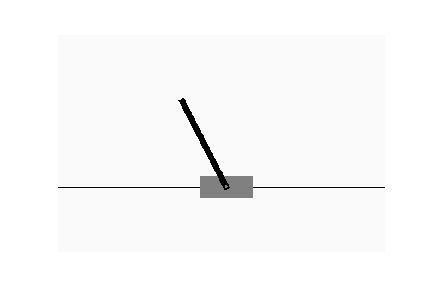
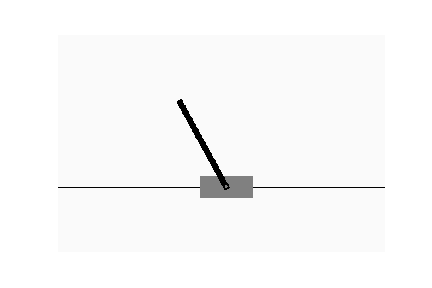
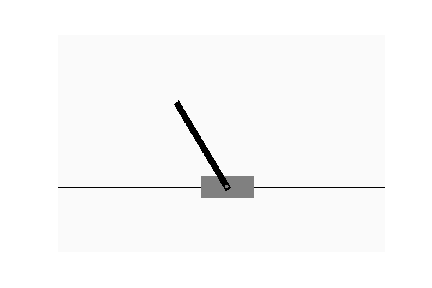
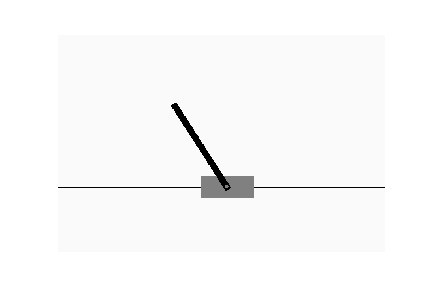
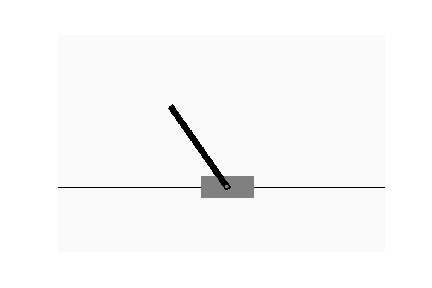
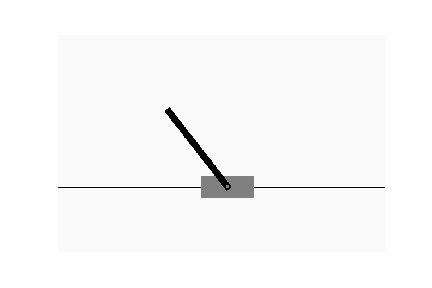
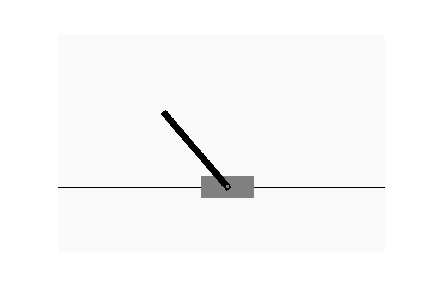
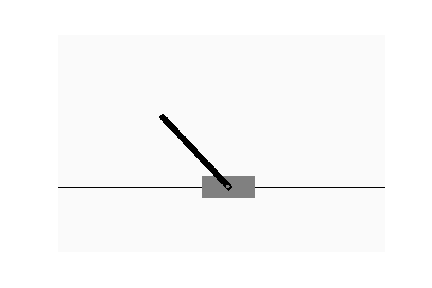
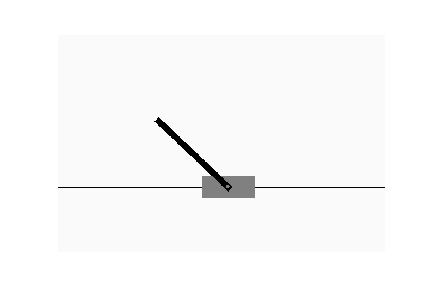
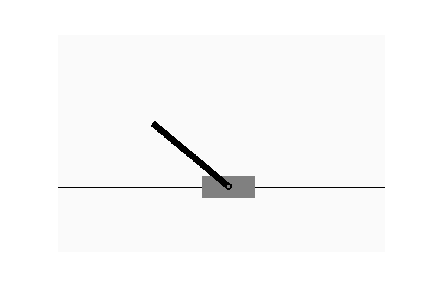
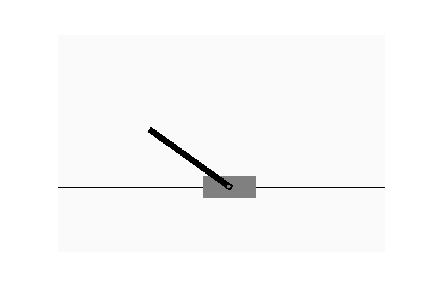
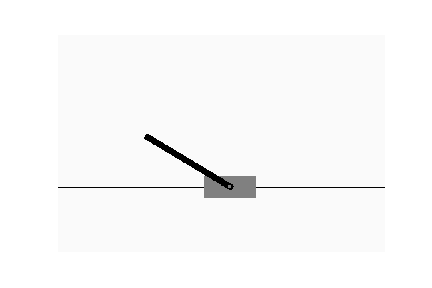
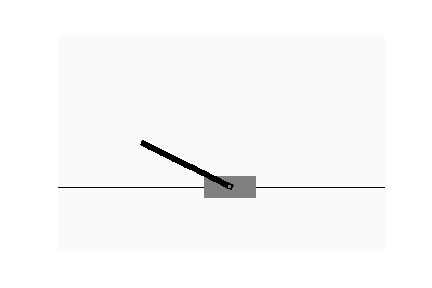
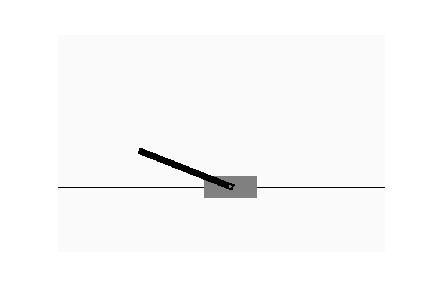
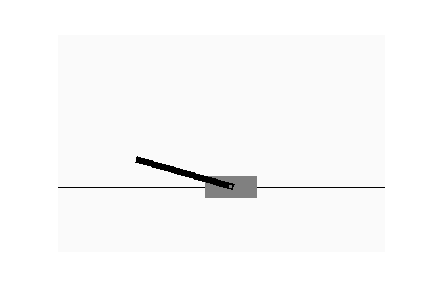
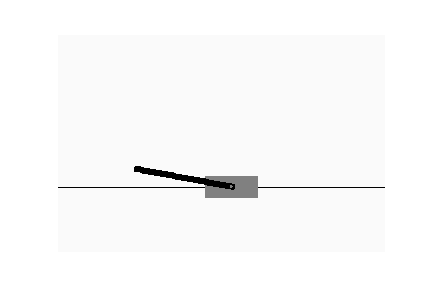
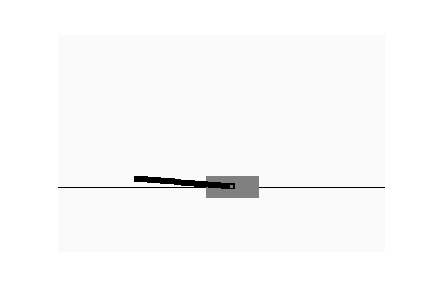
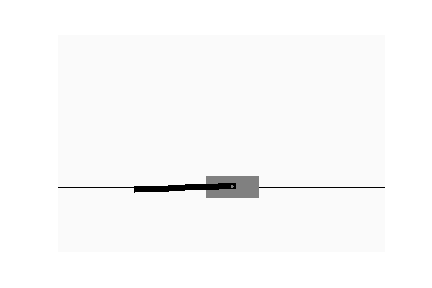
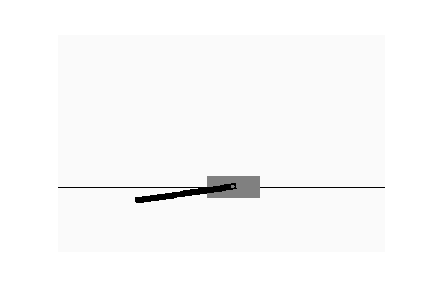
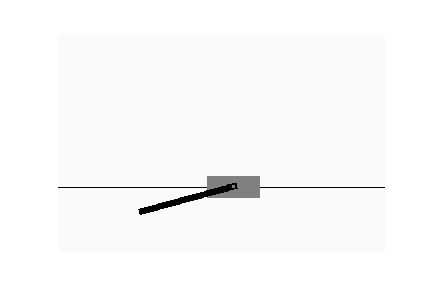
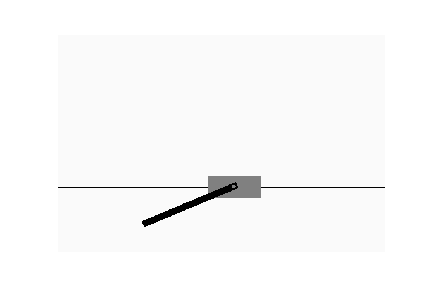
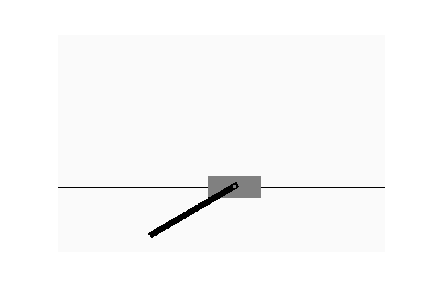
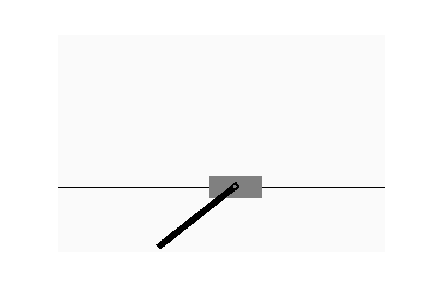
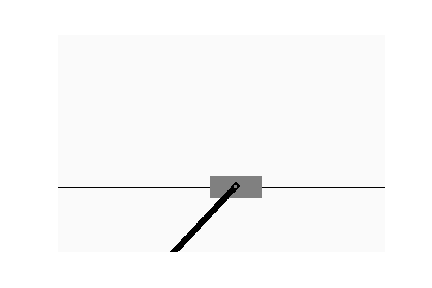
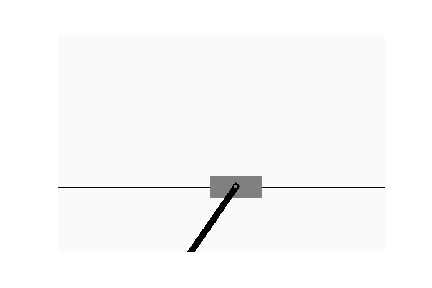
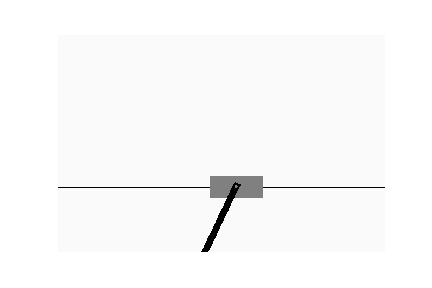
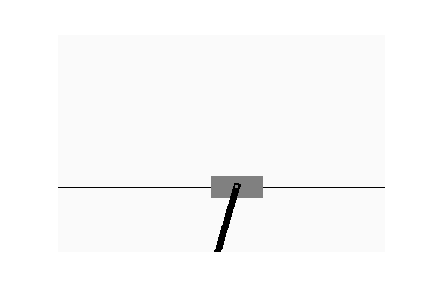
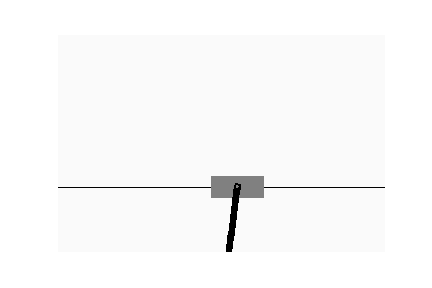
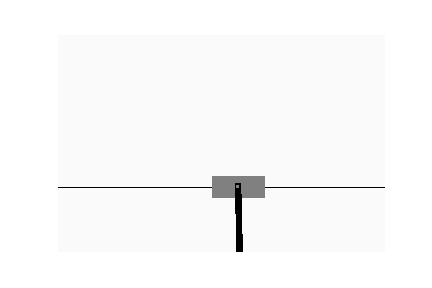
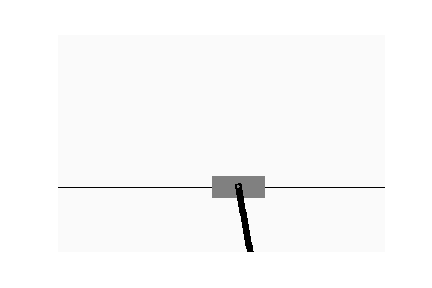
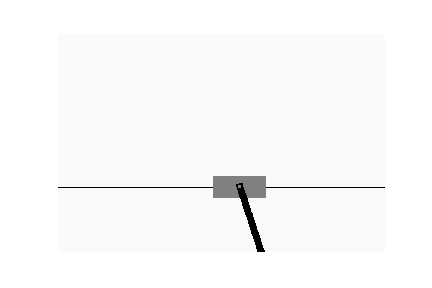
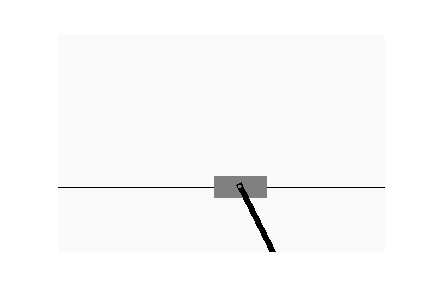
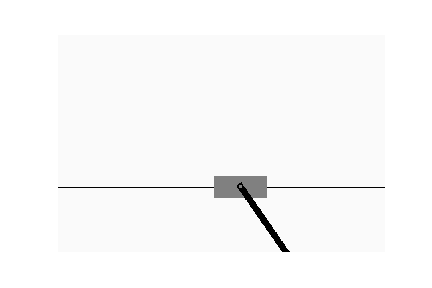
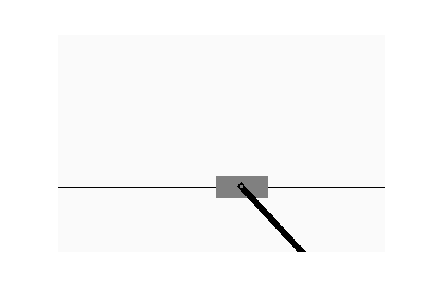
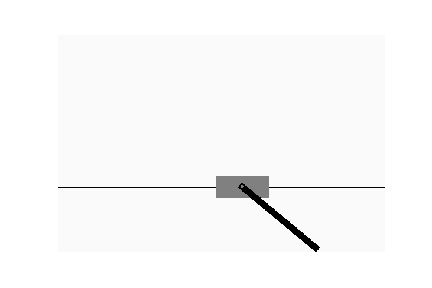
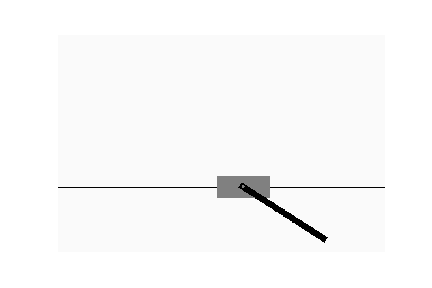
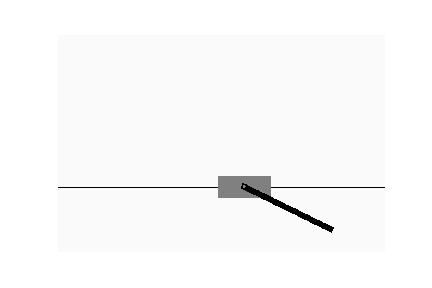
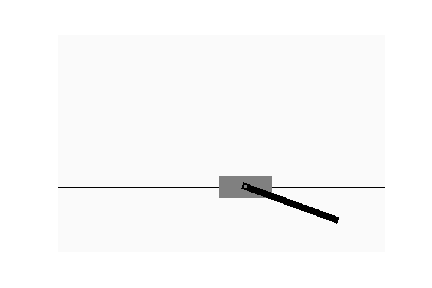
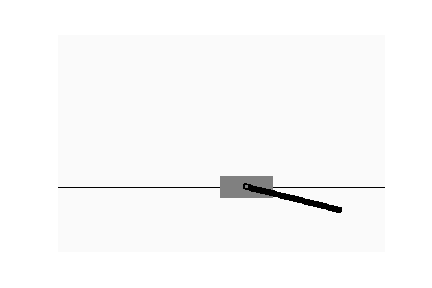
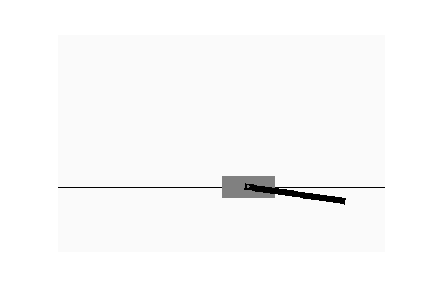
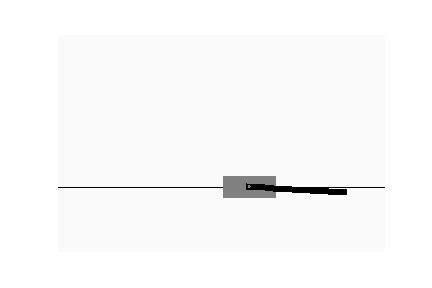
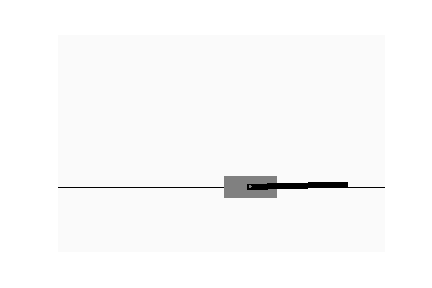
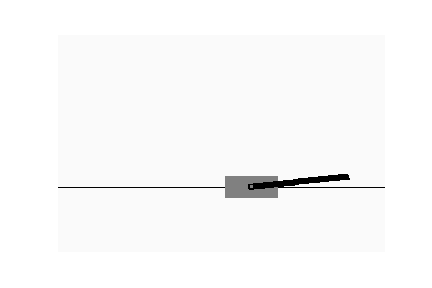
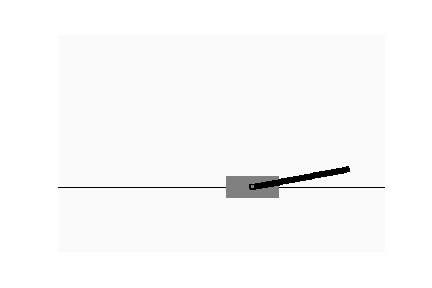
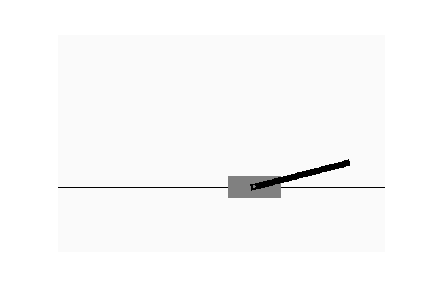
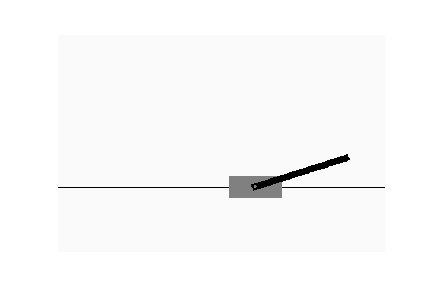
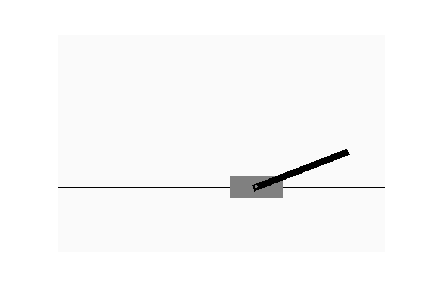
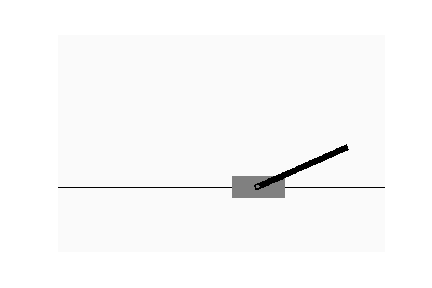
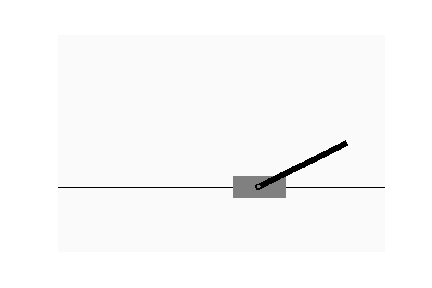
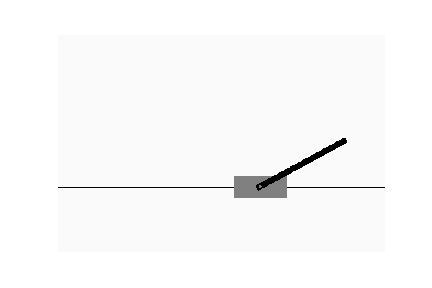
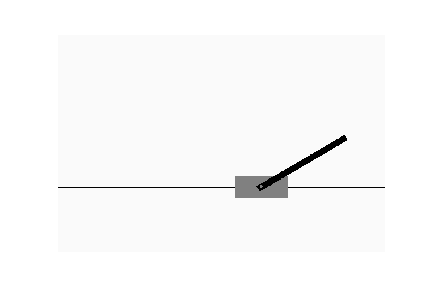
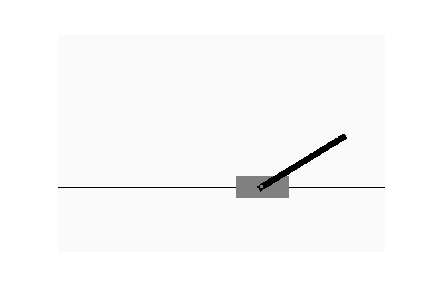
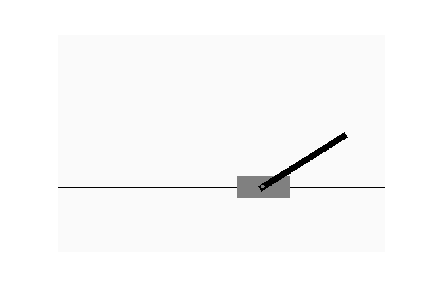
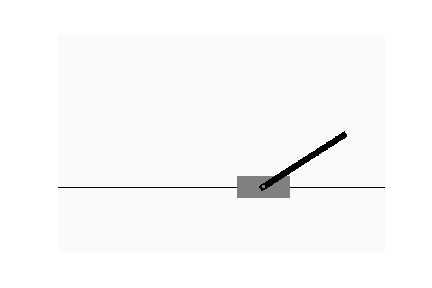
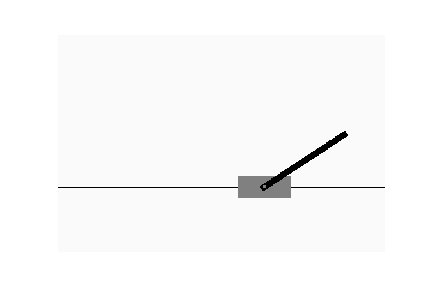
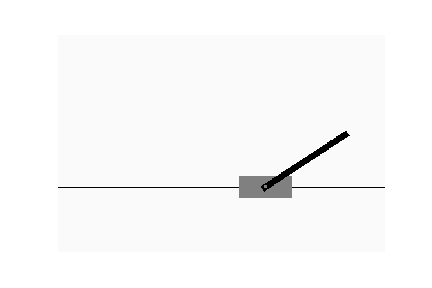
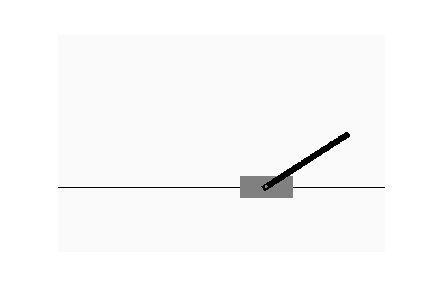
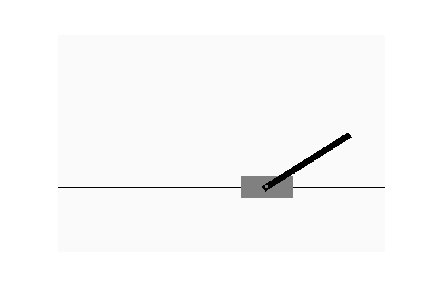
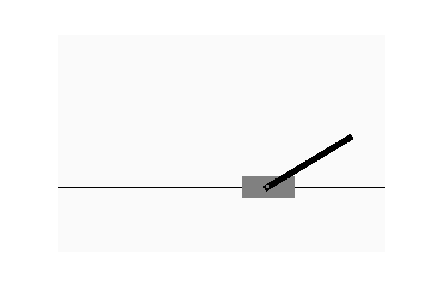
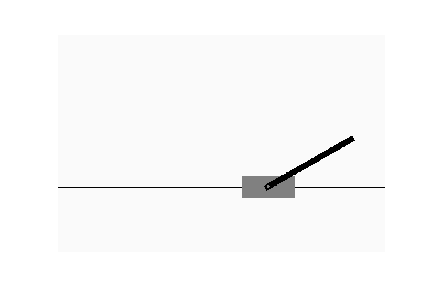
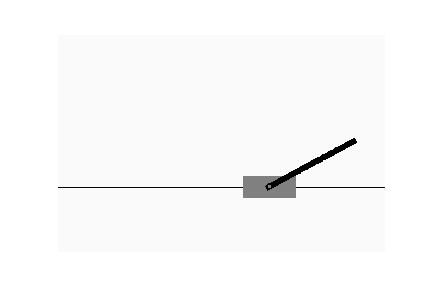
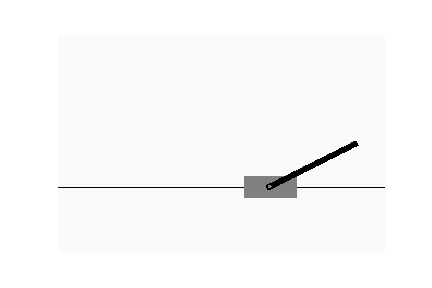
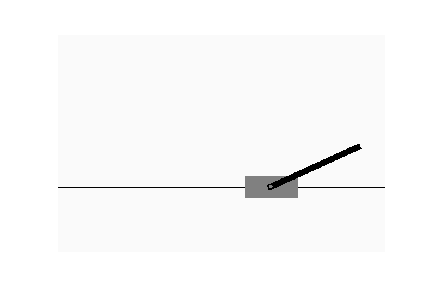
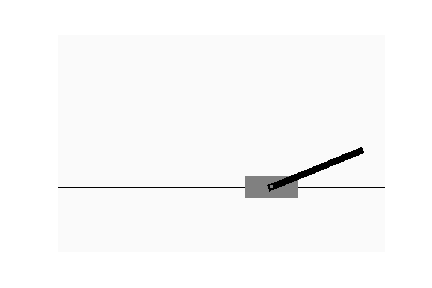
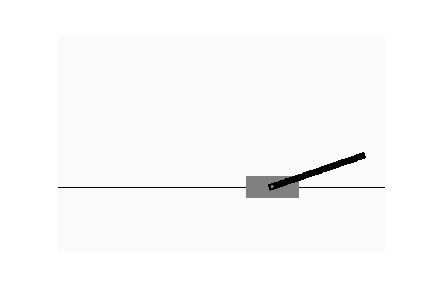
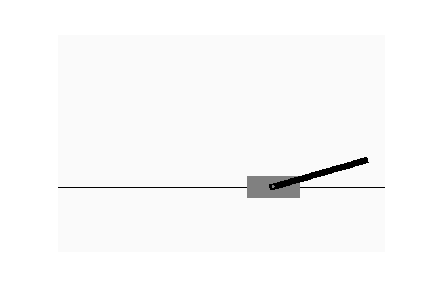
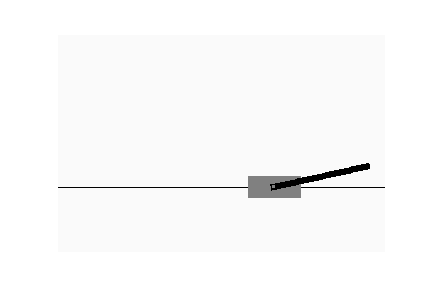
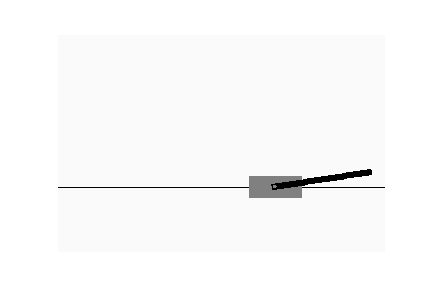
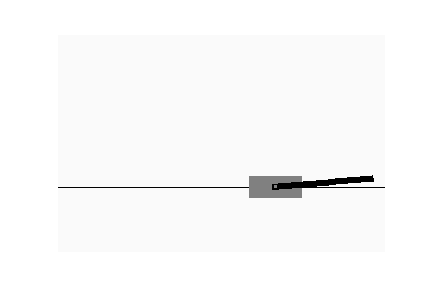
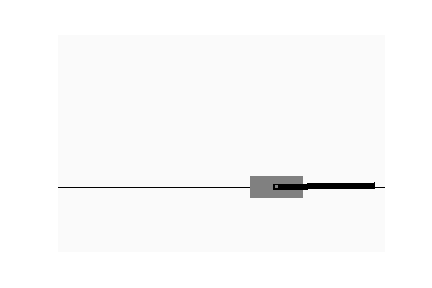
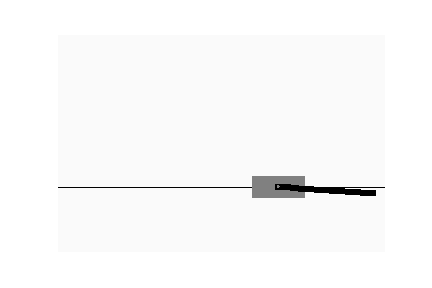
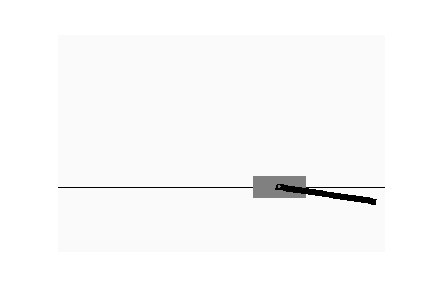
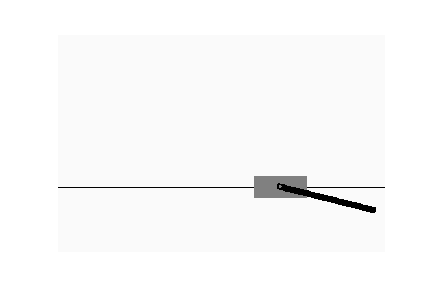
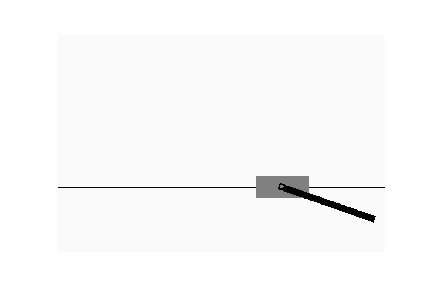
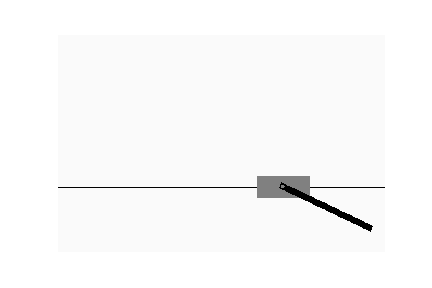
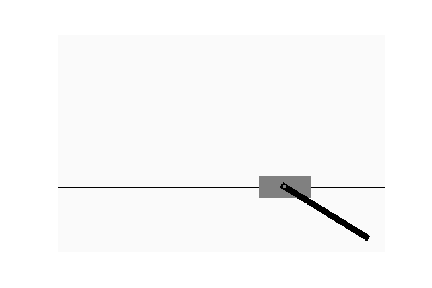
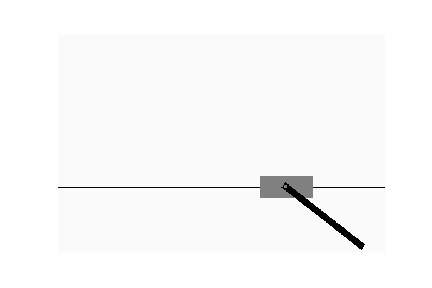
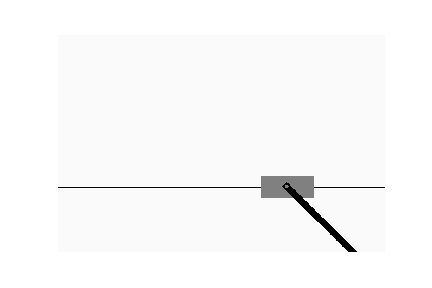
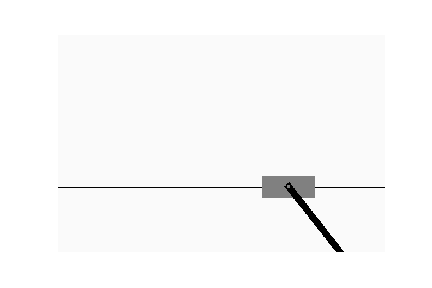
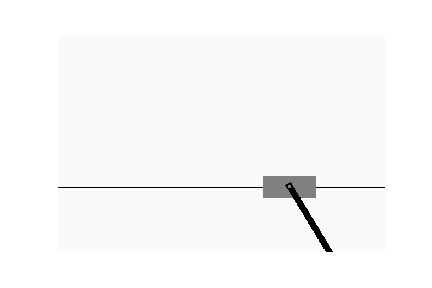
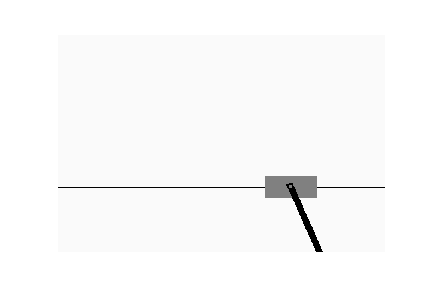
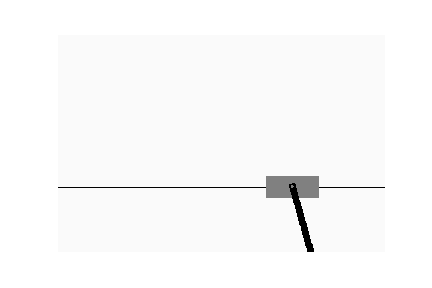
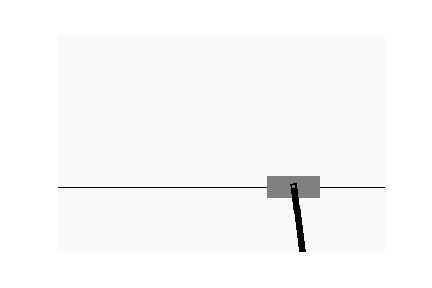
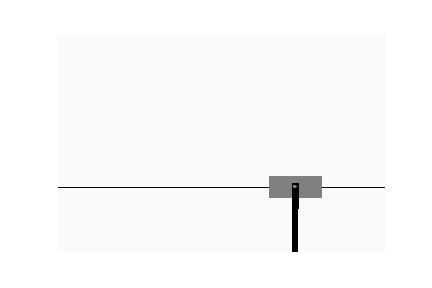
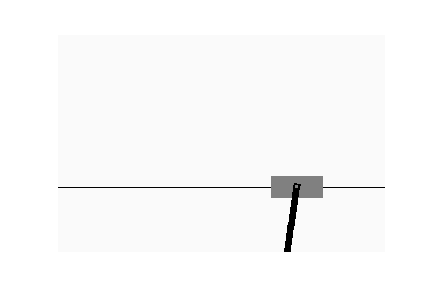
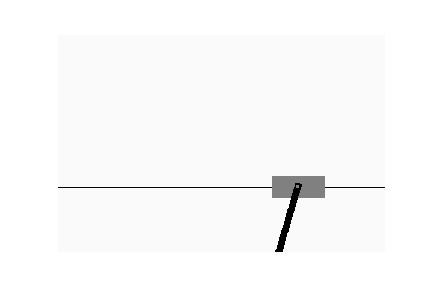
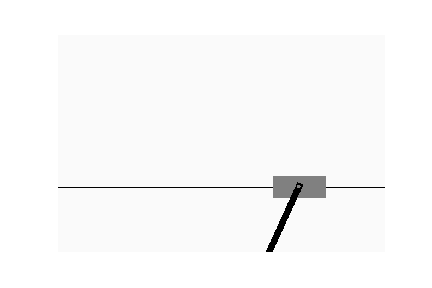
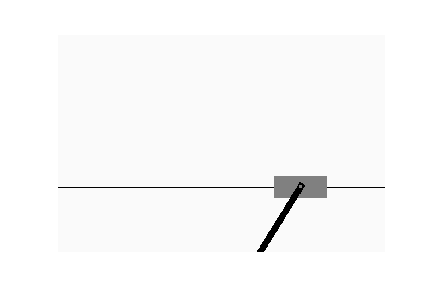
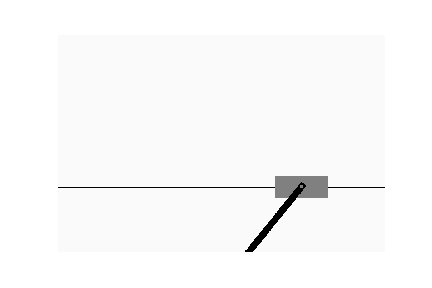
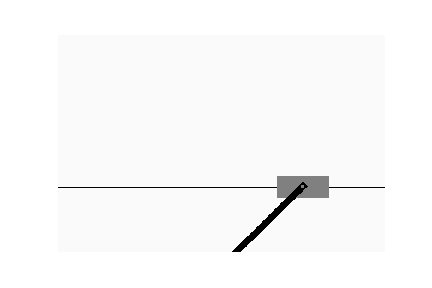
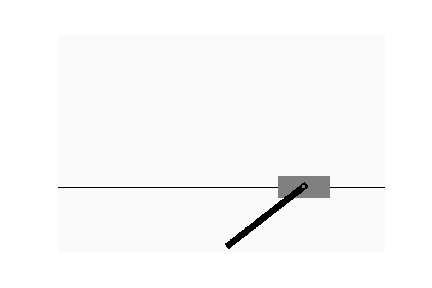
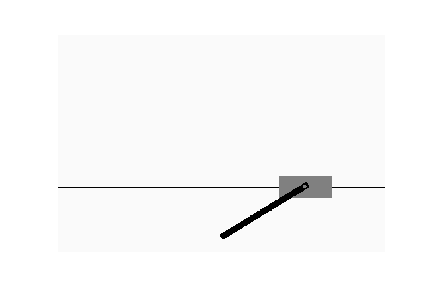
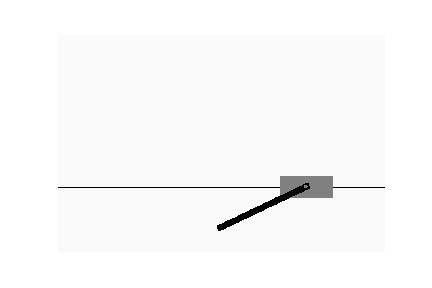
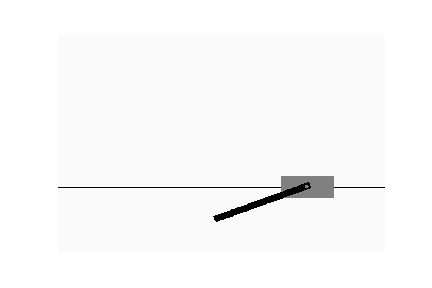
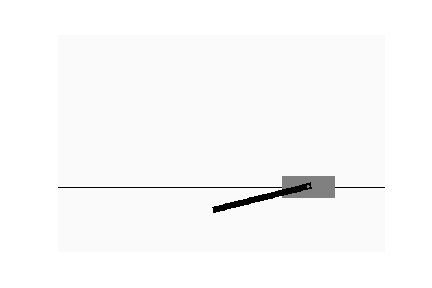
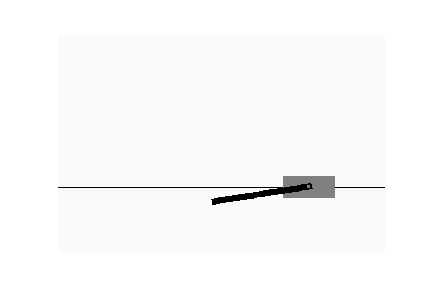
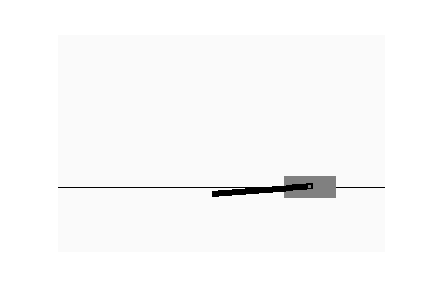
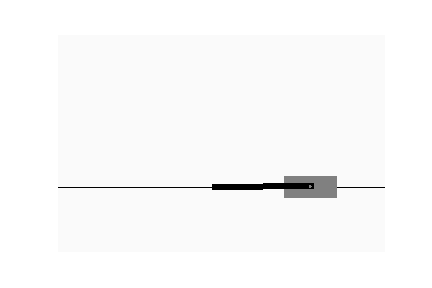
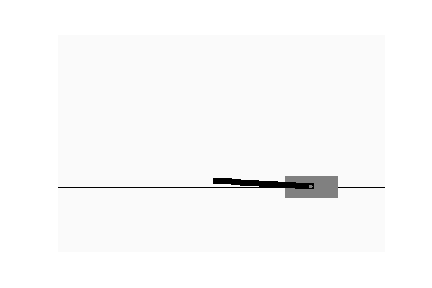
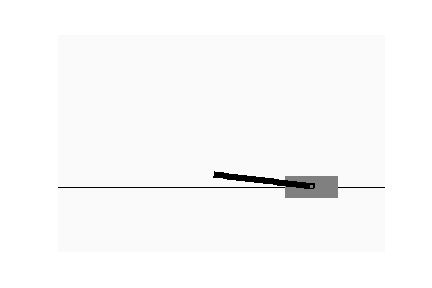
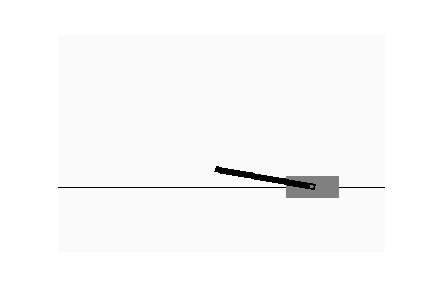
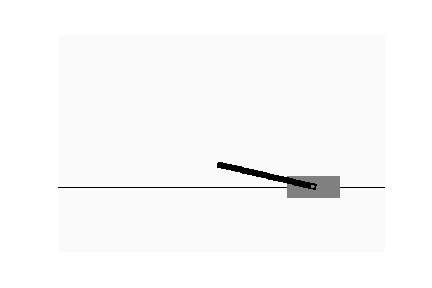
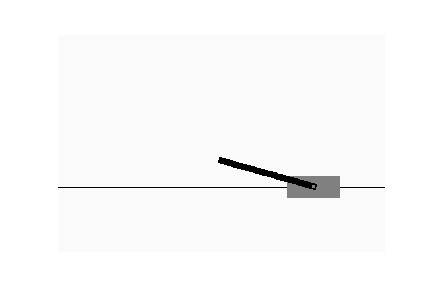
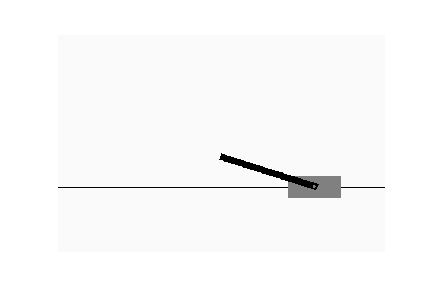
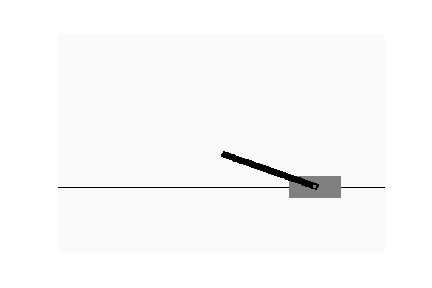
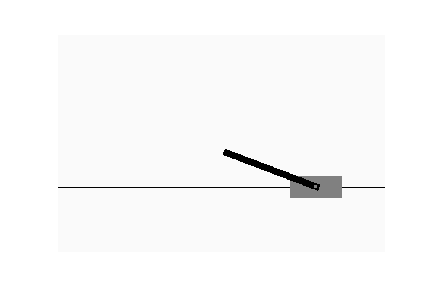
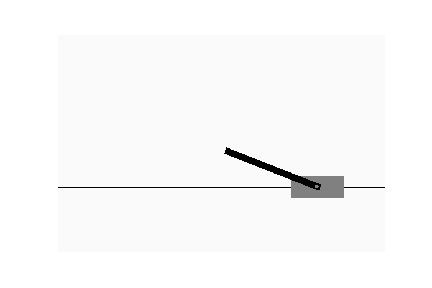
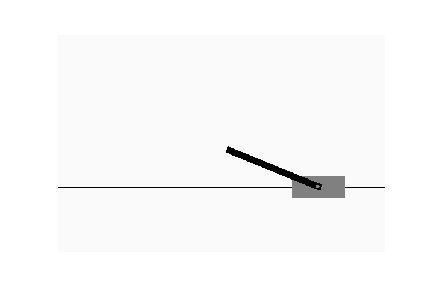
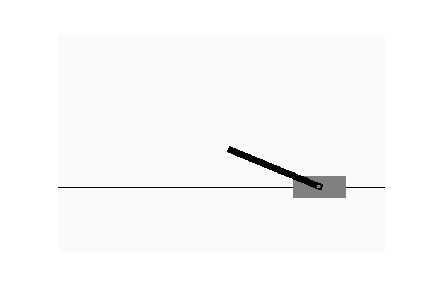
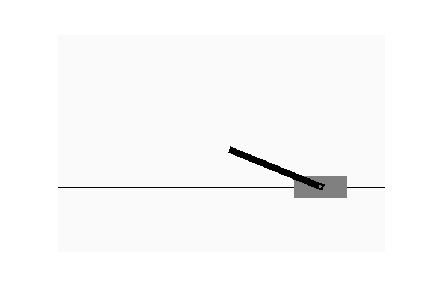
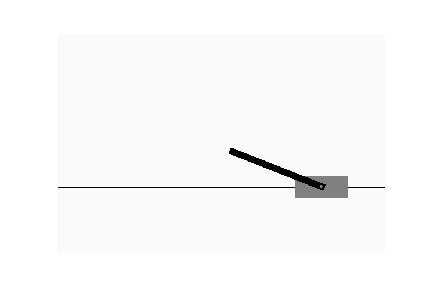
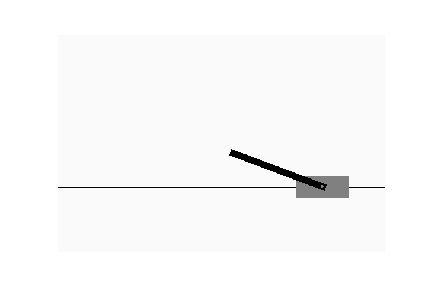
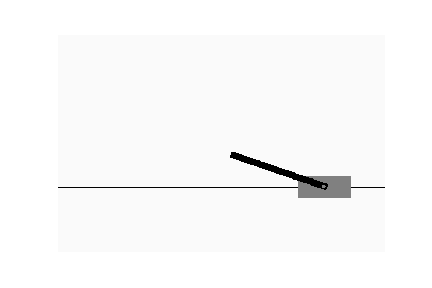
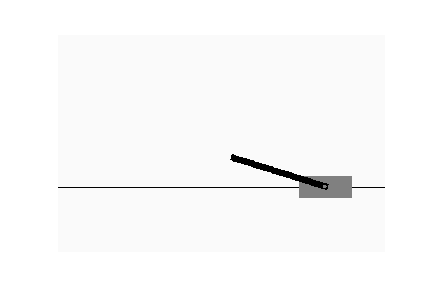
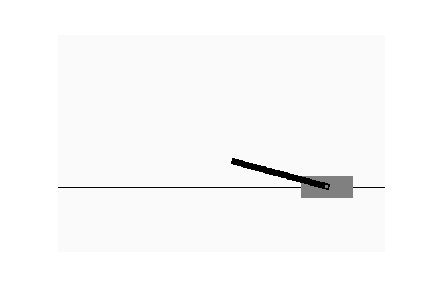
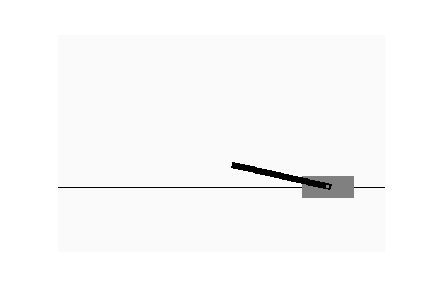
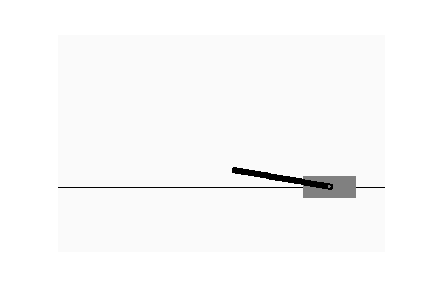
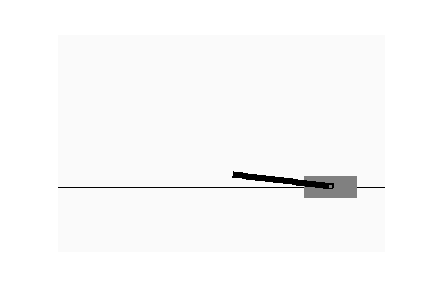
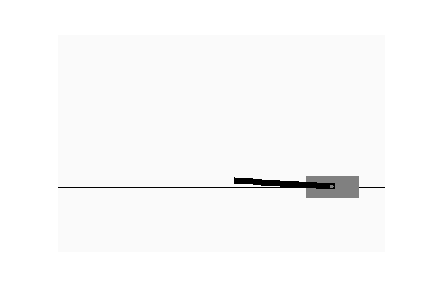
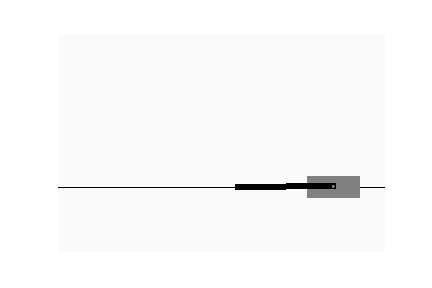
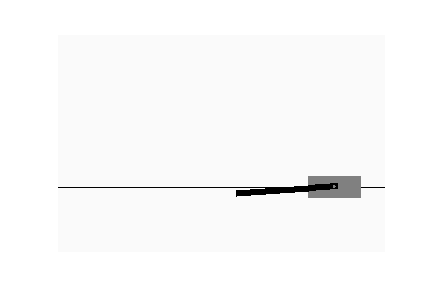
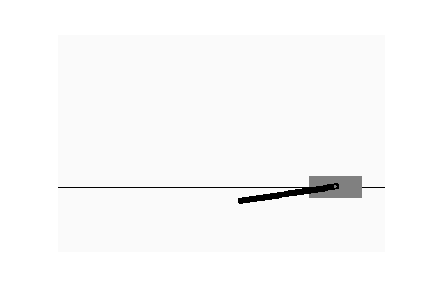
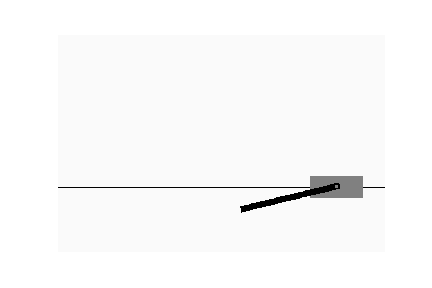
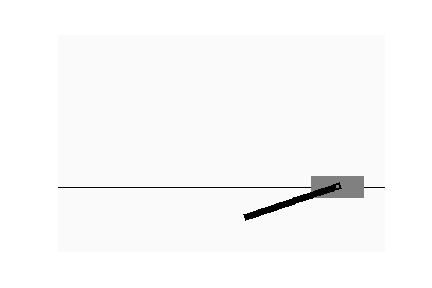
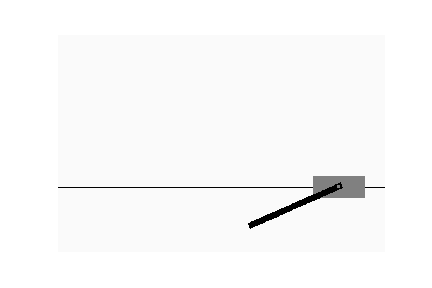
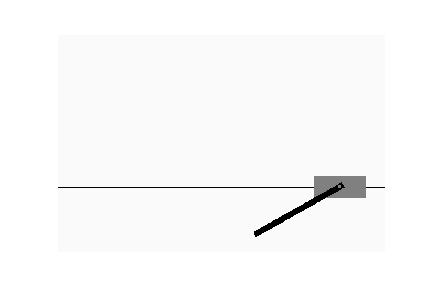
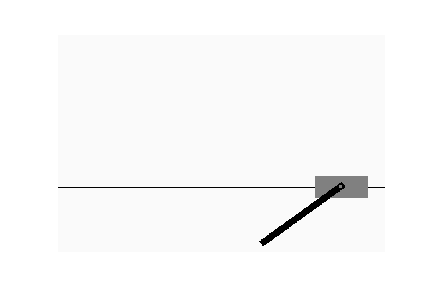
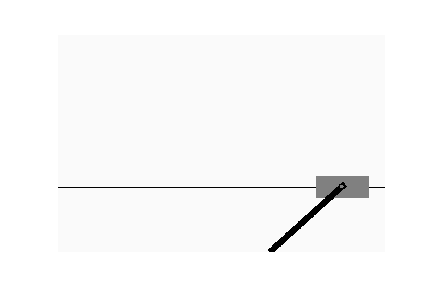
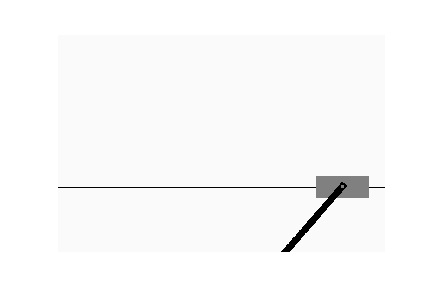
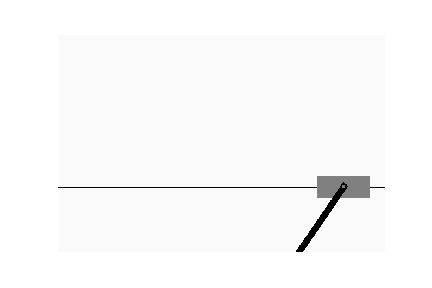
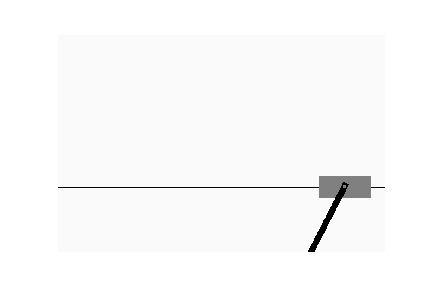
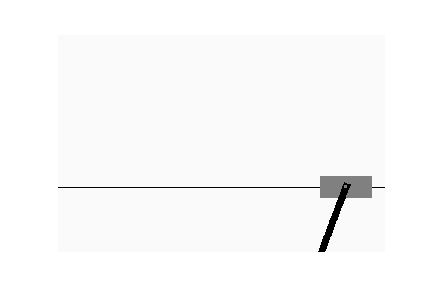
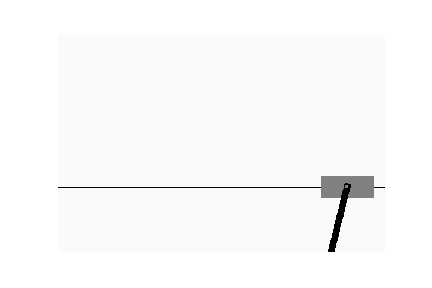
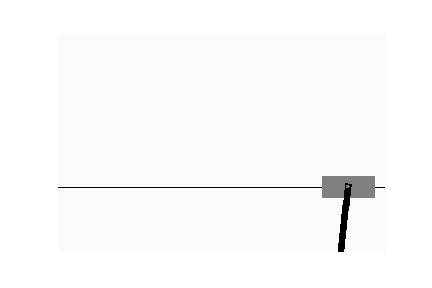
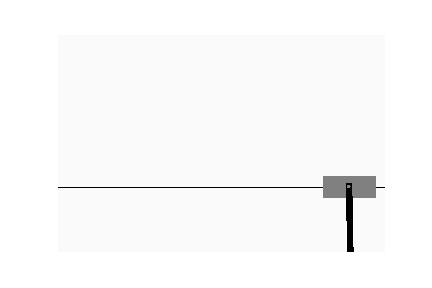
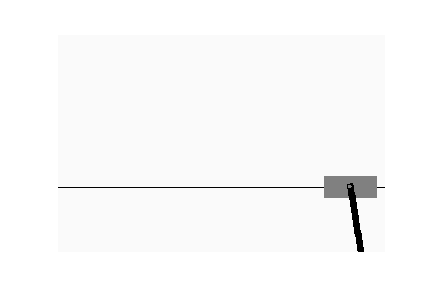
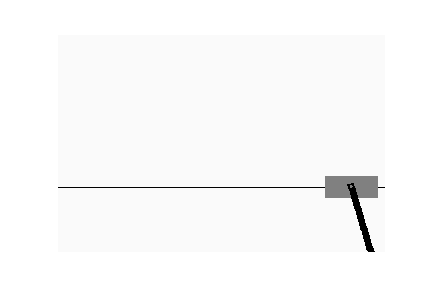
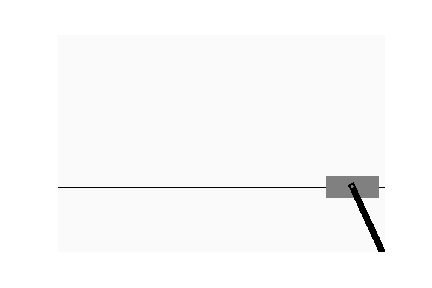
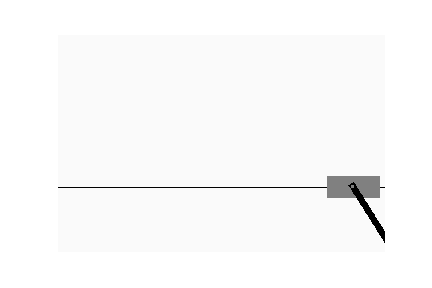
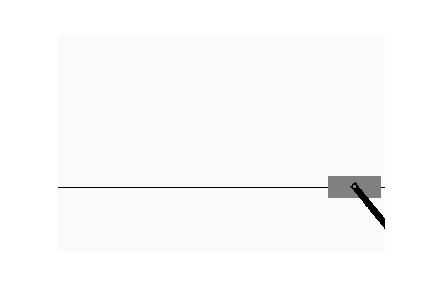
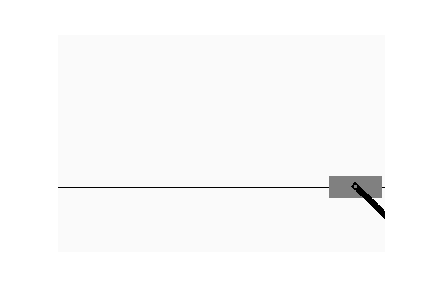
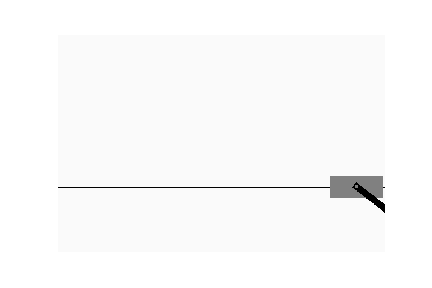
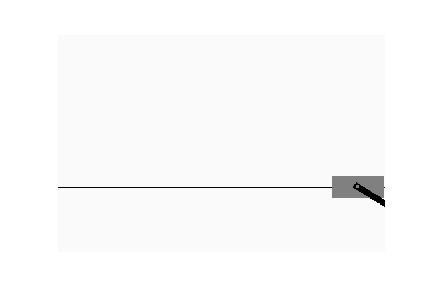
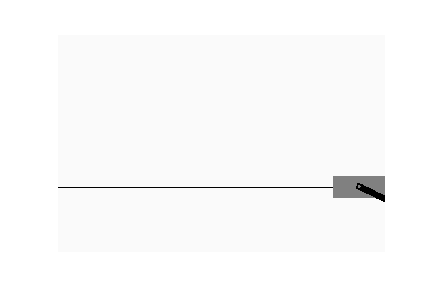
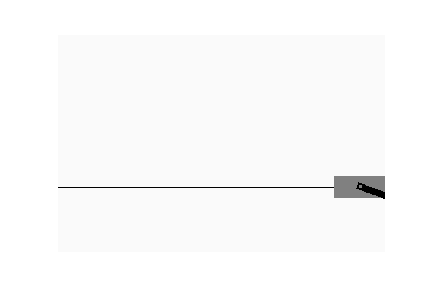
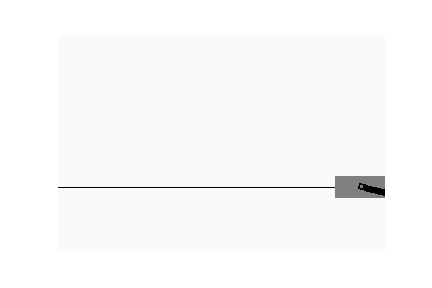
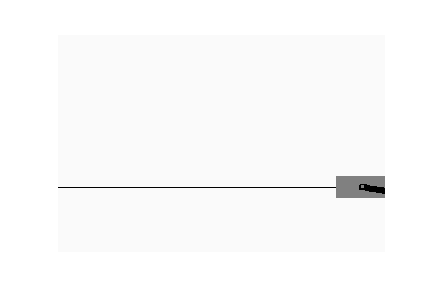
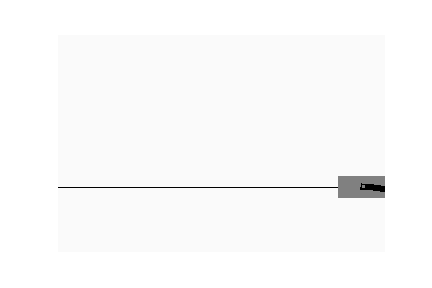
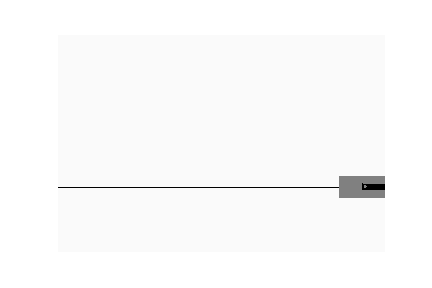
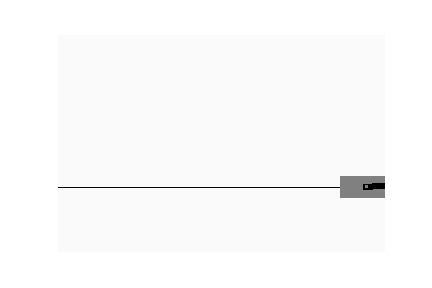
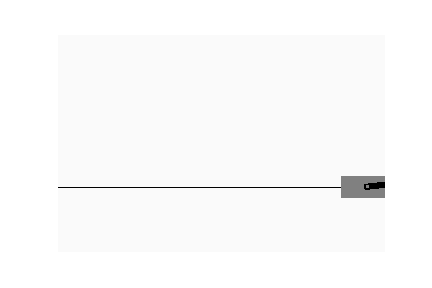
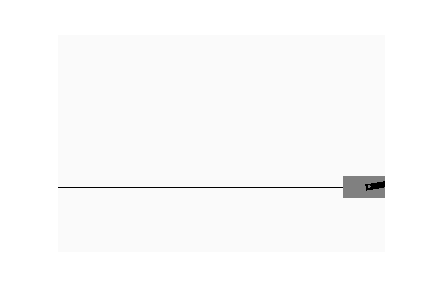
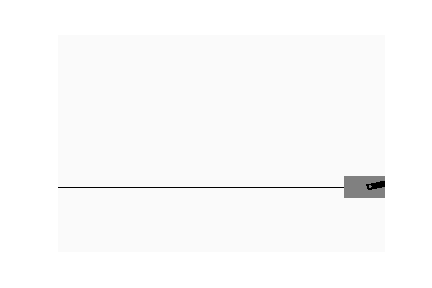
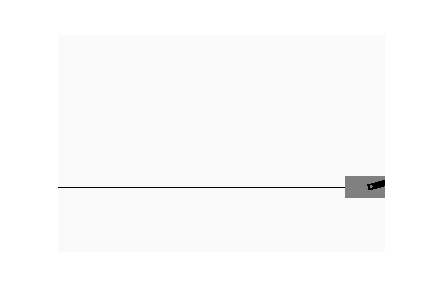
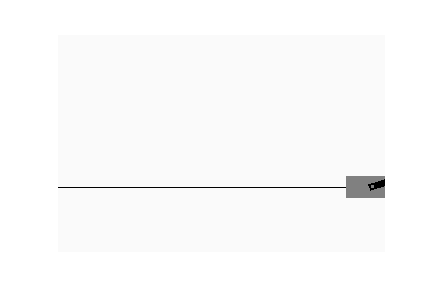
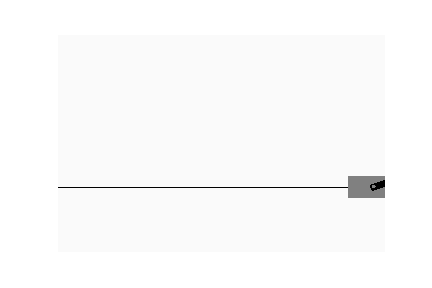
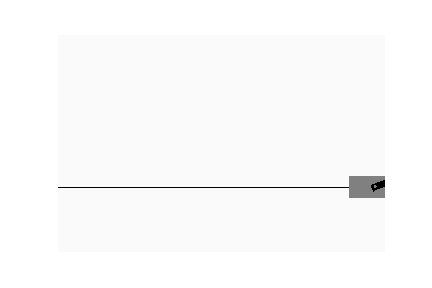
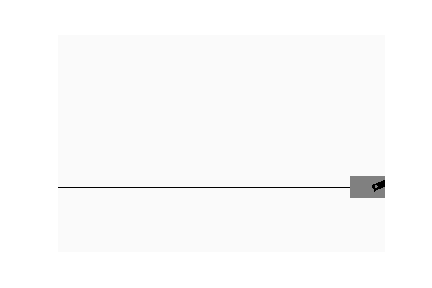
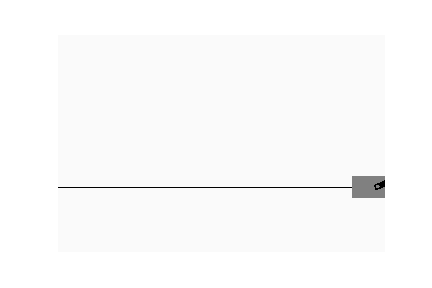
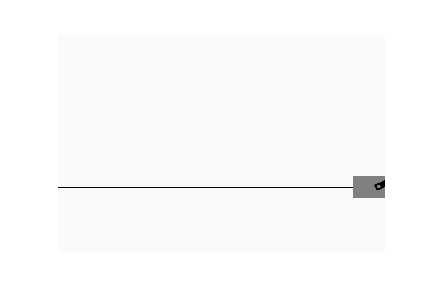
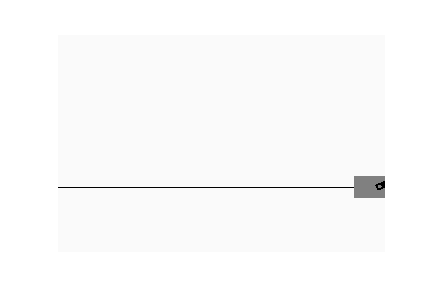
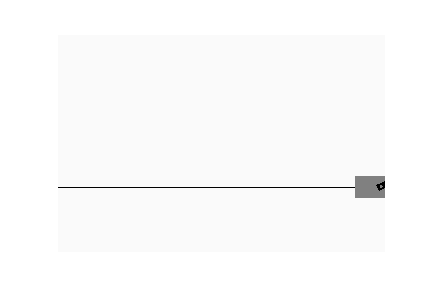
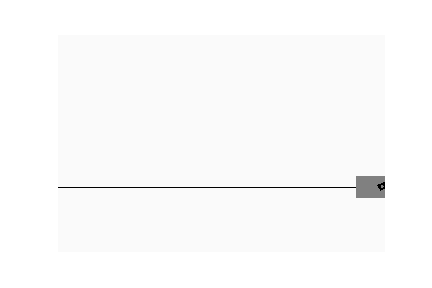
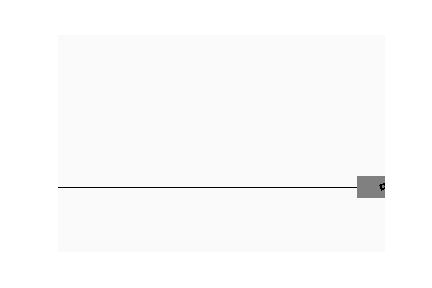
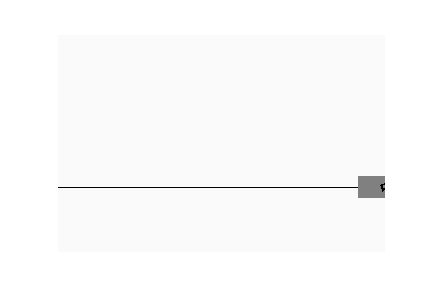
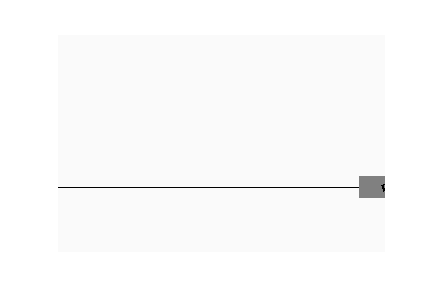
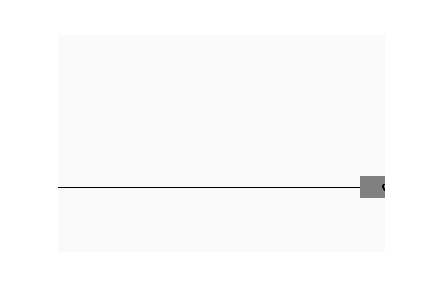
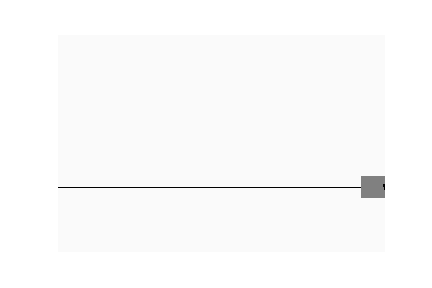
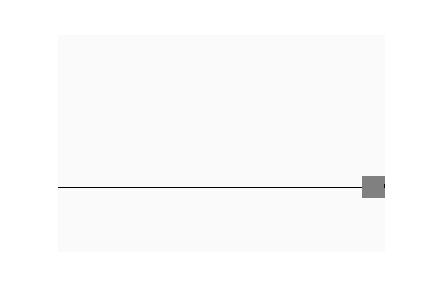
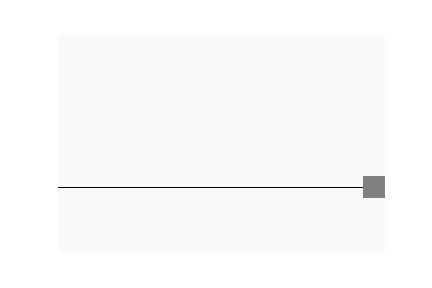
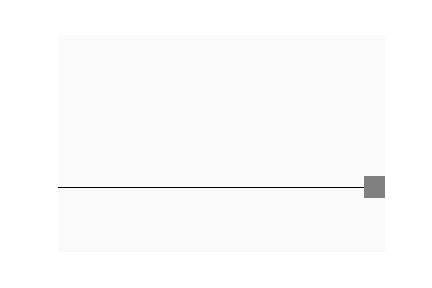
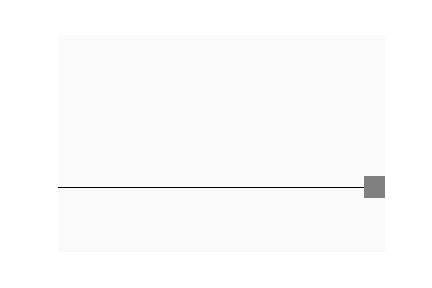
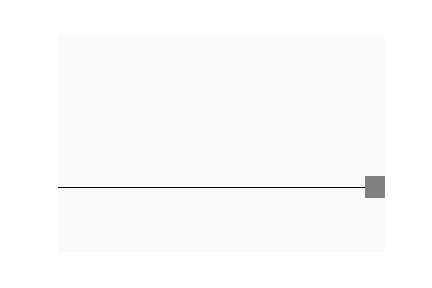
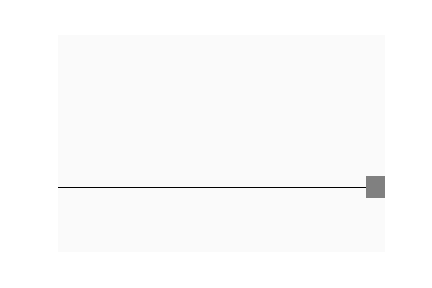
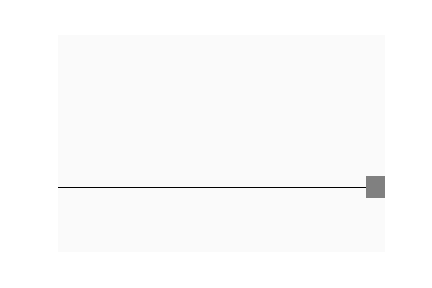
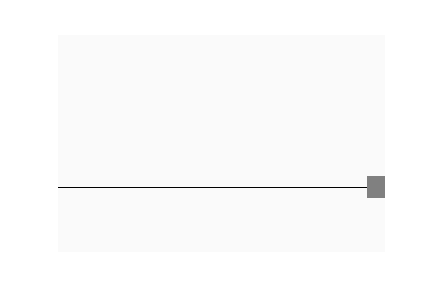
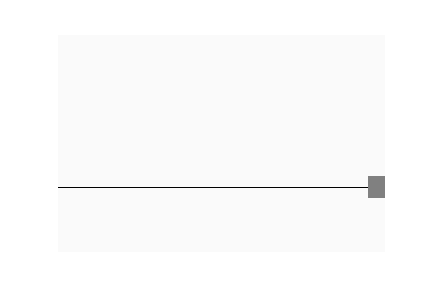
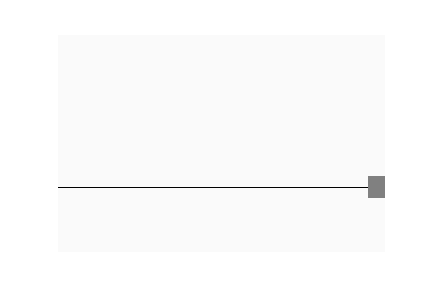
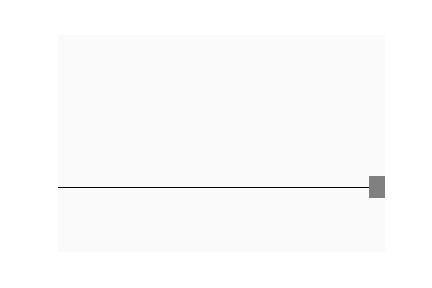
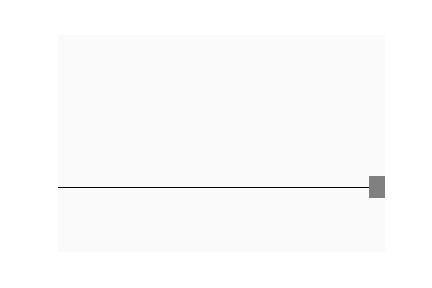
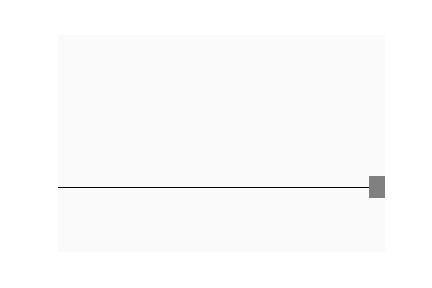

In [4]:
# demo the environment
env.reset() # reset the environment
view = Viewer(env, custom_render=True) # we use this custom viewer to render the environment inline in the notebook
for _ in range(200):
    view.render()
    # env.render() # uncomment this to use gym's own render function
    env.step(env.action_space.sample()) # take a random action
view.render(close=True, display_gif=True) # display the environment inline in the notebook
# env.render(close=True) # uncomment this to use gym'm own render function

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [66]:
# setup policy network
n_inputs = env.observation_space.shape[0]
n_hidden_1 = 64
n_hidden_2 = 32
n_outputs = env.action_space.n

tf.reset_default_graph()

states_pl = tf.placeholder(tf.float32, [None, n_inputs], name='states_pl')
actions_pl = tf.placeholder(tf.int32, [None, n_outputs], name='actions_pl')
advantages_pl = tf.placeholder(tf.float32, [None], name='advantages_pl')
learning_rate_pl = tf.placeholder(tf.float32, name='learning_rate_pl')

l_hidden_1 = tf.layers.dense(inputs=states_pl, units=n_hidden_1, activation=relu, name='l_hidden_1')
l_hidden_2 = tf.layers.dense(inputs=l_hidden_1, units=n_hidden_2, activation=relu, name='l_hidden_2')
l_out = tf.layers.dense(inputs=l_hidden_2, units=n_outputs, activation=softmax, name='l_out')

# print network
print('states_pl:', states_pl.get_shape())
print('actions_pl:', actions_pl.get_shape())
print('advantages_pl:', advantages_pl.get_shape())
print('l_hidden_1:', l_hidden_1.get_shape())
print('l_hidden_2:', l_hidden_2.get_shape())
print('l_out:', l_out.get_shape())

states_pl: (?, 4)
actions_pl: (?, 2)
advantages_pl: (?,)
l_hidden_1: (?, 64)
l_hidden_2: (?, 32)
l_out: (?, 2)


In [67]:
# define loss and optimizer
loss_f = -tf.reduce_mean(tf.multiply(tf.log(tf.gather_nd(l_out, actions_pl)), advantages_pl))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_pl)
train_f = optimizer.minimize(loss_f)

saver = tf.train.Saver() # we use this later to save the model

In [68]:
# test forward pass
state = env.reset()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    action_probabilities = sess.run(fetches=l_out, feed_dict={states_pl: [state]})
print(state)
print(action_probabilities)

[ 0.02048454 -0.02922498  0.01427606  0.03570759]
[[ 0.50068307  0.49931699]]


In [69]:
# helper functions

def get_rollout(sess, env, rollout_limit=None, stochastic=False, seed=None):
    """Generate rollout by iteratively evaluating the current policy on the environment."""
    rollout_limit = rollout_limit or env.spec.timestep_limit
    env.seed(seed)
    s = env.reset()
    states, actions, rewards = [], [], []
    for i in range(rollout_limit):
        a = get_action(sess, s, stochastic)
        s1, r, done, _ = env.step(a)
        states.append(s)
        actions.append(a)
        rewards.append(r)
        s = s1
        if done: break
    env.seed(None)
    return states, actions, rewards, i+1

def get_action(sess, state, stochastic=False):
    """Choose an action, given a state, with the current policy network."""
    # get action probabilities
    a_prob = sess.run(fetches=l_out, feed_dict={states_pl: np.atleast_2d(state)})
    if stochastic:
        # sample action from distribution
        return (np.cumsum(np.asarray(a_prob)) > np.random.rand()).argmax()
    else:
        # select action with highest probability
        return a_prob.argmax()

def get_advantages(rewards, rollout_limit, discount_factor, eps=1e-12):
    """Compute advantages"""
    returns = get_returns(rewards, rollout_limit, discount_factor)
    # standardize columns of returns to get advantages
    advantages = (returns - np.mean(returns, axis=0)) / (np.std(returns, axis=0) + eps)
    # restore original rollout lengths
    advantages = [adv[:len(rewards[i])] for i, adv in enumerate(advantages)]
    return advantages

def get_returns(rewards, rollout_limit, discount_factor):
    """Compute the cumulative discounted rewards, a.k.a. returns."""
    returns = np.zeros((len(rewards), rollout_limit))
    for i, r in enumerate(rewards):
        returns[i, len(r) - 1] = r[-1]
        for j in reversed(range(len(r)-1)):
            returns[i,j] = r[j] + discount_factor * returns[i,j+1]
    return returns

In [77]:
# training settings

epochs = 100 # number of training batches
batch_size = 256 # number of timesteps in a batch
rollout_limit = 100#env.spec.timestep_limit # (this is 200) max rollout length
discount_factor = 0.3 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
early_stop_loss = 0.05 # stop training if loss < early_stop_loss, 0 or False to disable

# train policy network

try:
    statistics = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('start training')
        for epoch in range(epochs):
            # generate rollouts until batch_size total timesteps are collected
            states, actions, rewards = [], [], []
            timesteps = 0
            while timesteps < batch_size:
                _rollout_limit = min(rollout_limit, batch_size - timesteps) # limit rollout to match batch_size
                s, a, r, t = get_rollout(sess, env, _rollout_limit, stochastic=True, seed=epoch)            
                states.append(s)
                actions.append(a)
                rewards.append(r)
                timesteps += t
            # compute advantages
            advantages = get_advantages(rewards, rollout_limit, discount_factor)
            # policy gradient update
            loss, _ = sess.run(fetches=[loss_f, train_f], feed_dict={
                states_pl: np.concatenate(states),
                actions_pl: np.column_stack((np.arange(timesteps), np.concatenate(actions))),
                advantages_pl: np.concatenate(advantages),
                learning_rate_pl: learning_rate
            })            
            # validation
            val_rewards = [get_rollout(sess, env, rollout_limit, stochastic=False, seed=(epochs+i))[2] for i in range(10)]
            # store and print training statistics
            mtr = np.mean([np.sum(r) for r in rewards])
            mvr = np.mean([np.sum(r) for r in val_rewards])
            statistics.append((mtr, mvr, loss))
            print('%4d. training reward: %6.2f, validation reward: %6.2f, loss: %7.4f' % (epoch+1, mtr, mvr, loss))
            # early stopping
            if early_stop_loss and loss < early_stop_loss: break
        print('done')
        # save session
        saver.save(sess, 'tmp/model.ckpt')
except KeyboardInterrupt:
    pass    

start training
   1. training reward:  23.27, validation reward:   9.30, loss:  0.6044
   2. training reward:  23.27, validation reward:   9.30, loss:  0.5296
   3. training reward:  23.27, validation reward:   9.30, loss:  0.4331
   4. training reward:  25.60, validation reward:   9.30, loss:  0.5854
   5. training reward:  18.29, validation reward:   9.70, loss:  0.3891
   6. training reward:  25.60, validation reward:  11.60, loss:  0.5590
   7. training reward:  23.27, validation reward:  14.70, loss:  0.5545
   8. training reward:  18.29, validation reward:  15.00, loss:  0.3687
   9. training reward:  19.69, validation reward:  15.70, loss:  0.3642
  10. training reward:  21.33, validation reward:  15.30, loss:  0.5907
  11. training reward:  18.29, validation reward:  15.70, loss:  0.3841
  12. training reward:  19.69, validation reward:  13.20, loss:  0.3704
  13. training reward:  21.33, validation reward:  12.40, loss:  0.2789
  14. training reward:  19.69, validation reward:

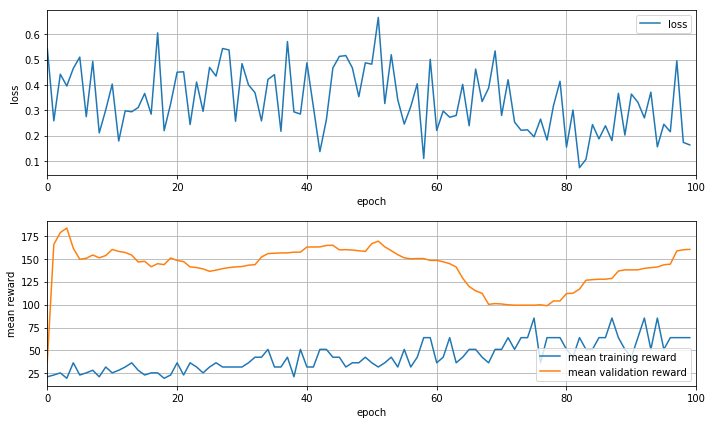

In [73]:
# plot training statistics
statistics = np.array(statistics).T
mean_training_rewards = statistics[0]
mean_validation_rewards = statistics[1]
losses = statistics[2]

plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(losses, label='loss')
plt.xlabel('epoch'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=1); plt.grid()
plt.subplot(212)
plt.plot(mean_training_rewards, label='mean training reward')
plt.plot(mean_validation_rewards, label='mean validation reward')
plt.xlabel('epoch'); plt.ylabel('mean reward')
plt.xlim((0, len(mean_validation_rewards)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

INFO:tensorflow:Restoring parameters from tmp/model.ckpt


[2017-10-12 12:26:19,565] Restoring parameters from tmp/model.ckpt
[2017-10-12 12:26:19,881] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.



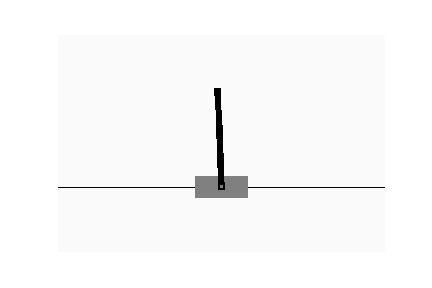
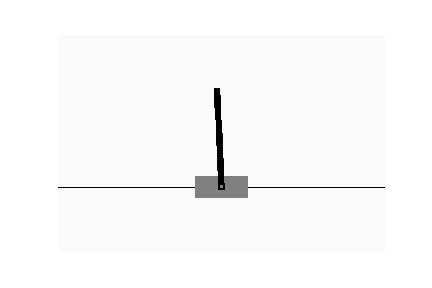
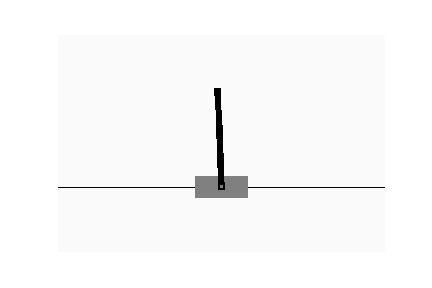
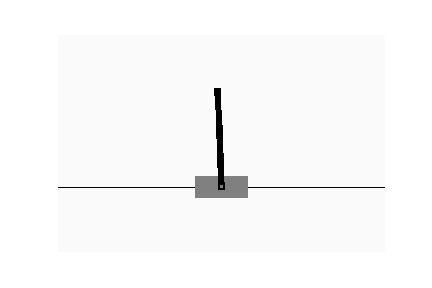
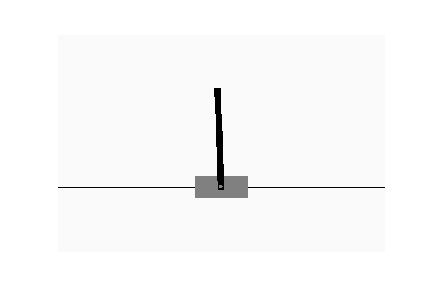
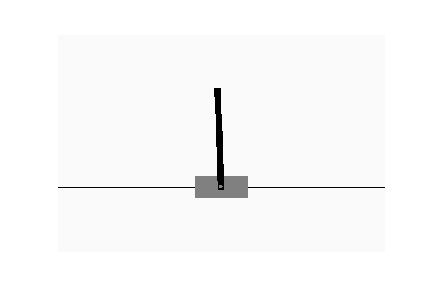
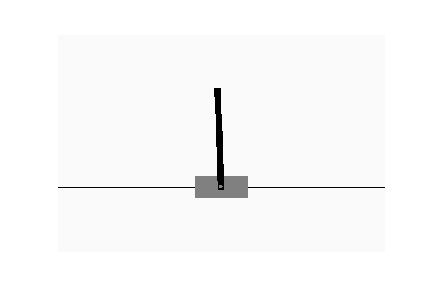
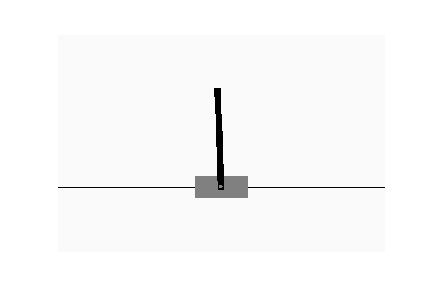
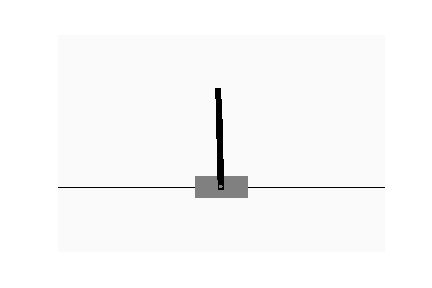
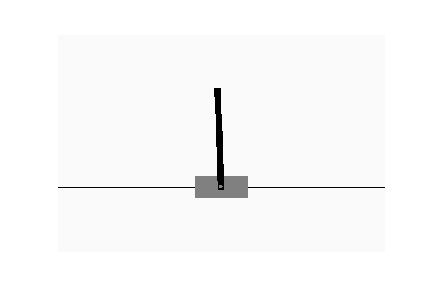
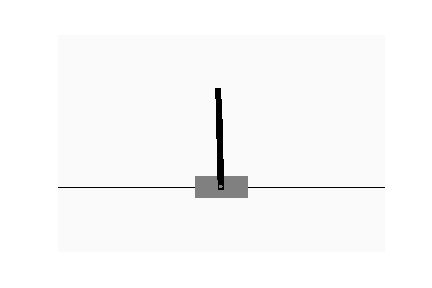
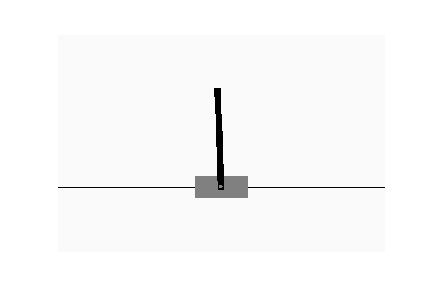
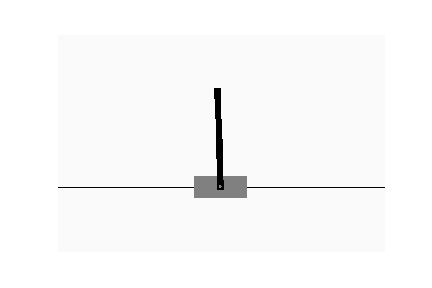
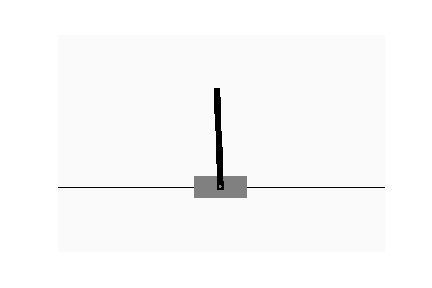
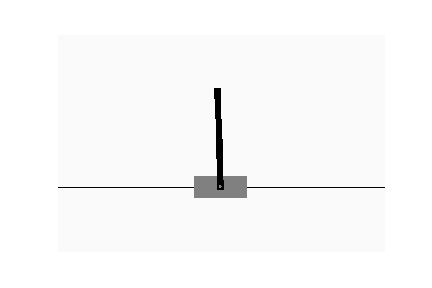
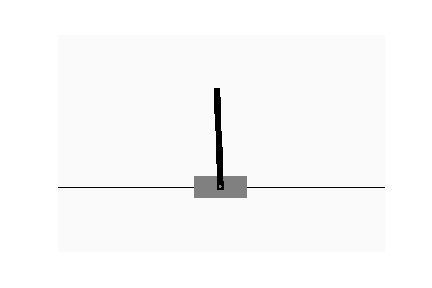
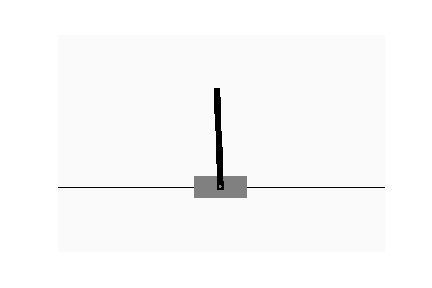
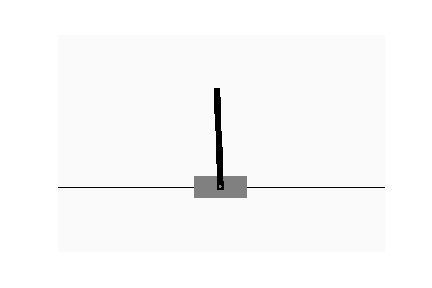
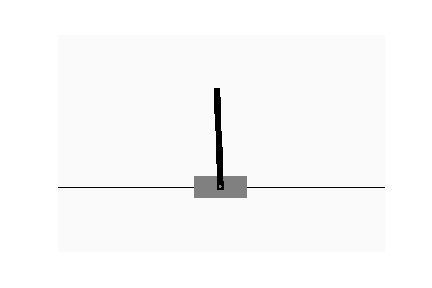
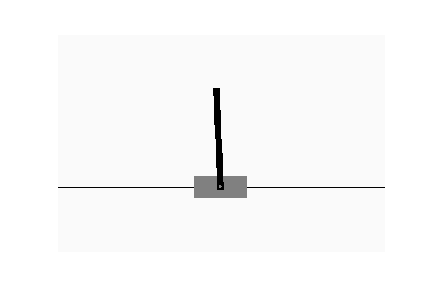
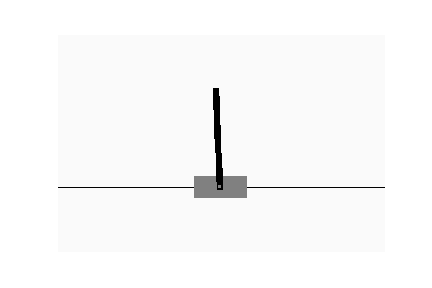
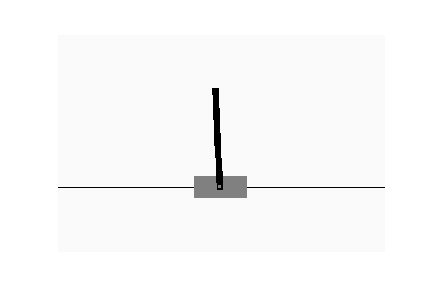
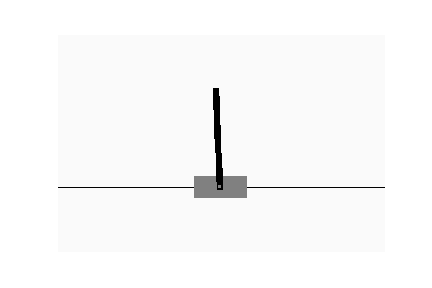
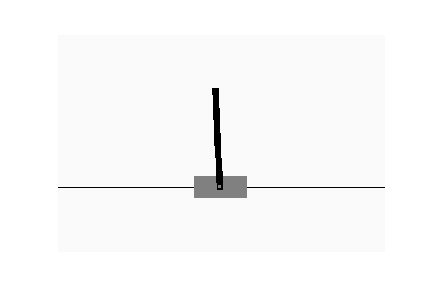
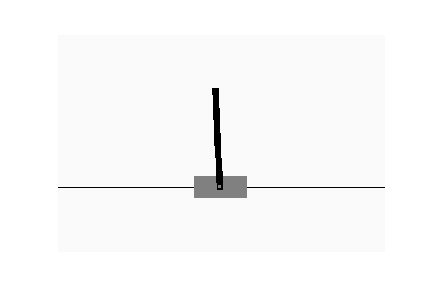
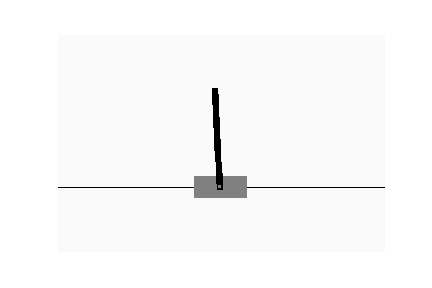
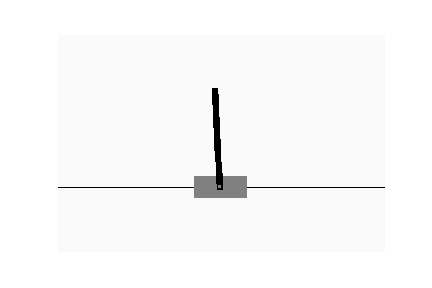
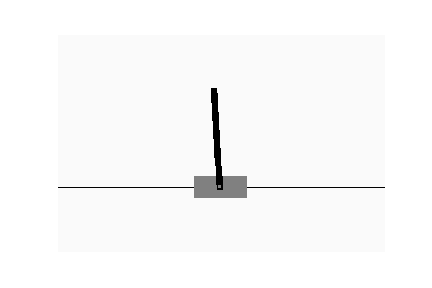
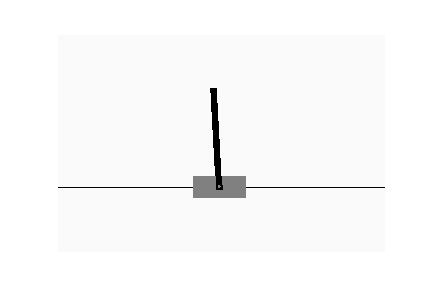
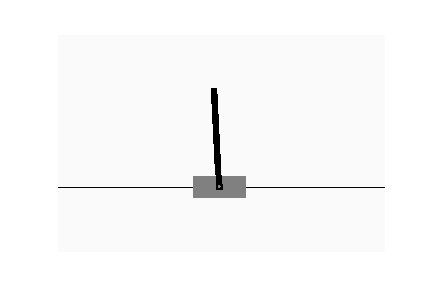
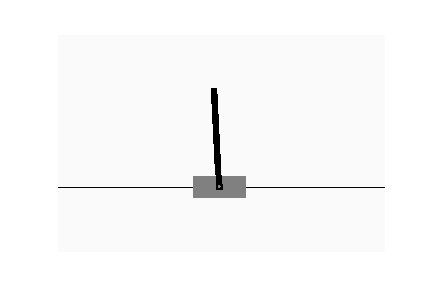
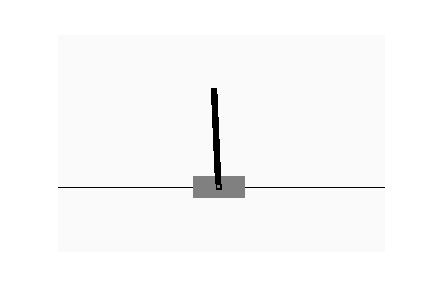
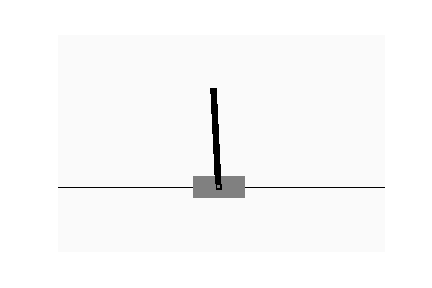
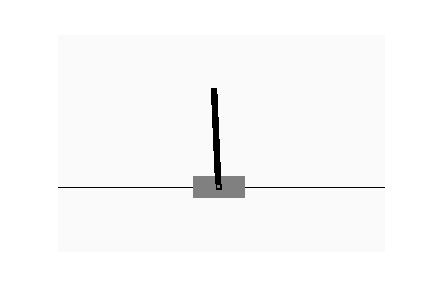
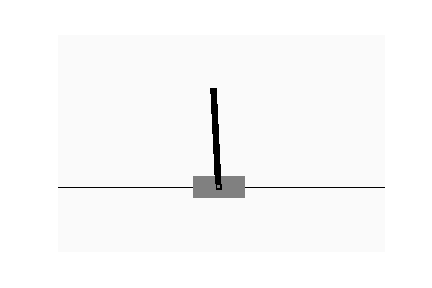
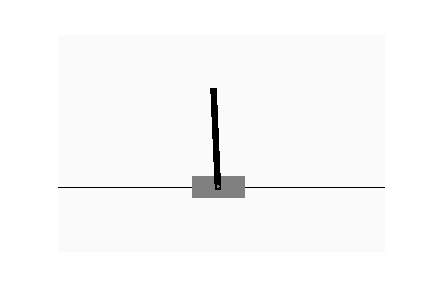
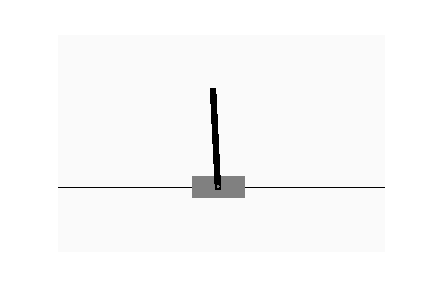
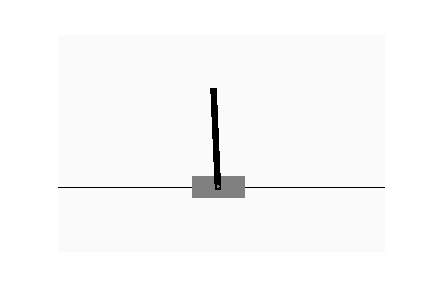
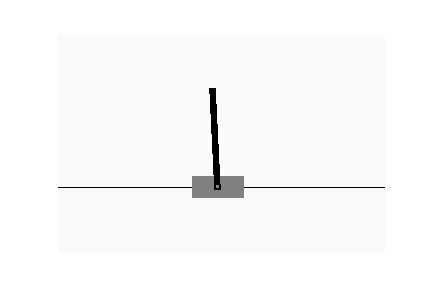
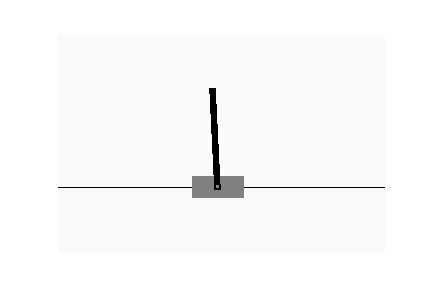
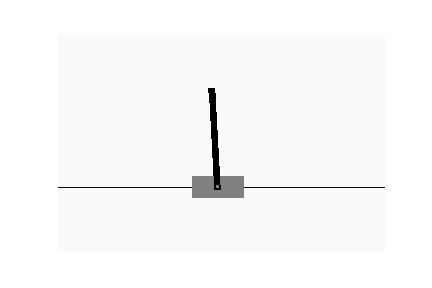
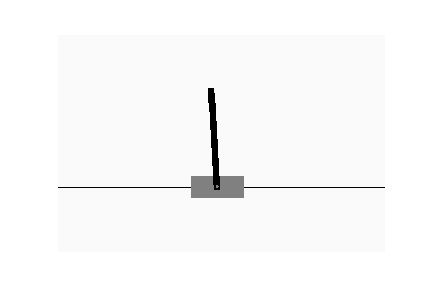
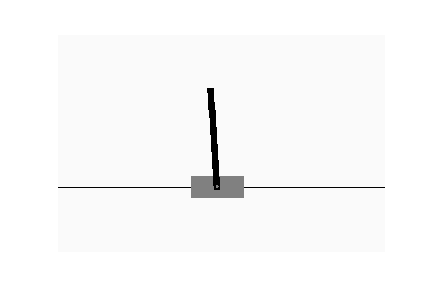
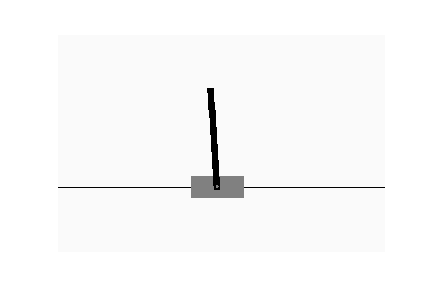
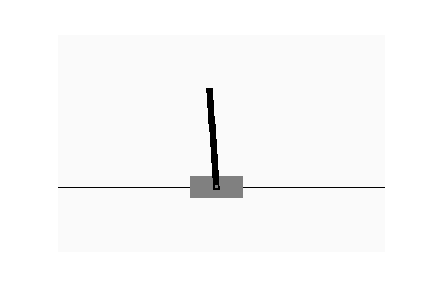
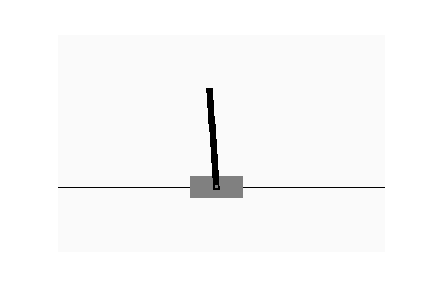
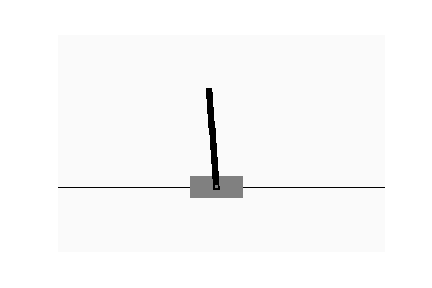
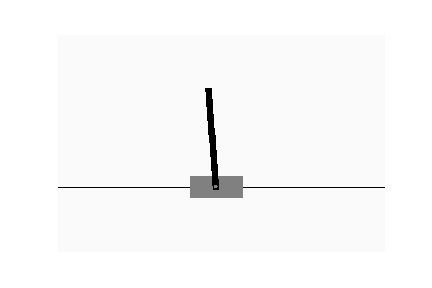
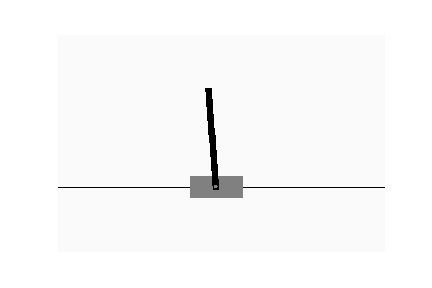
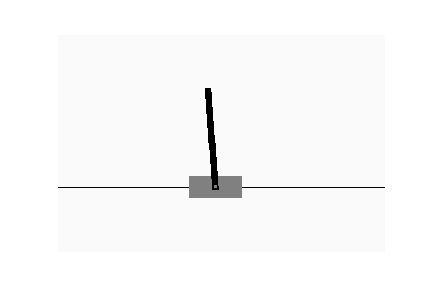
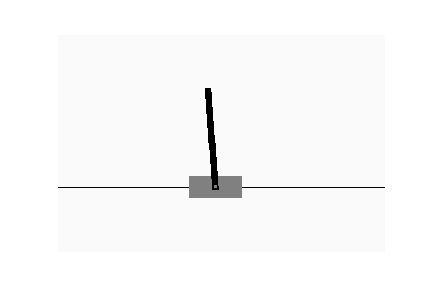
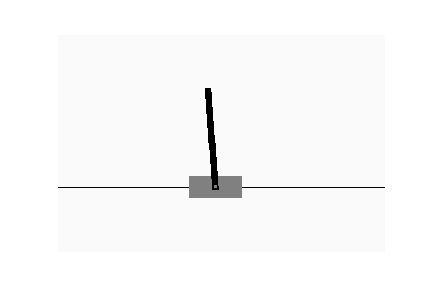
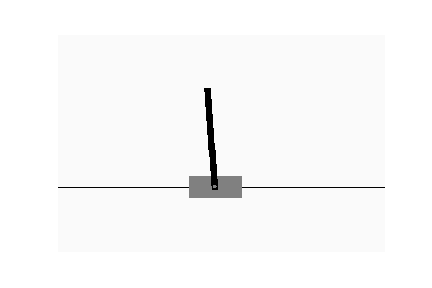
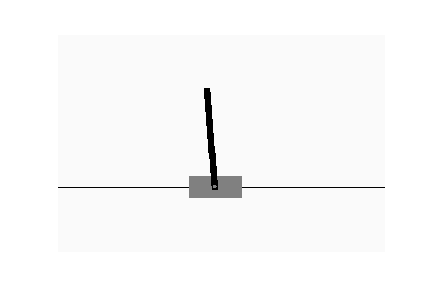
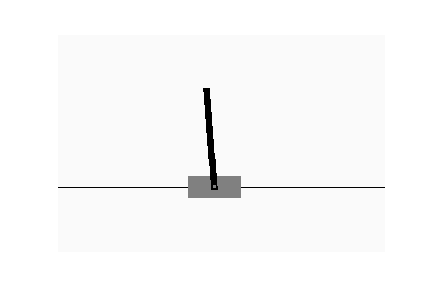
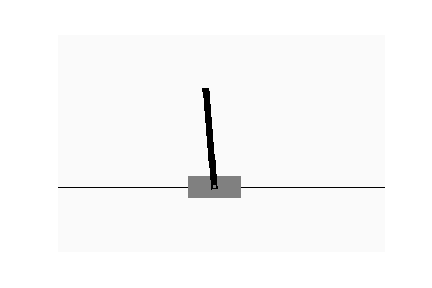
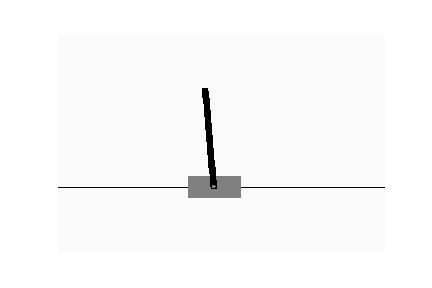
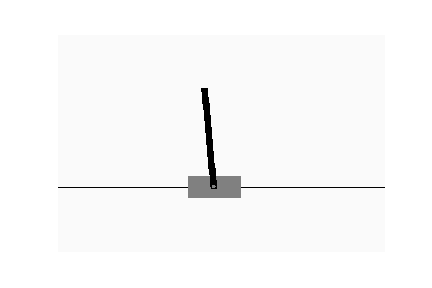
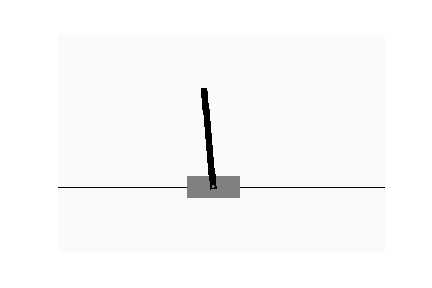
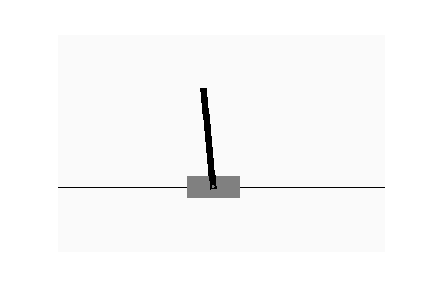
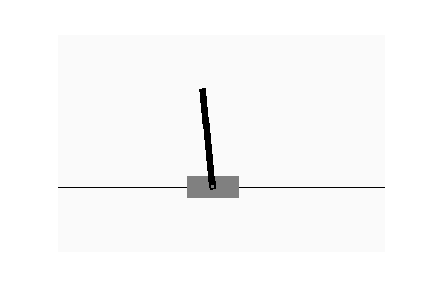
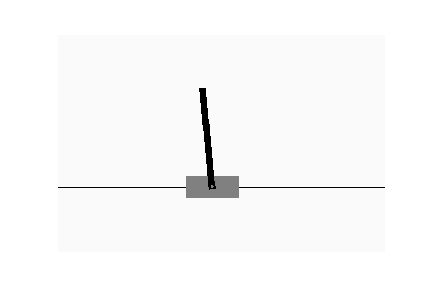
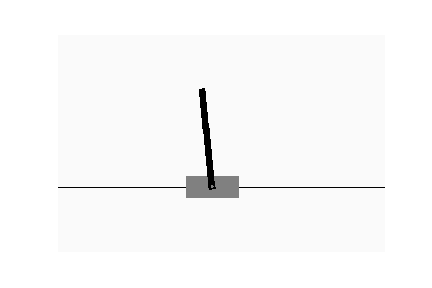
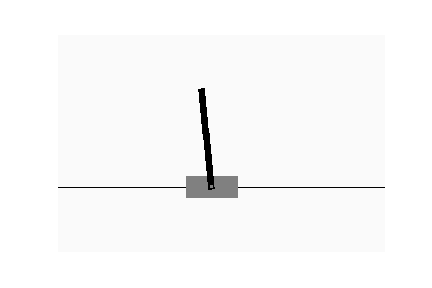
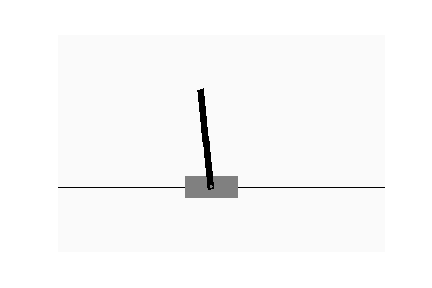
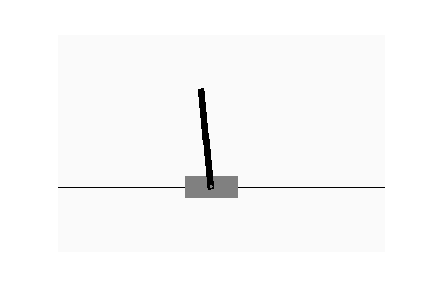
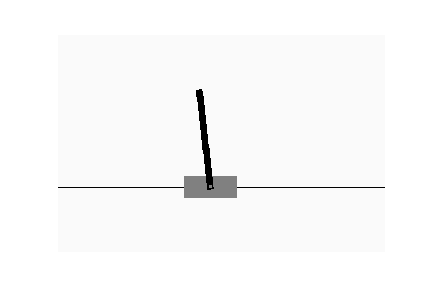
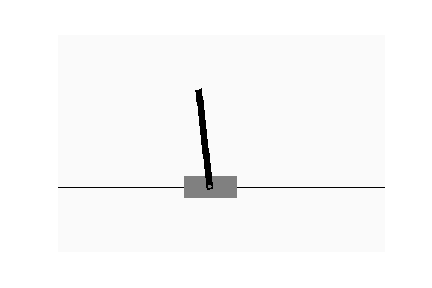
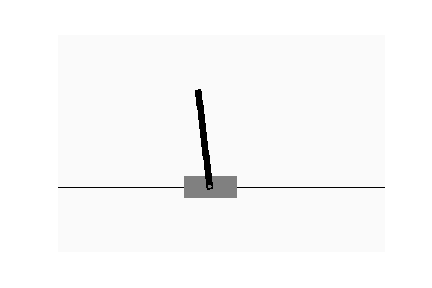
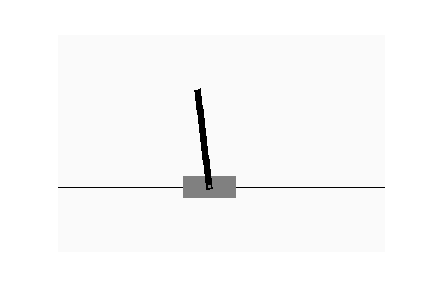
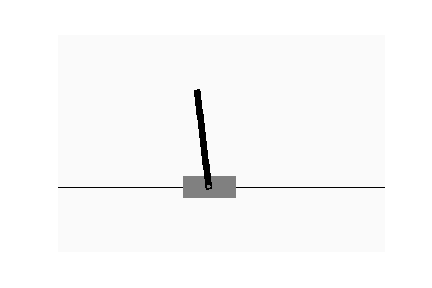
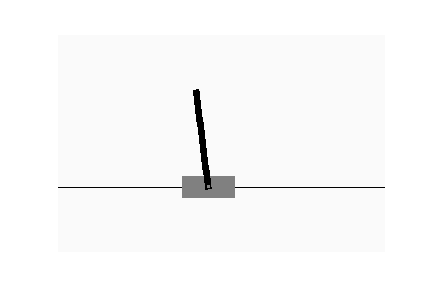
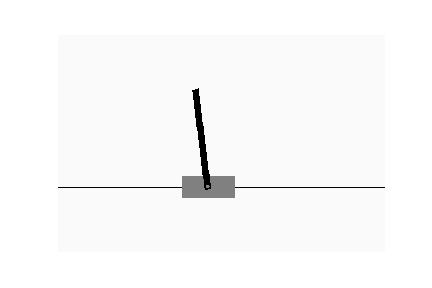
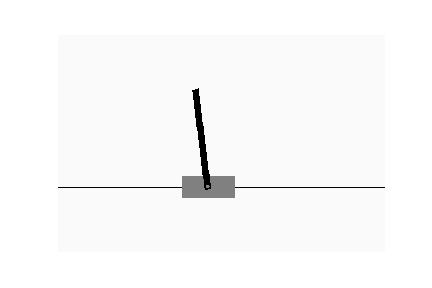
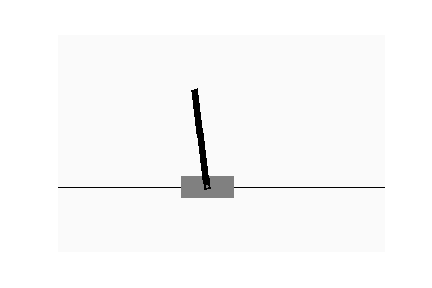
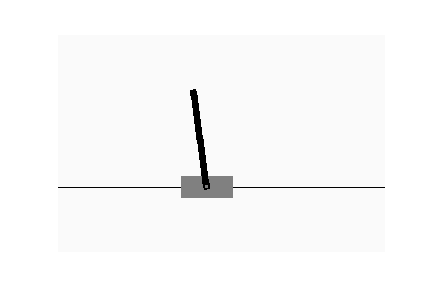
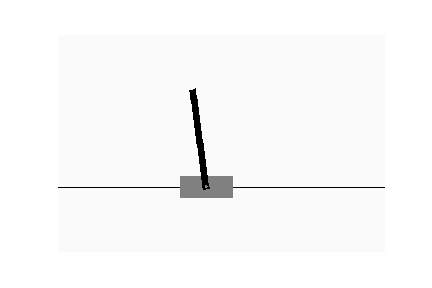
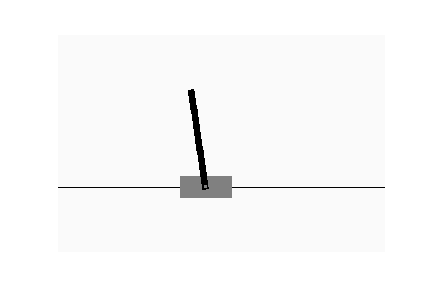
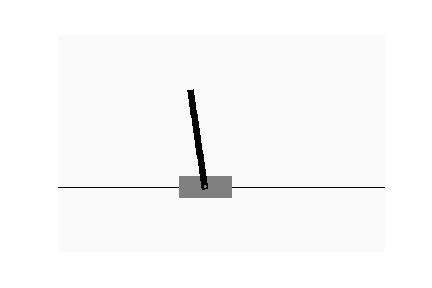
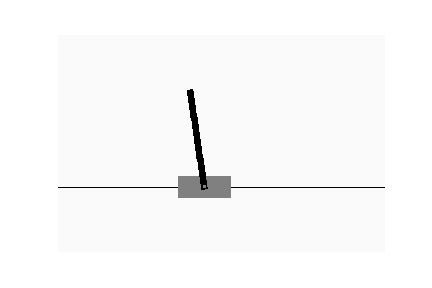
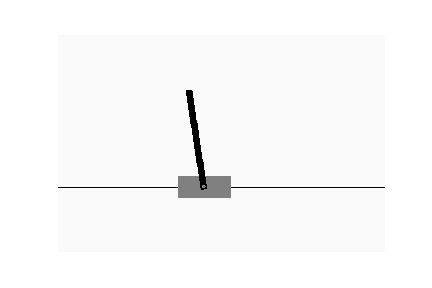
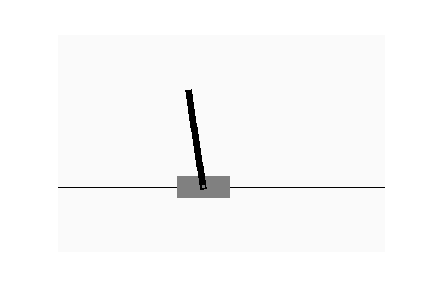
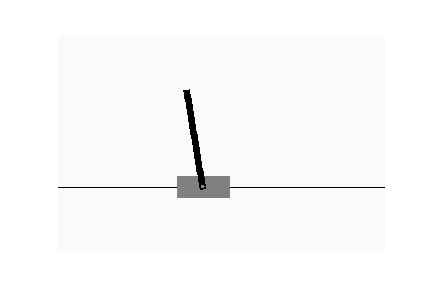
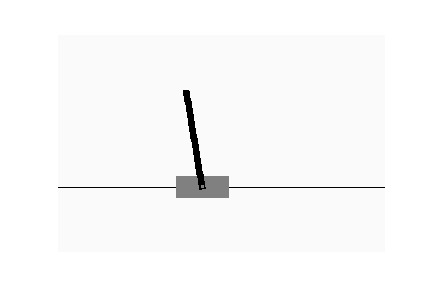
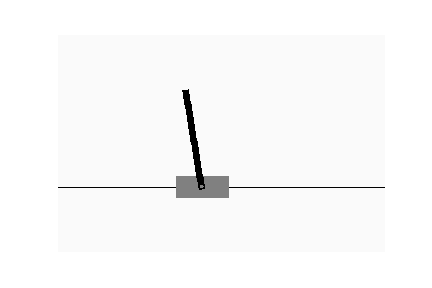
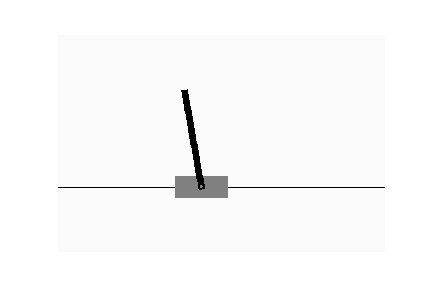
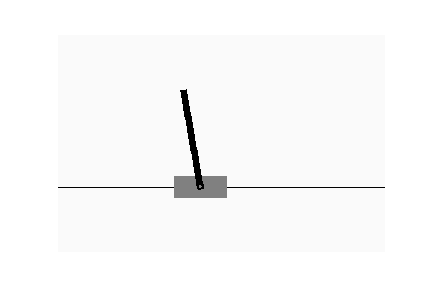
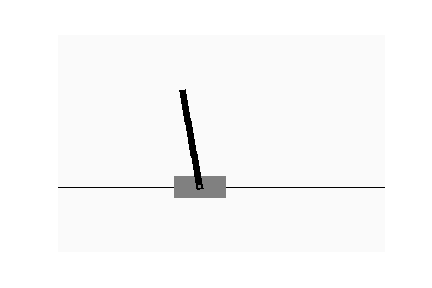
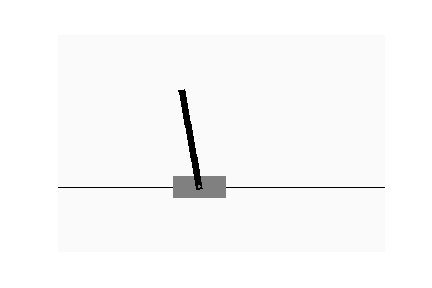
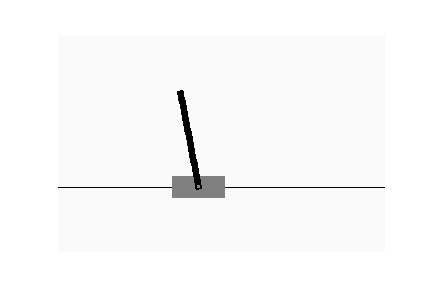
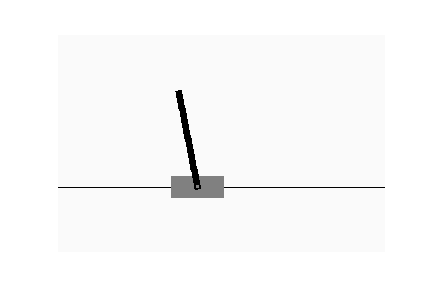
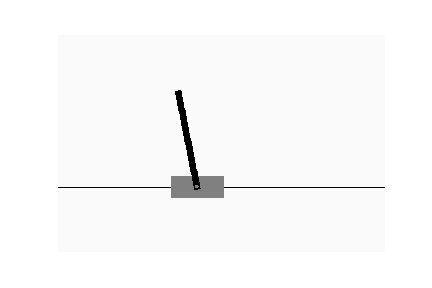
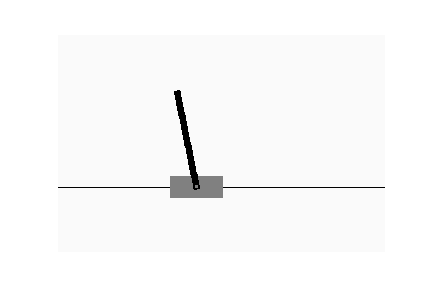
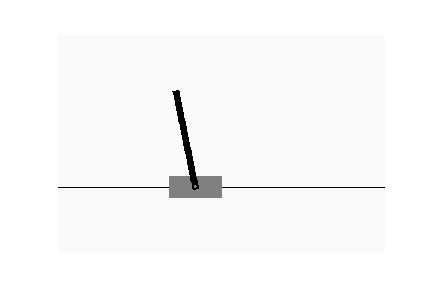
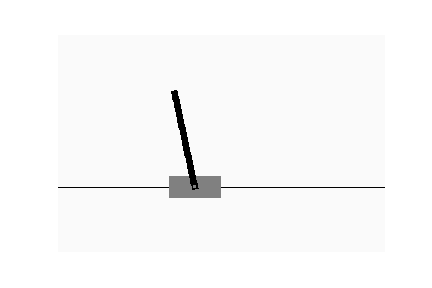
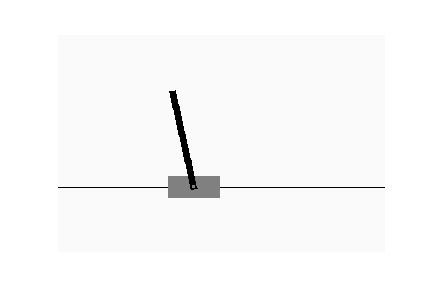
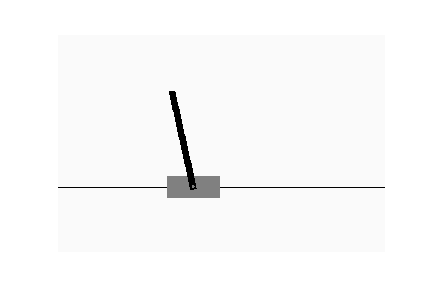
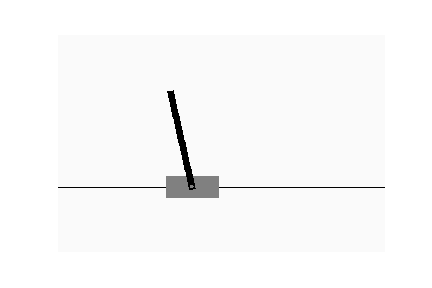
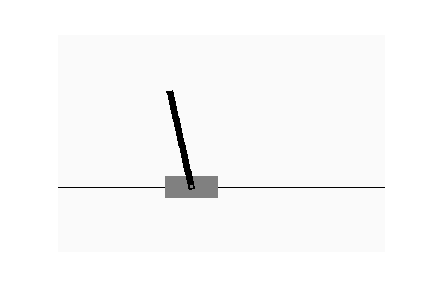
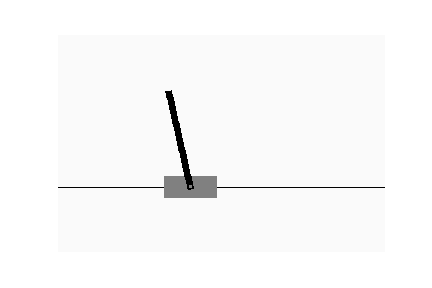
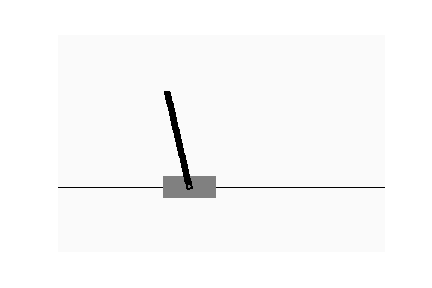
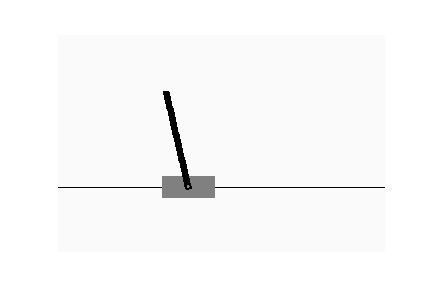
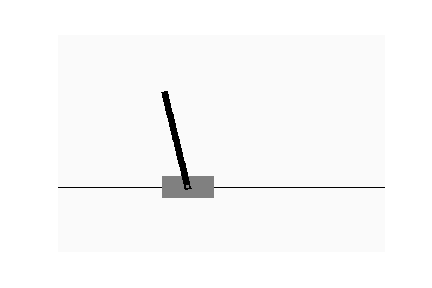
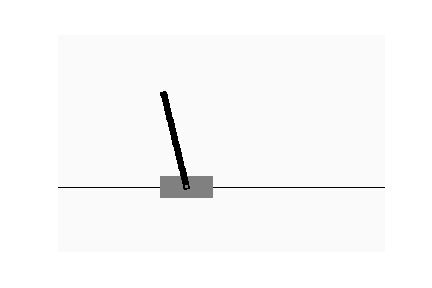
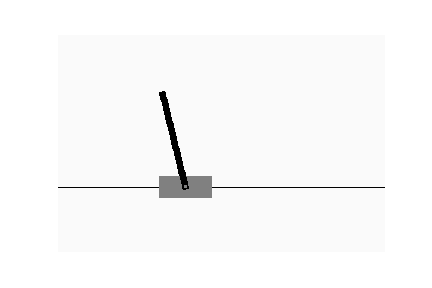
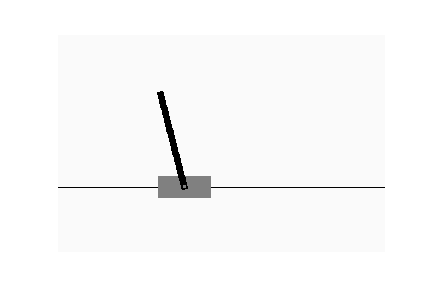
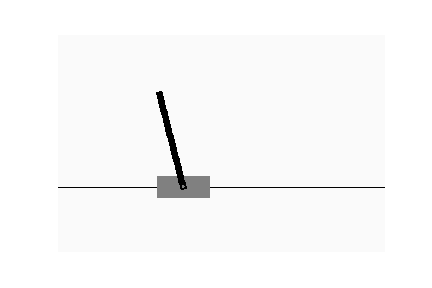
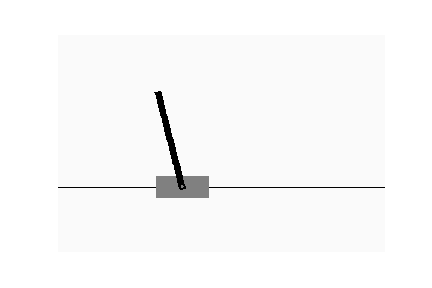
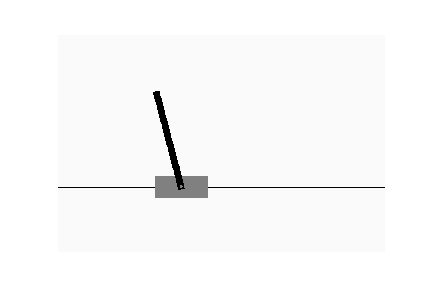
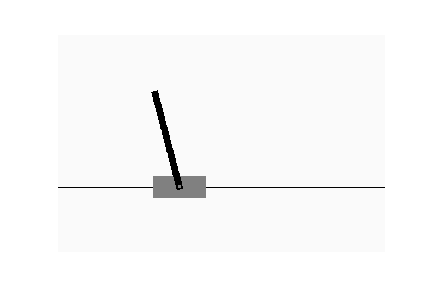
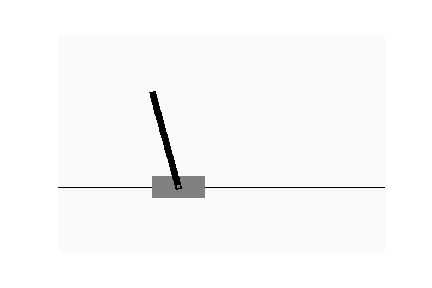
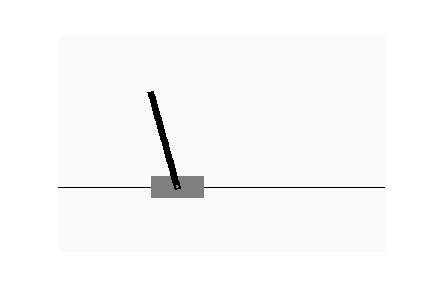
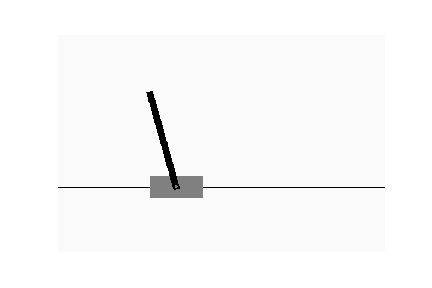
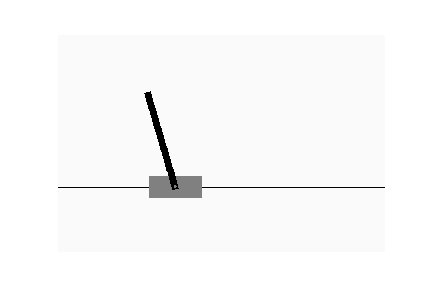
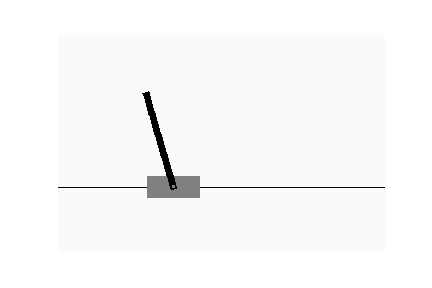
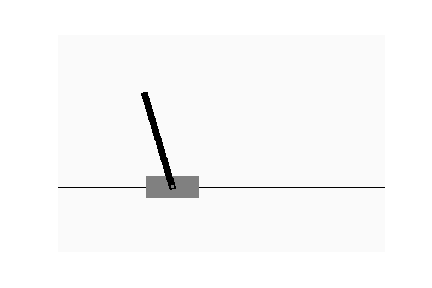
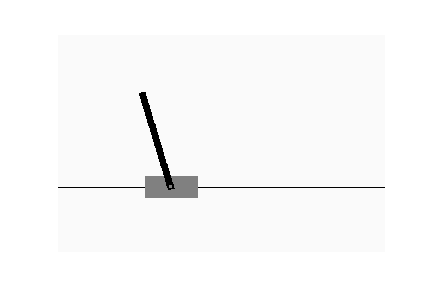
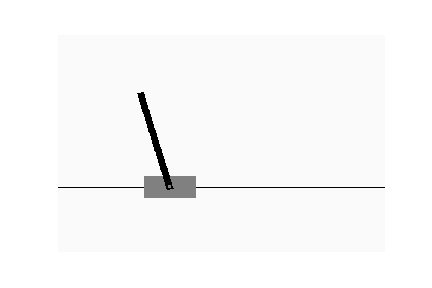
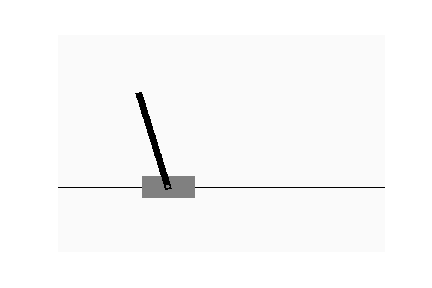
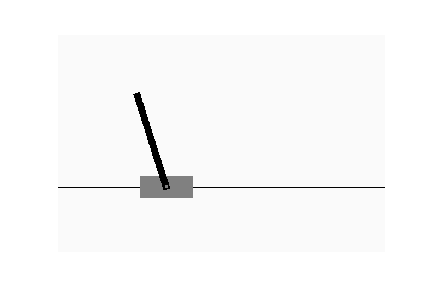
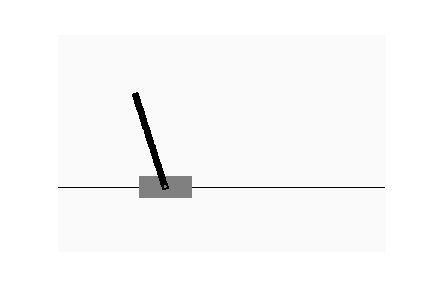
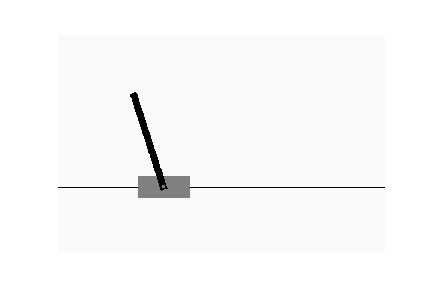
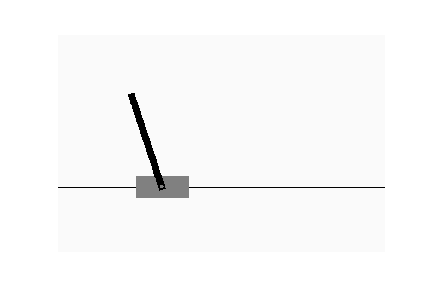
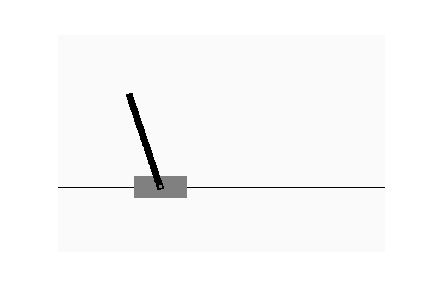
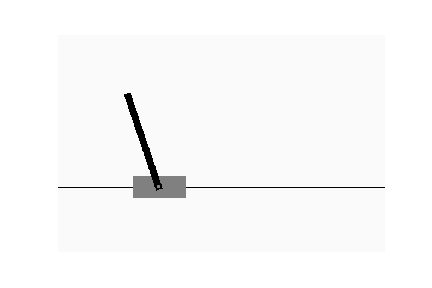
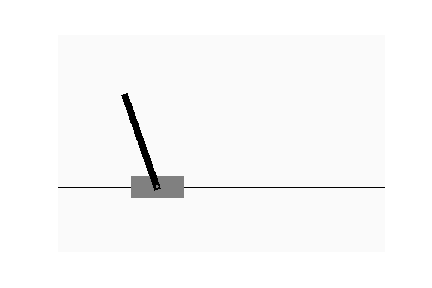
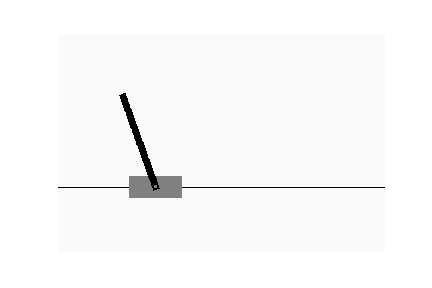
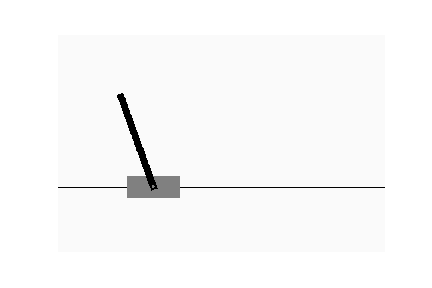
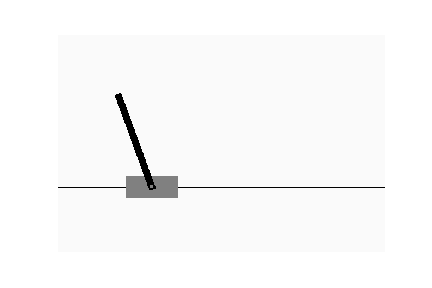
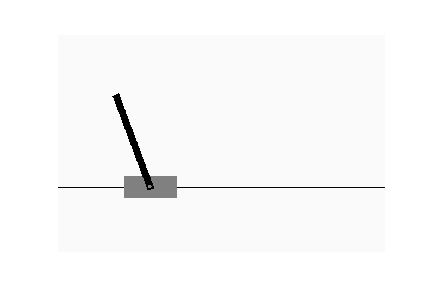
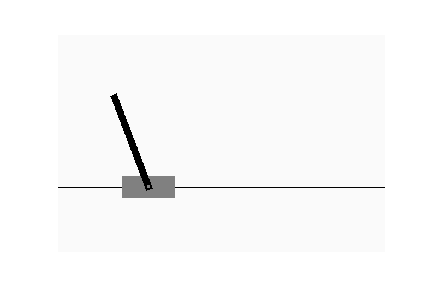
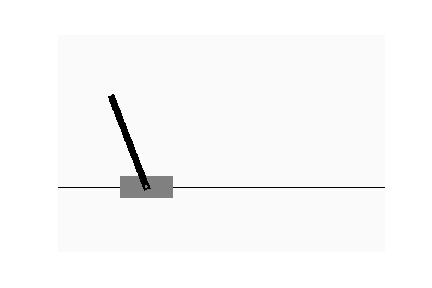
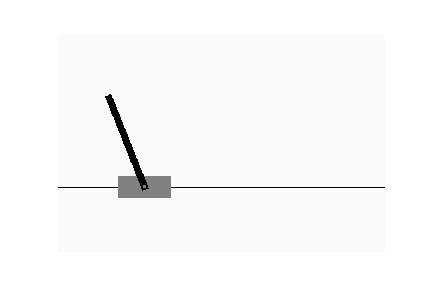
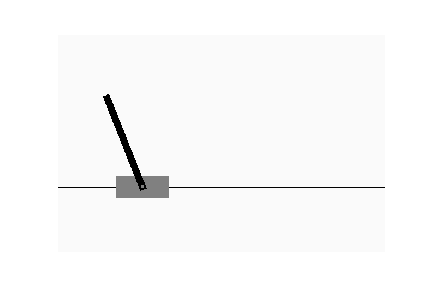
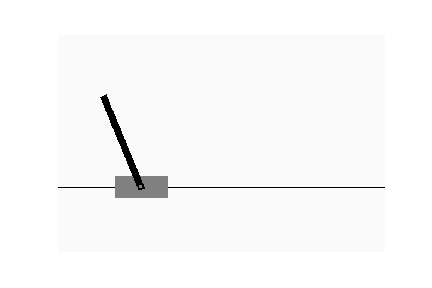
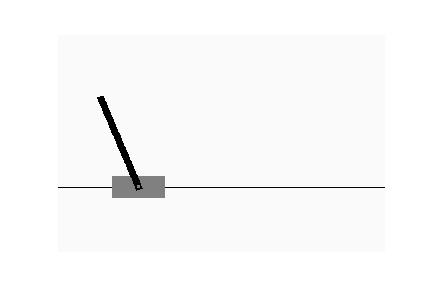
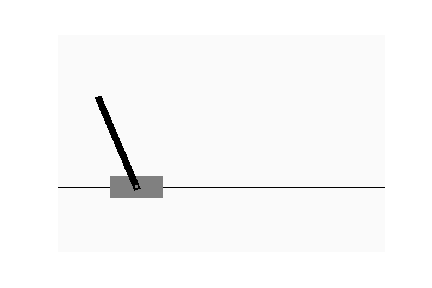
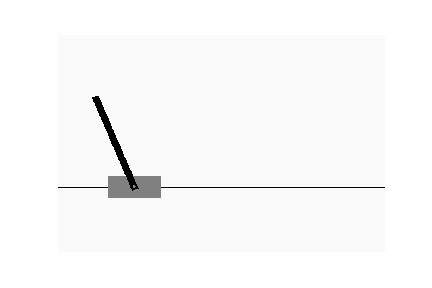
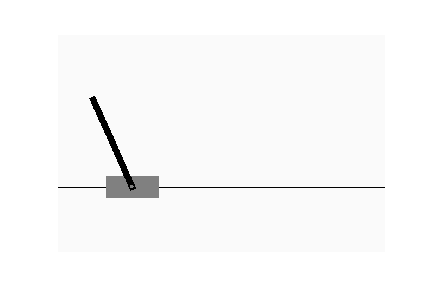
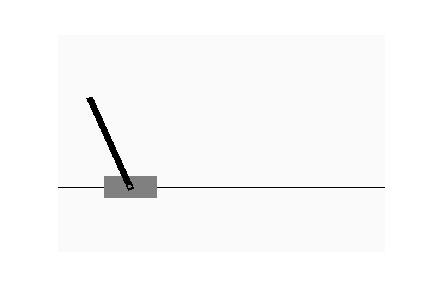
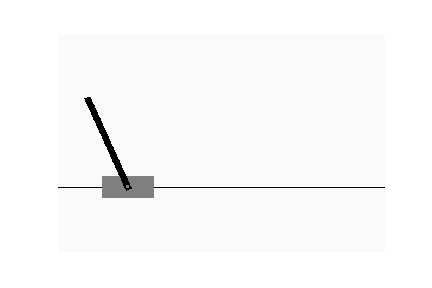
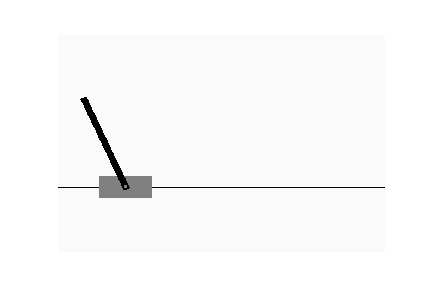
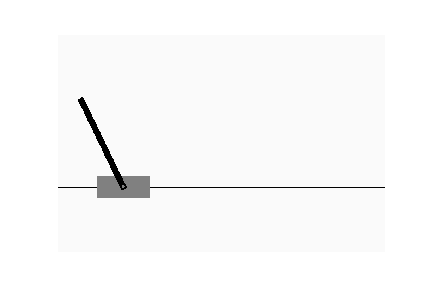
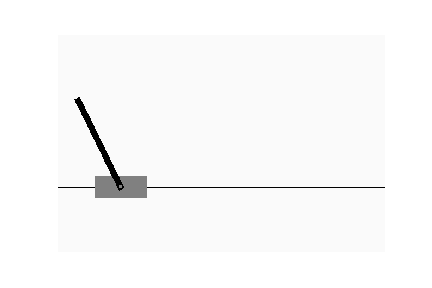
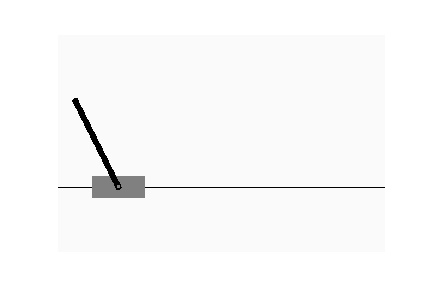
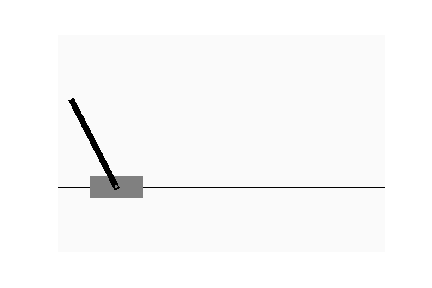
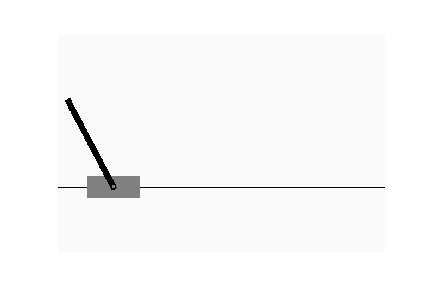
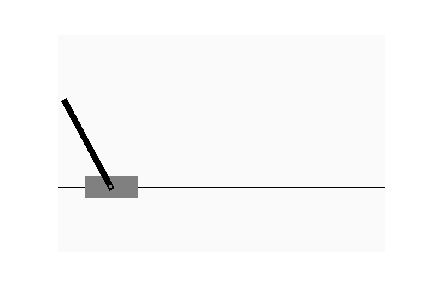
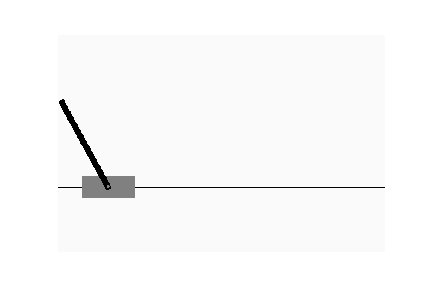
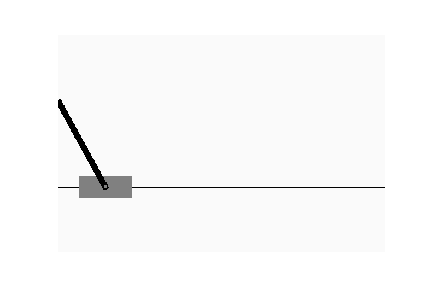
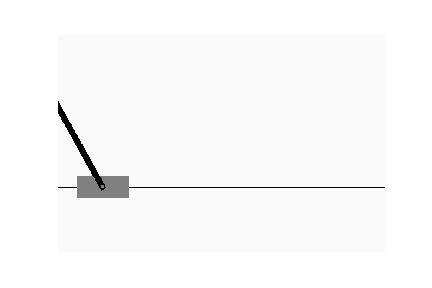
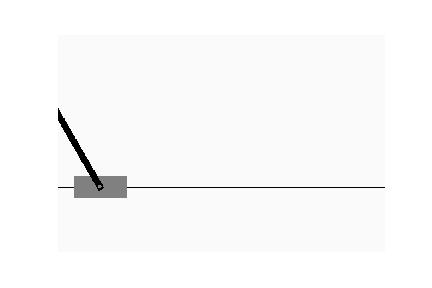
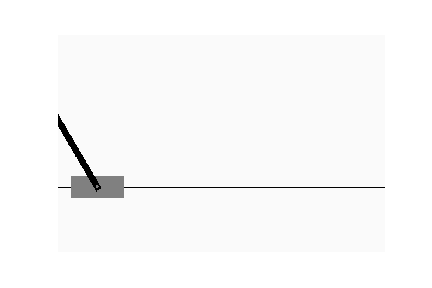
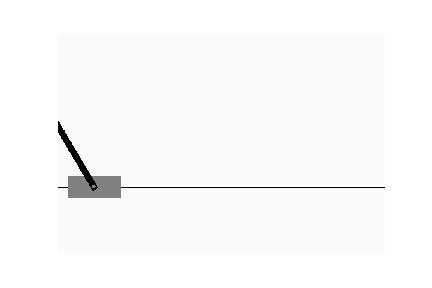
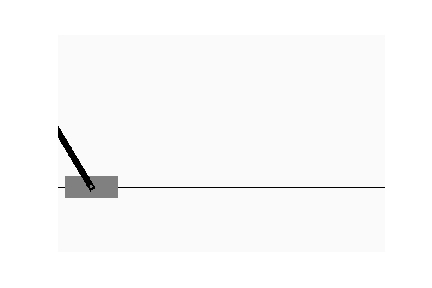
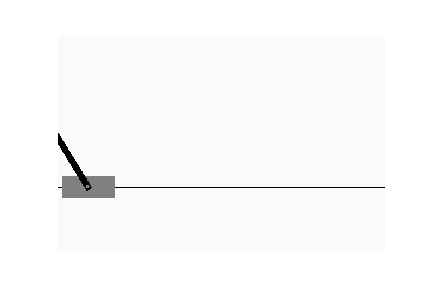
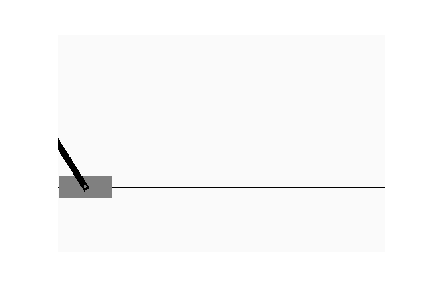
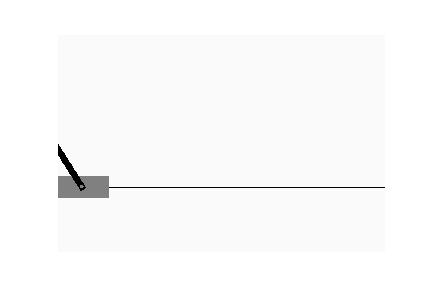
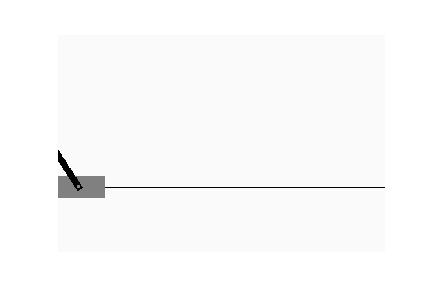
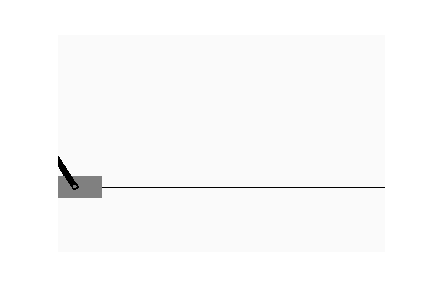
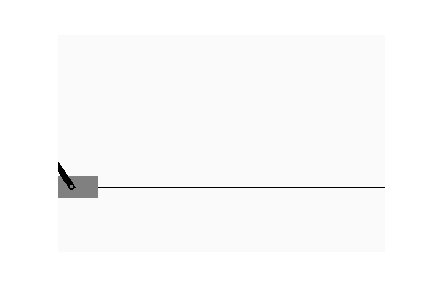
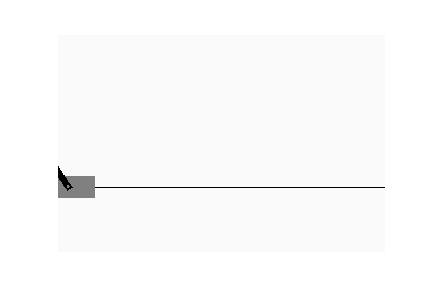
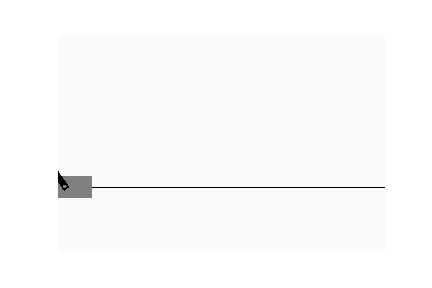
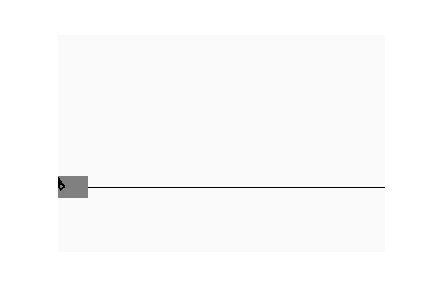
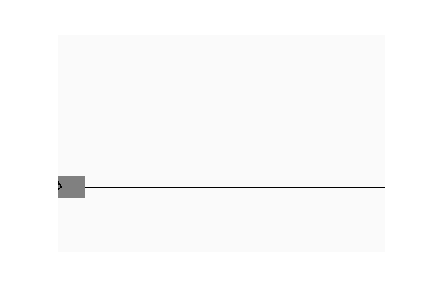
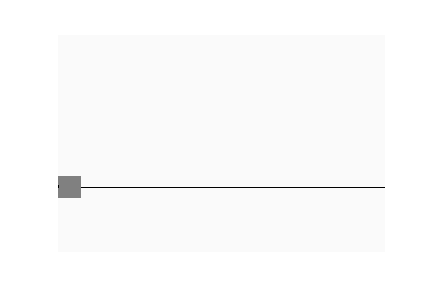
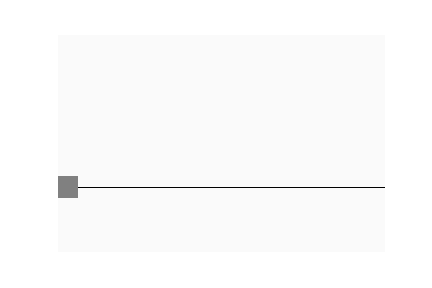
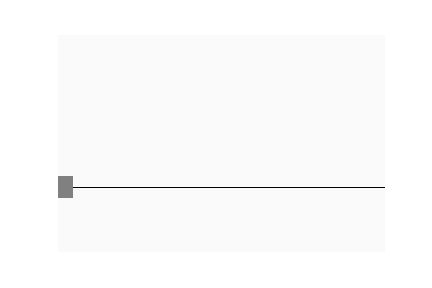
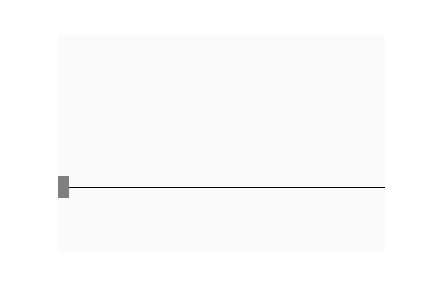
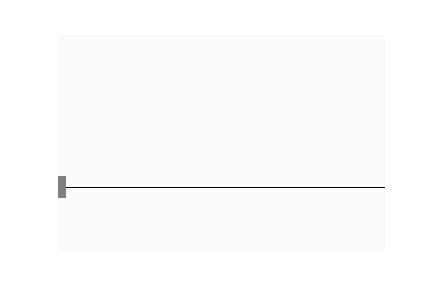
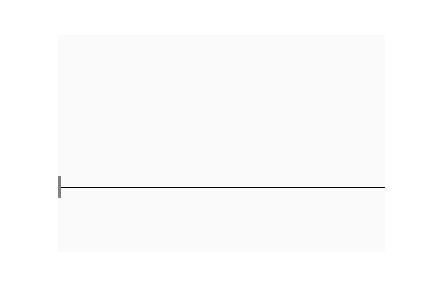
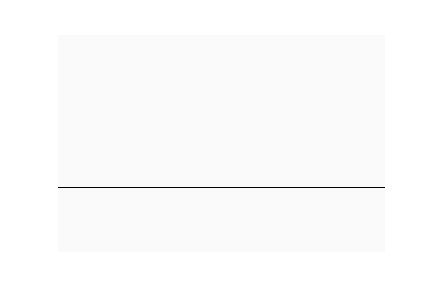
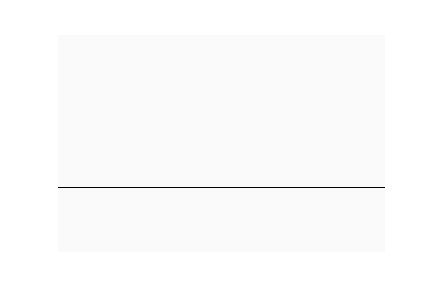
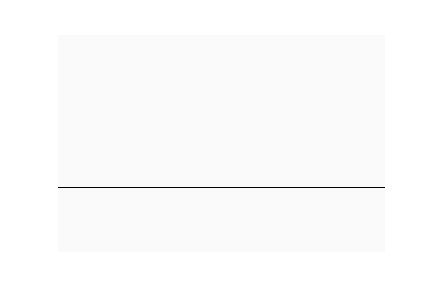
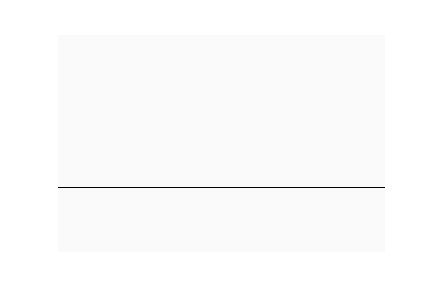
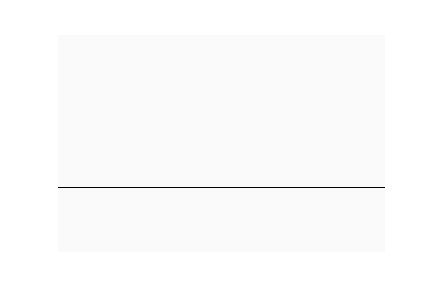
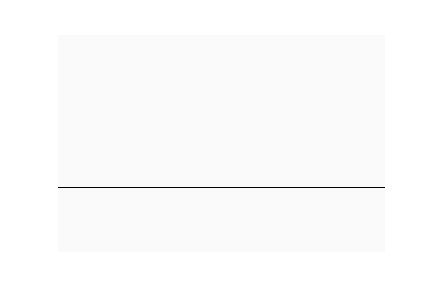
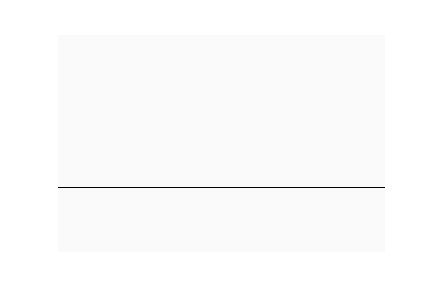
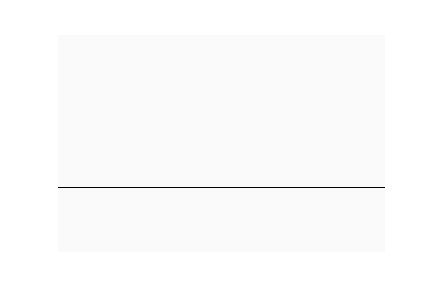
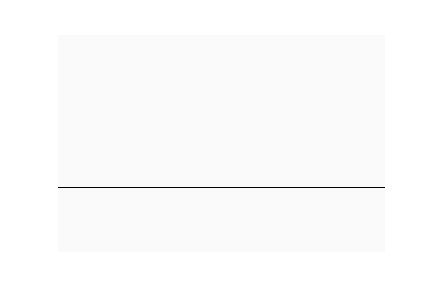
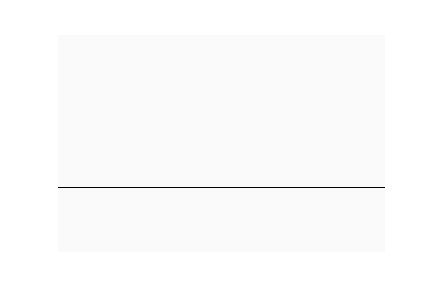
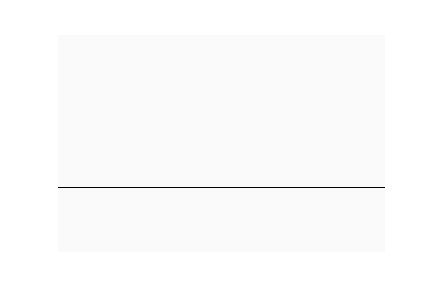
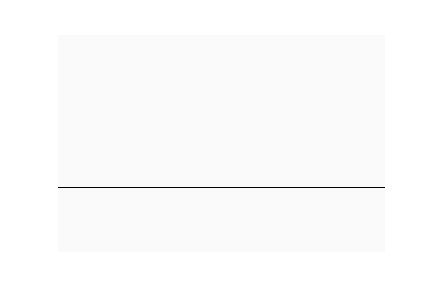
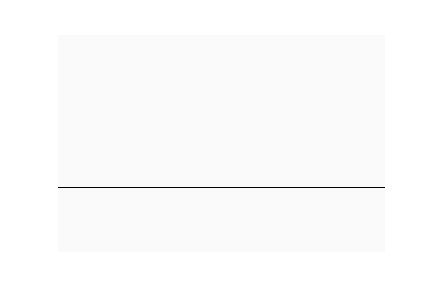
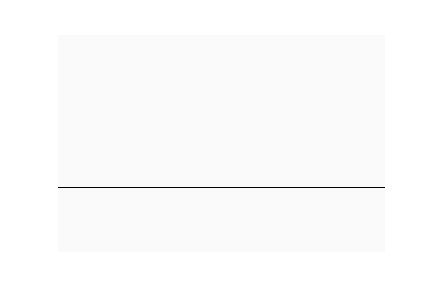
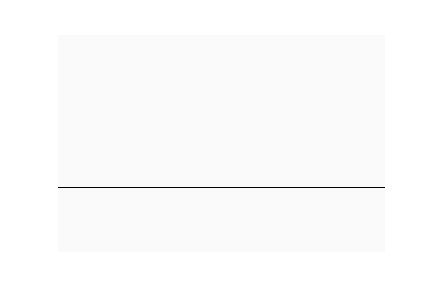
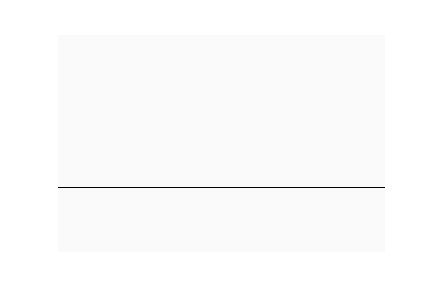
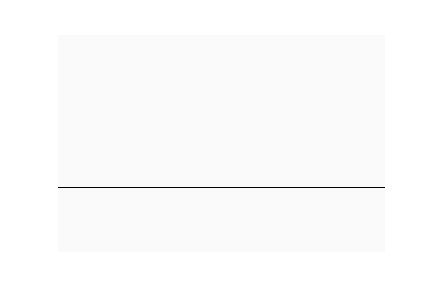
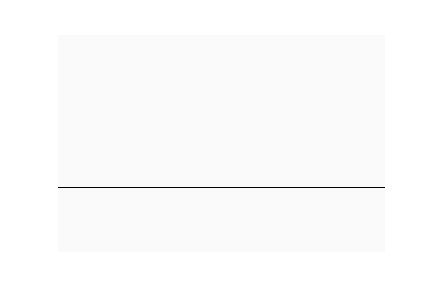
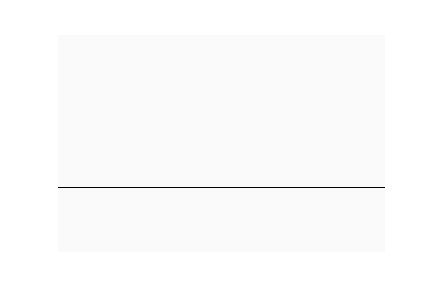
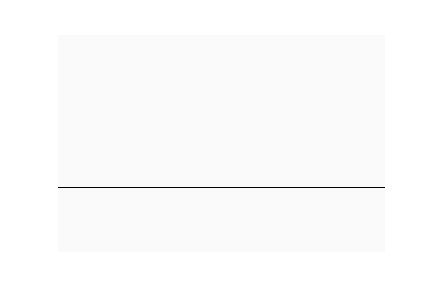
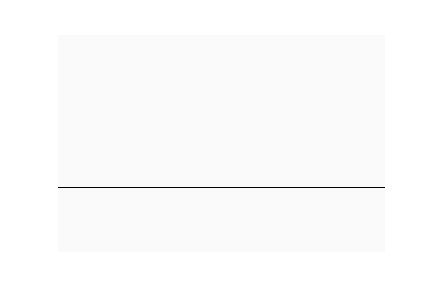
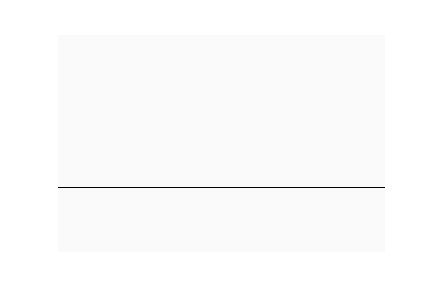
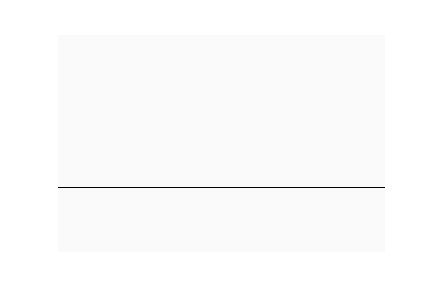
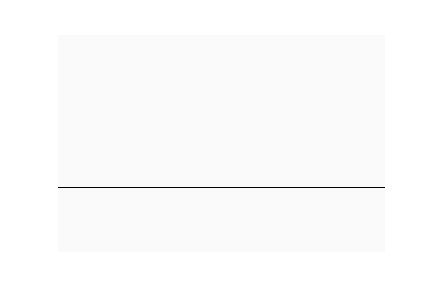
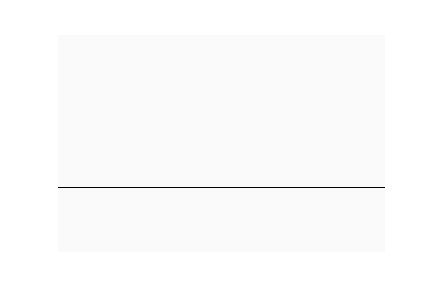
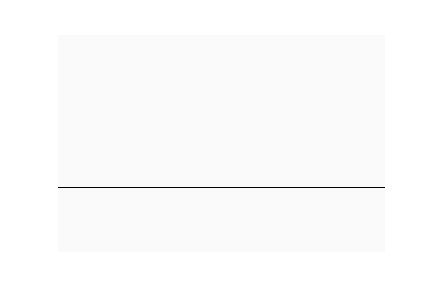
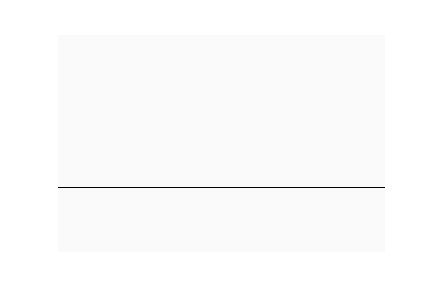
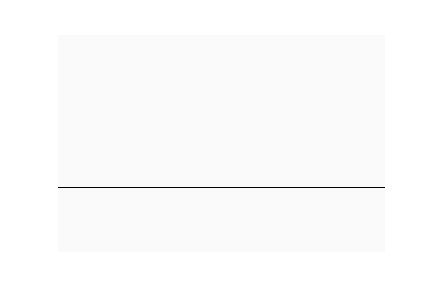
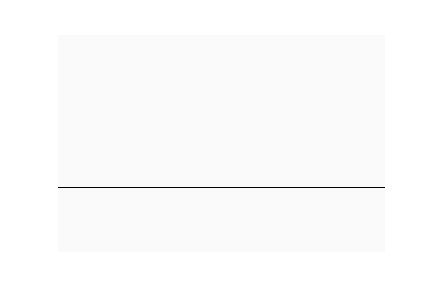
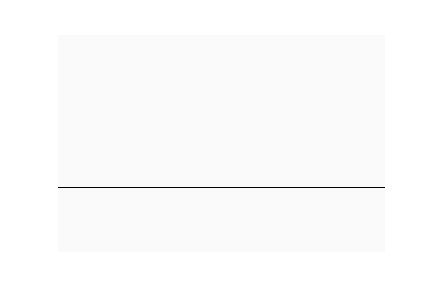
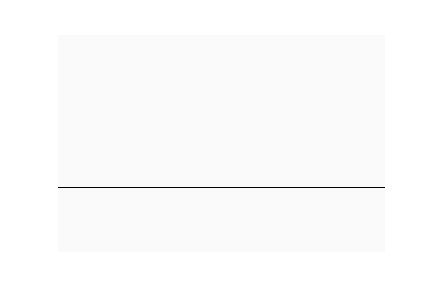
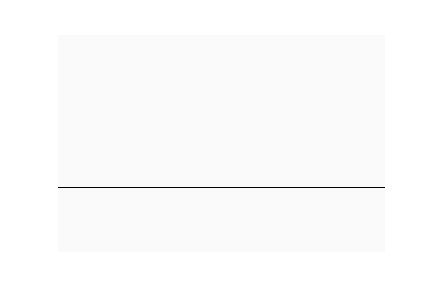
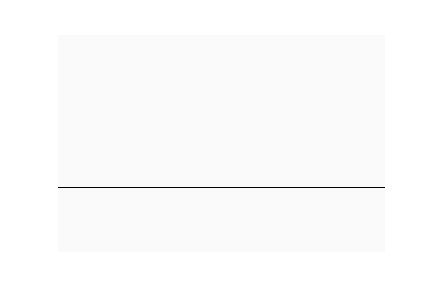
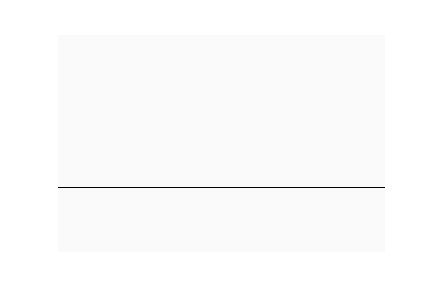
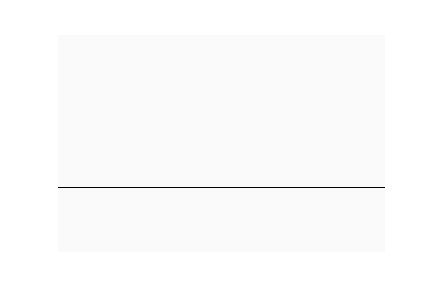
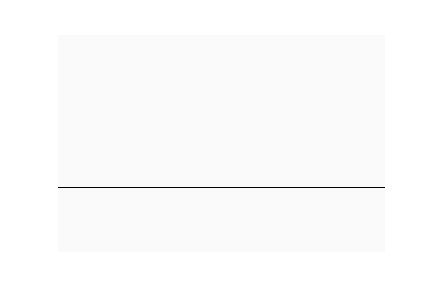
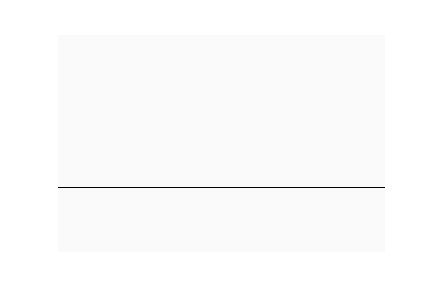
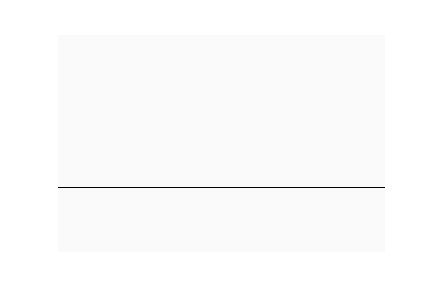
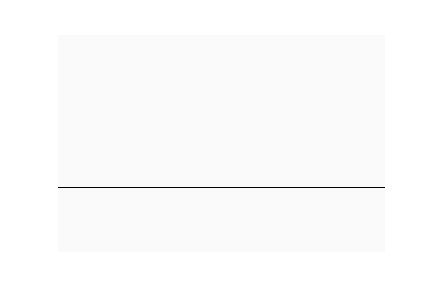
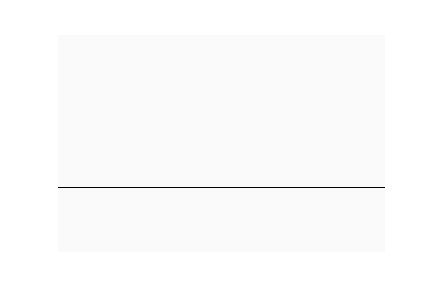
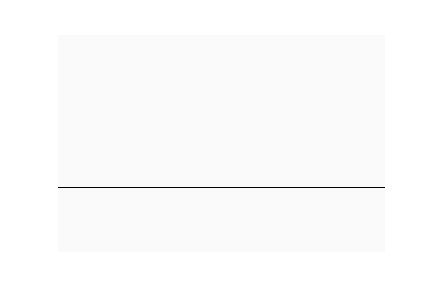
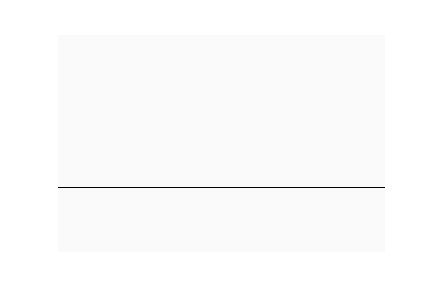
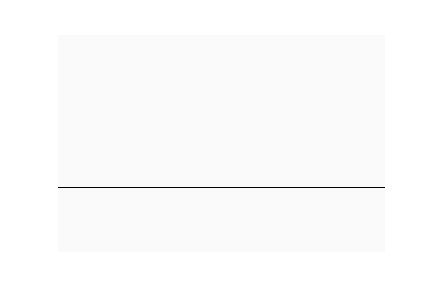
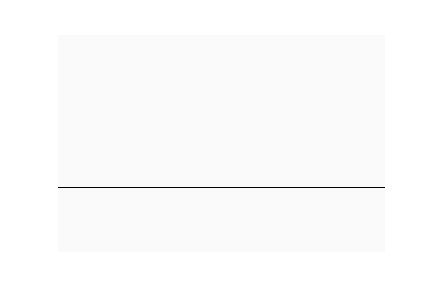
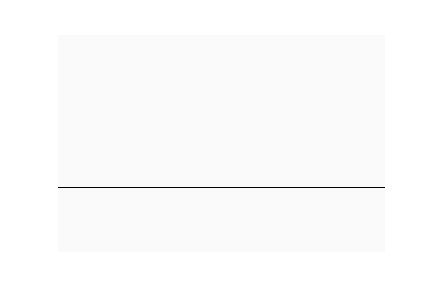
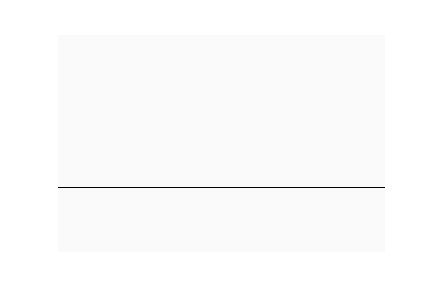
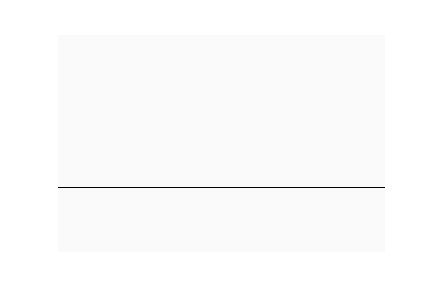
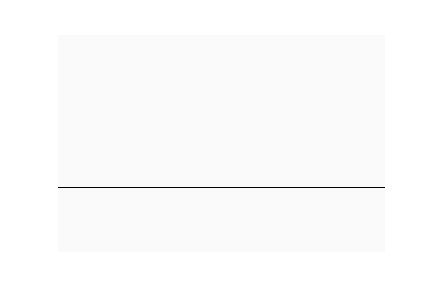
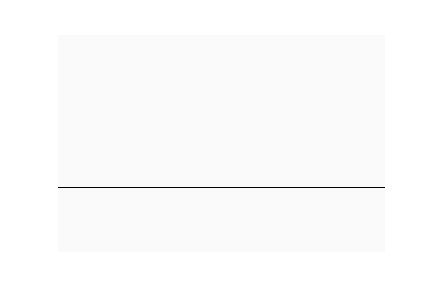
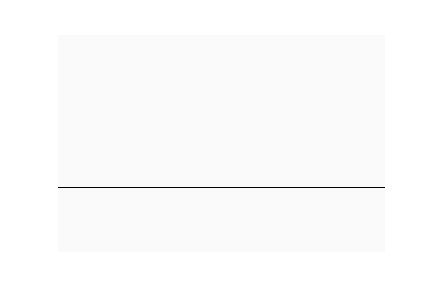
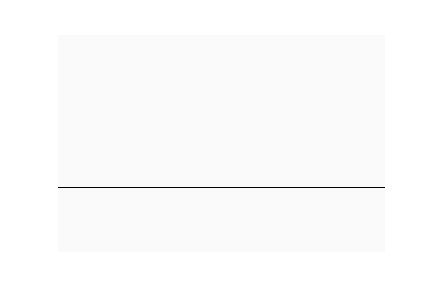
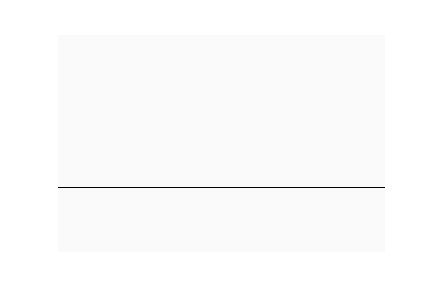
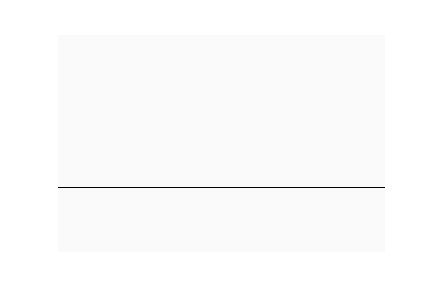
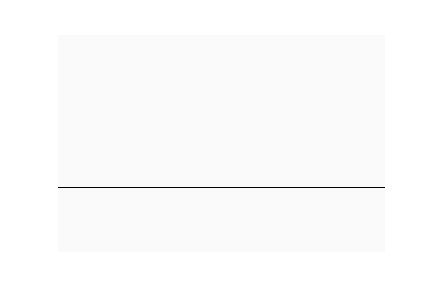
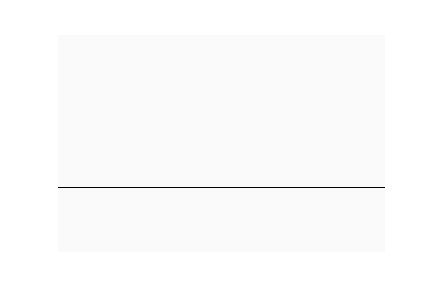
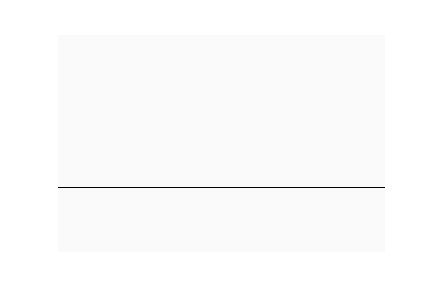
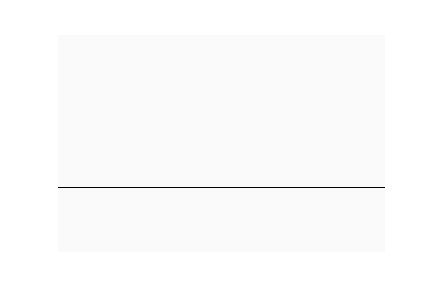
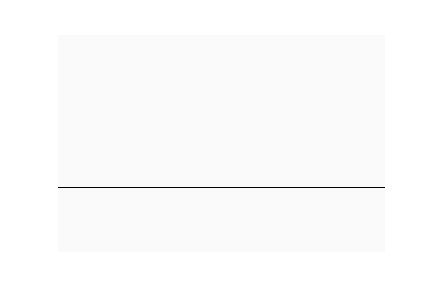
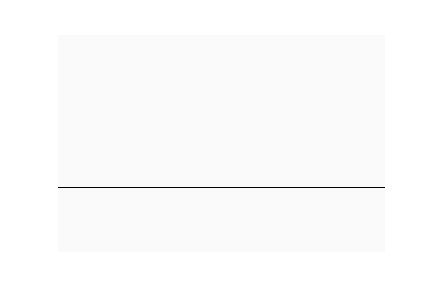
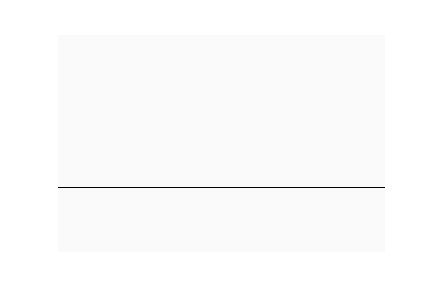
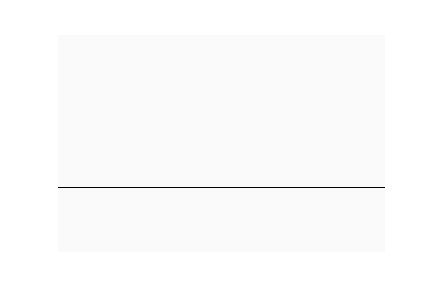
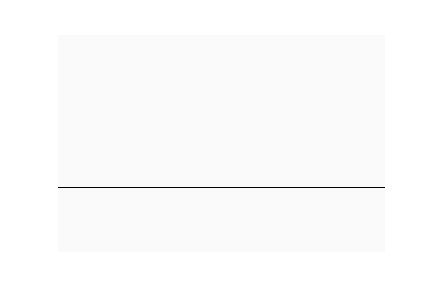
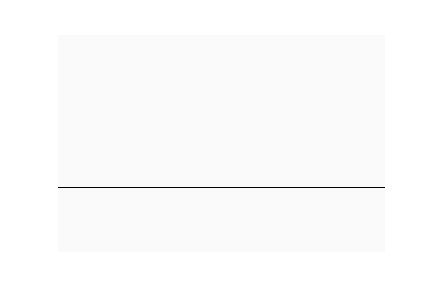
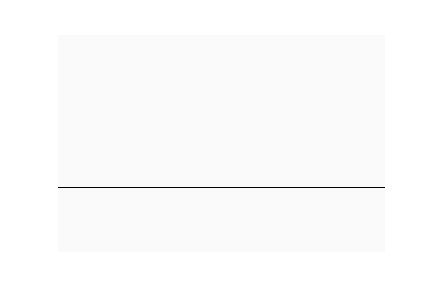
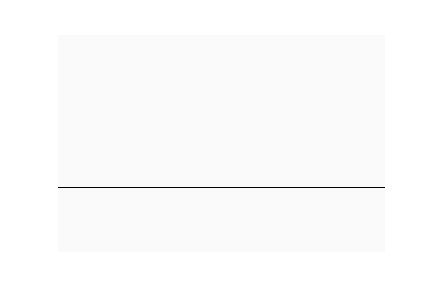
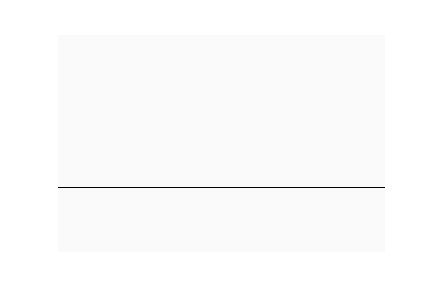
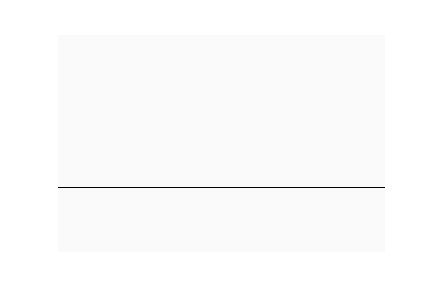
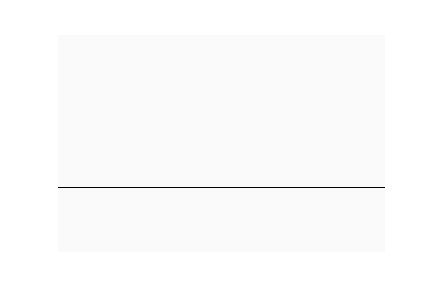
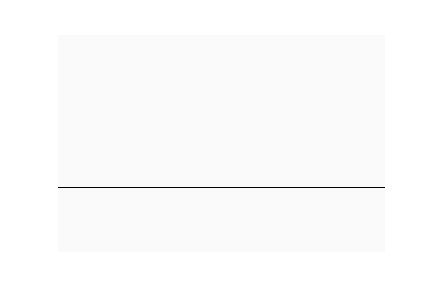
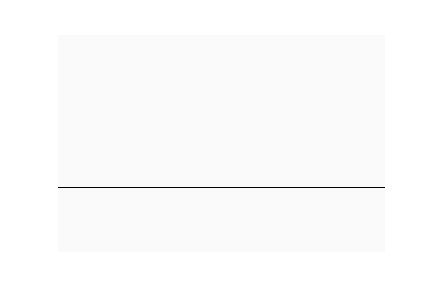
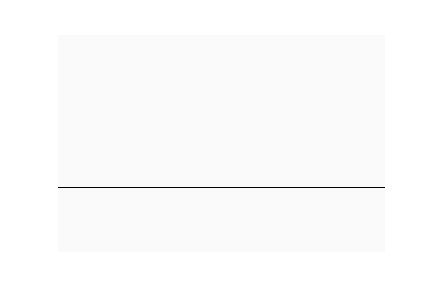
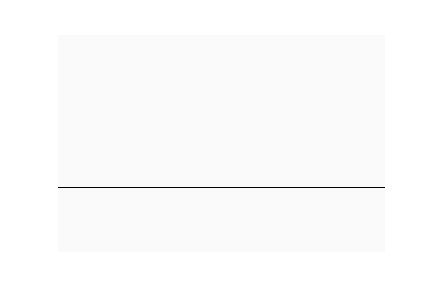
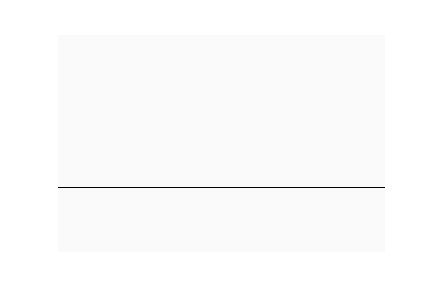
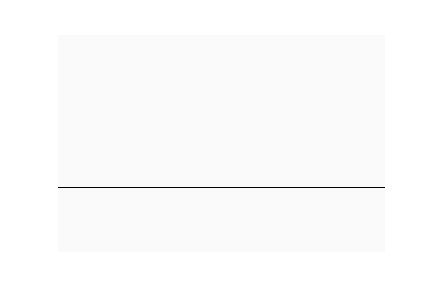
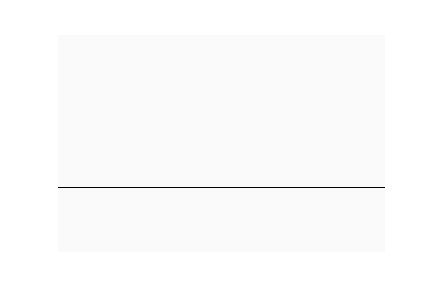
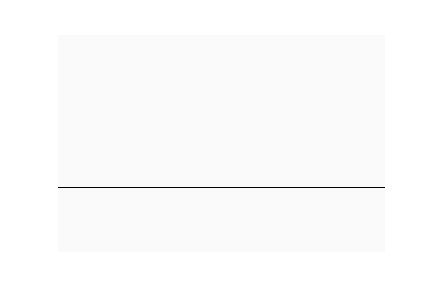
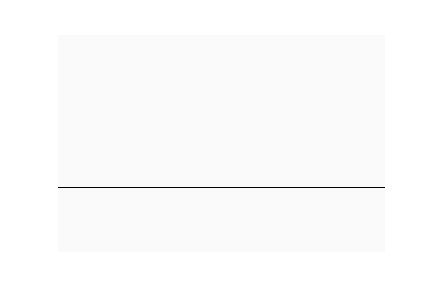
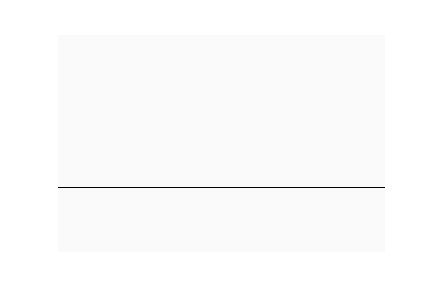
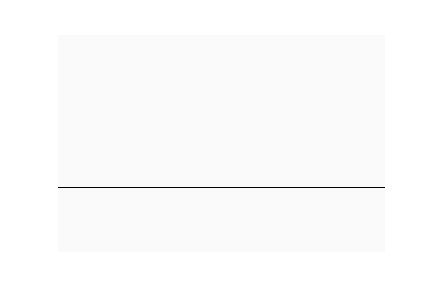
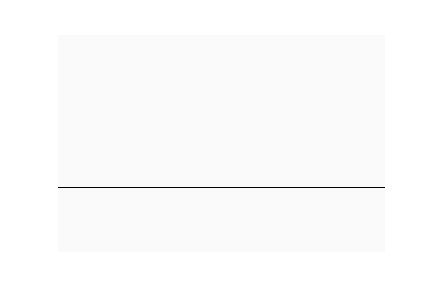
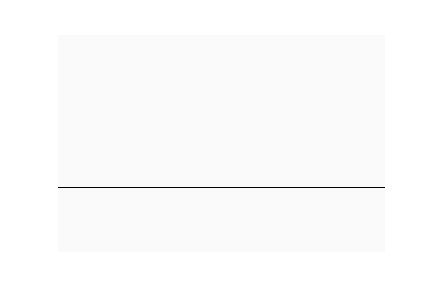
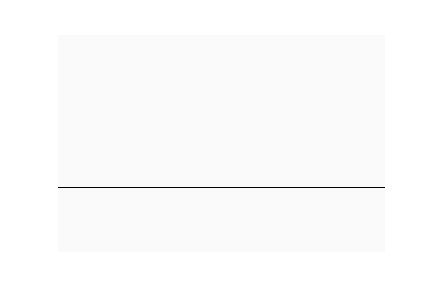
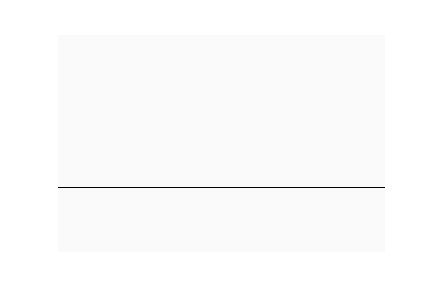
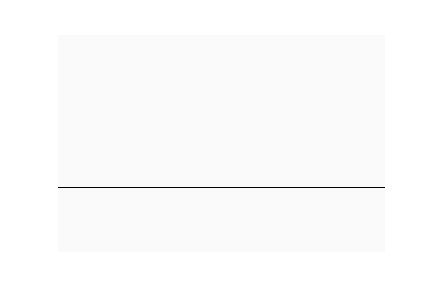
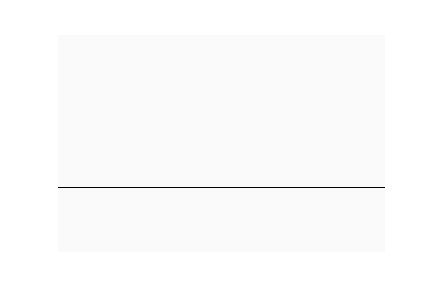
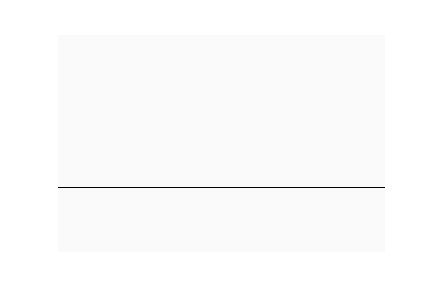
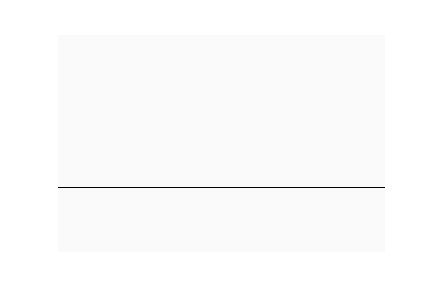
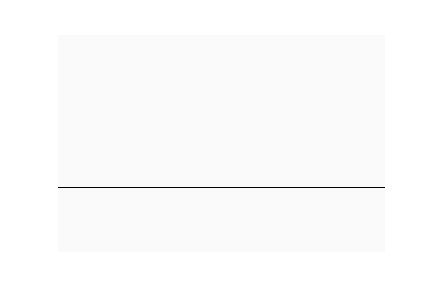
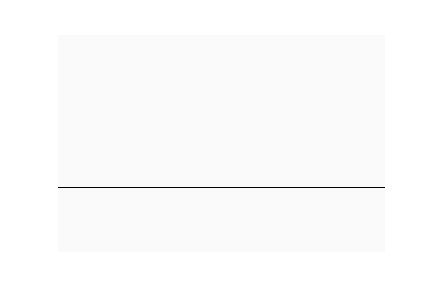
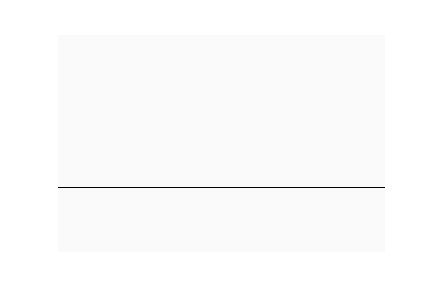
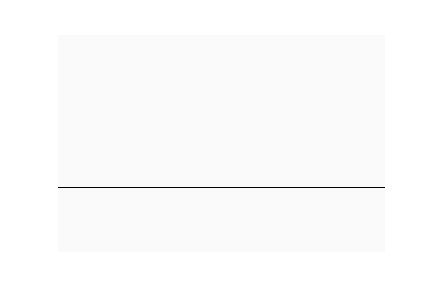
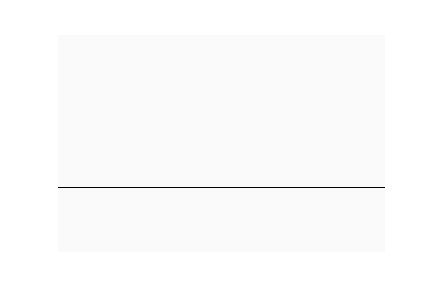
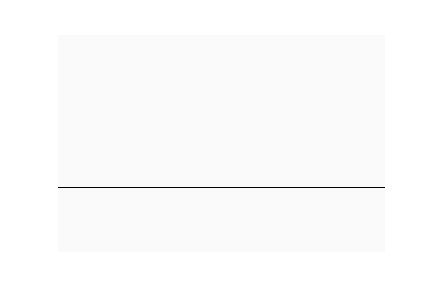
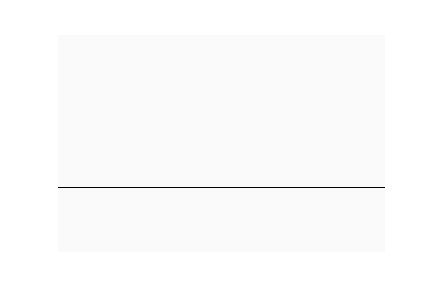
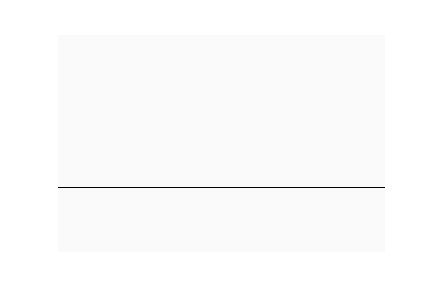
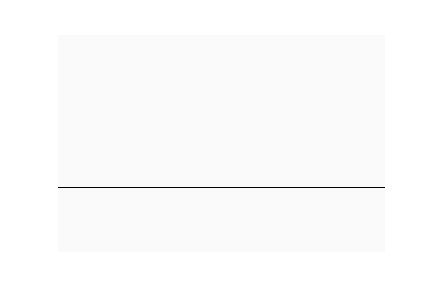
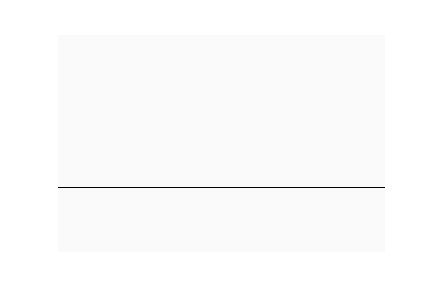
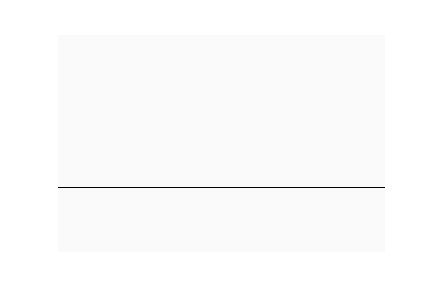
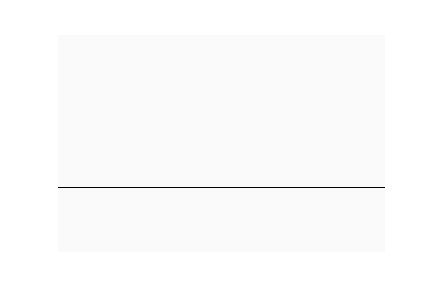
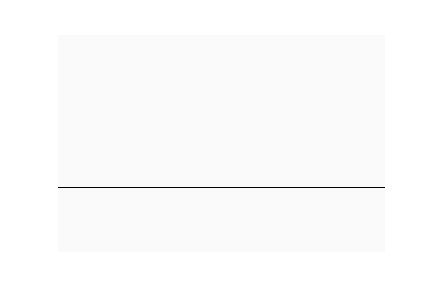
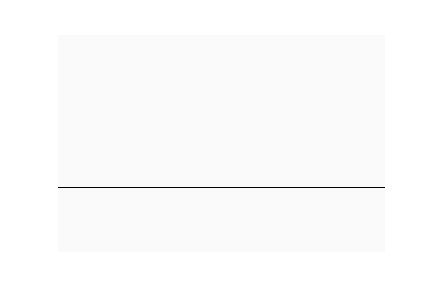
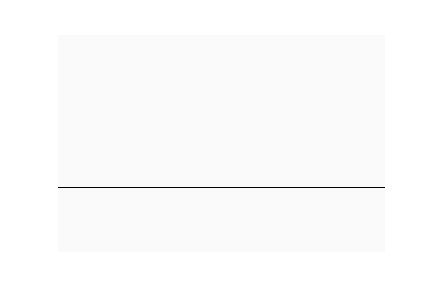
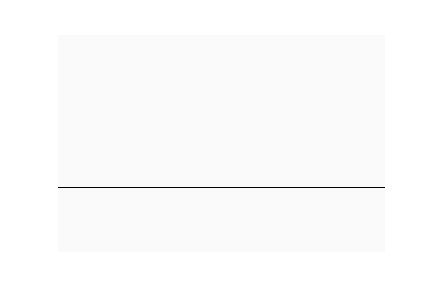
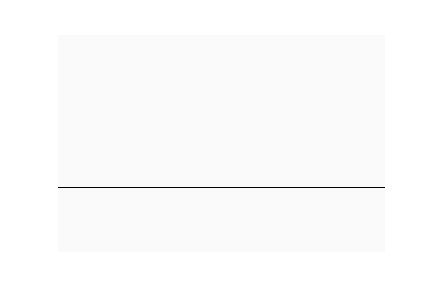
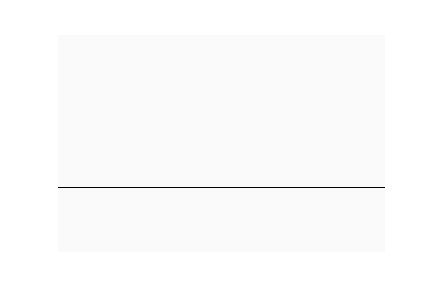
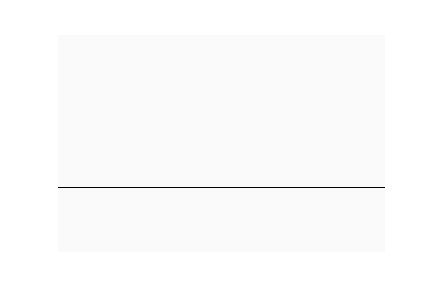
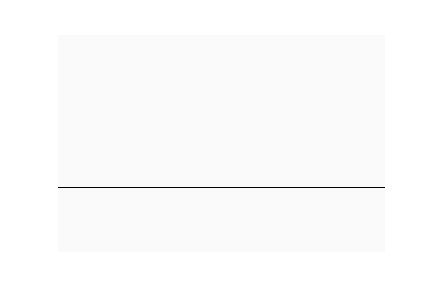
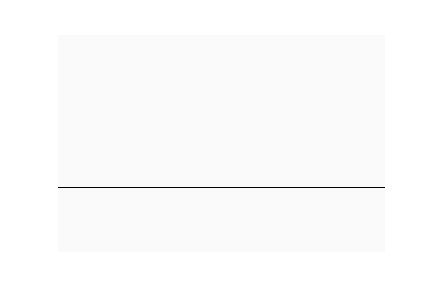
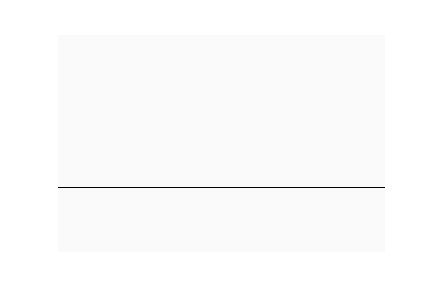
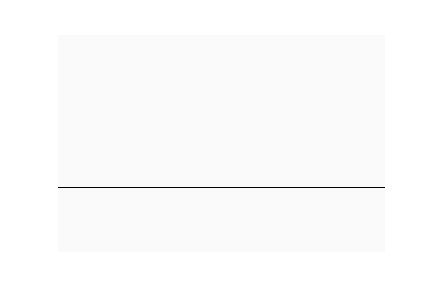
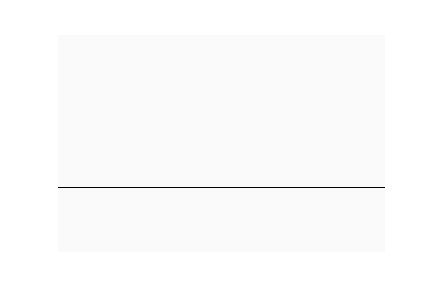
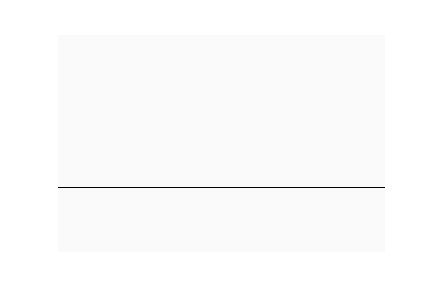
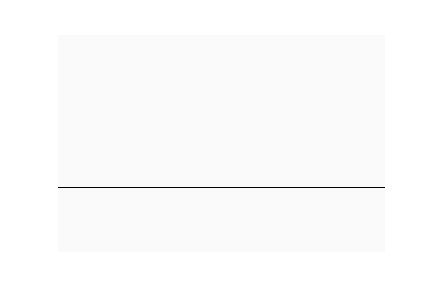
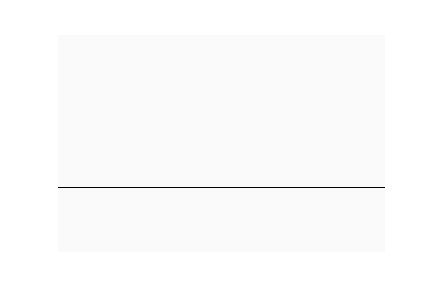
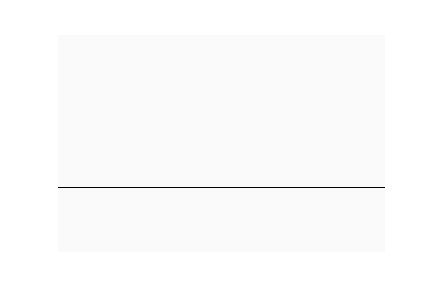
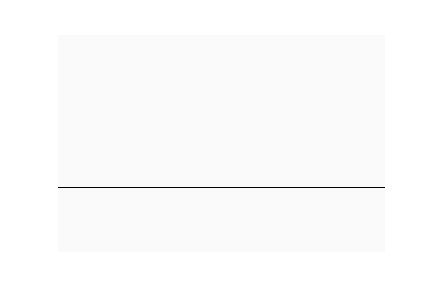
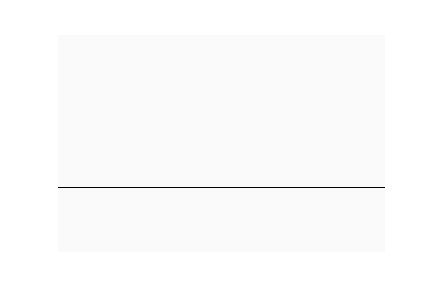
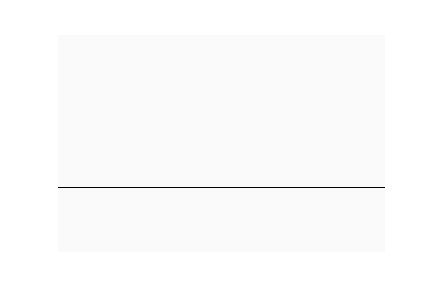
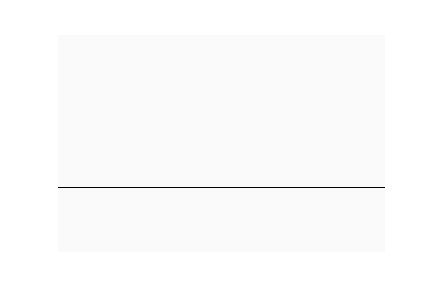
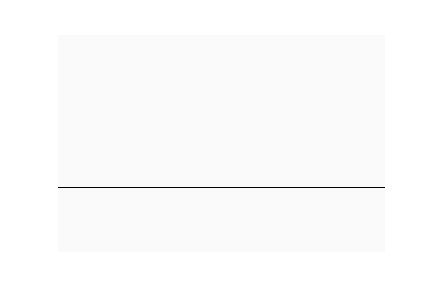
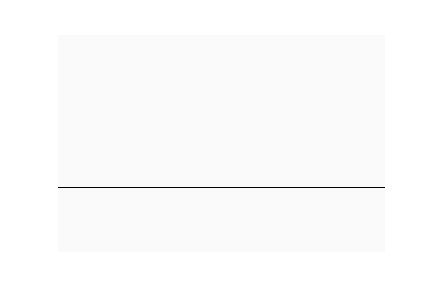
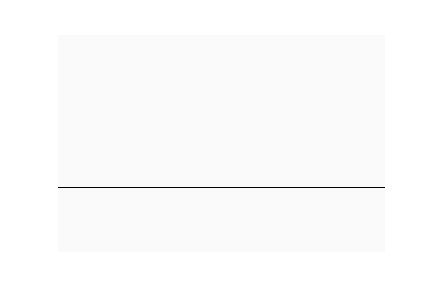
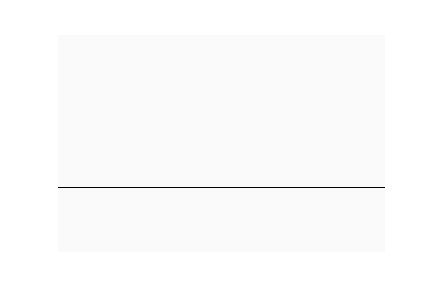
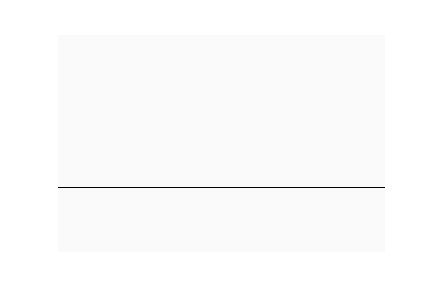
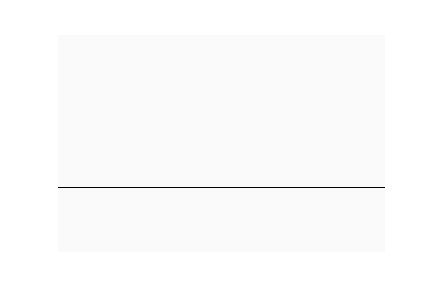
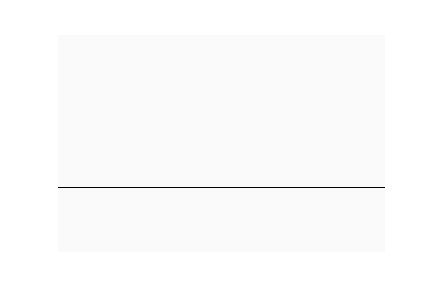
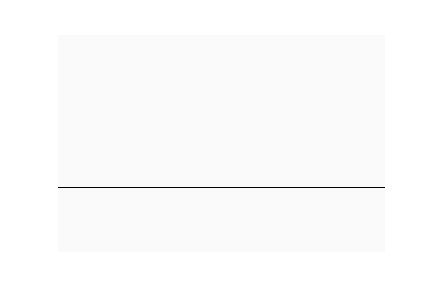
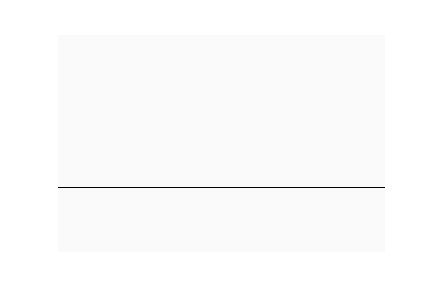
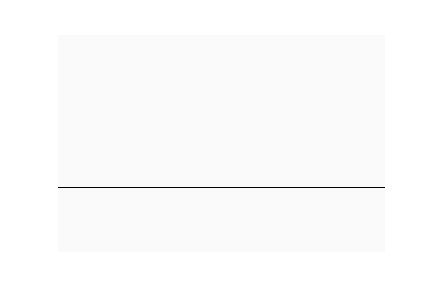
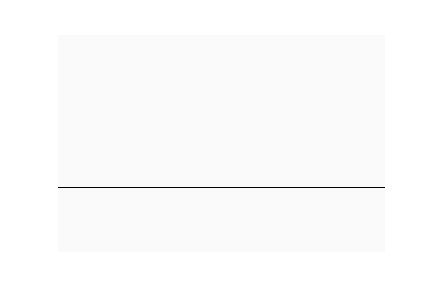
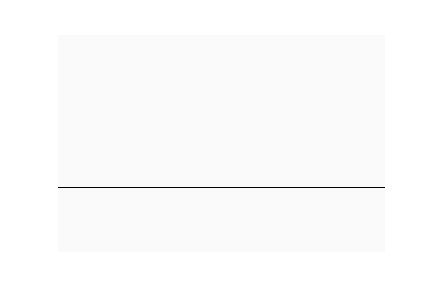
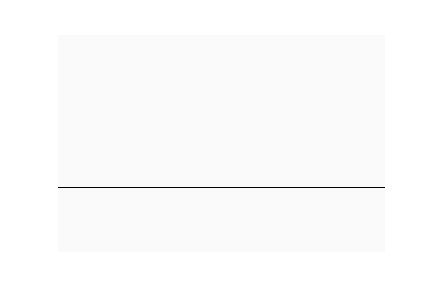
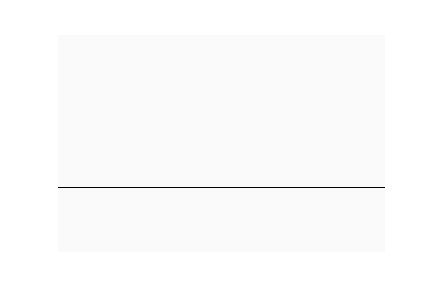
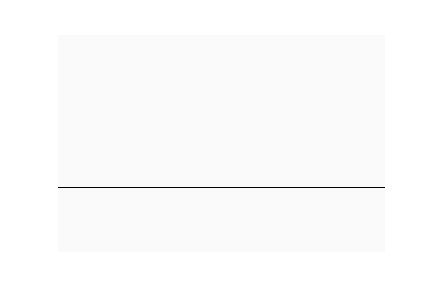
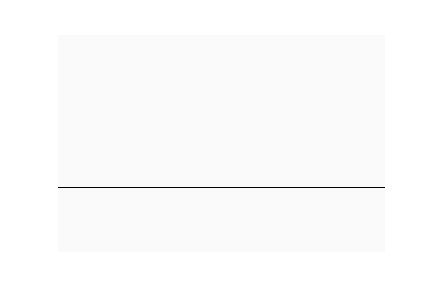
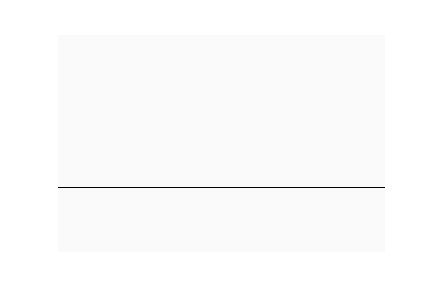
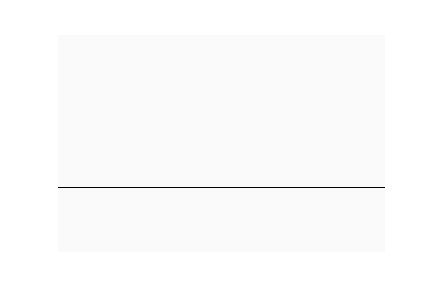
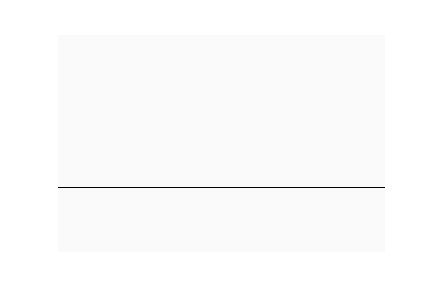
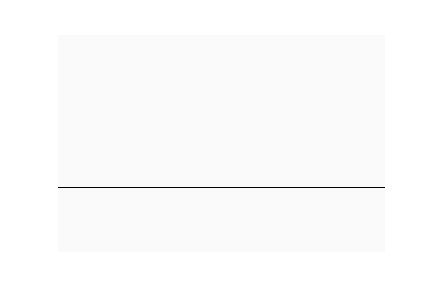
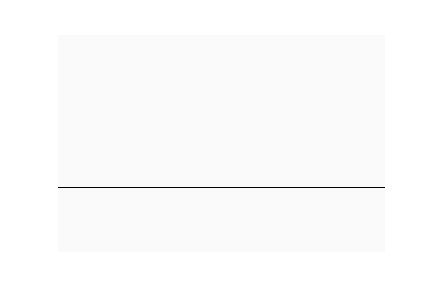
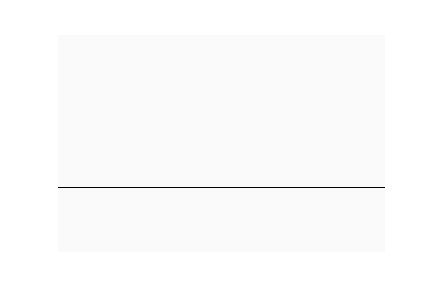
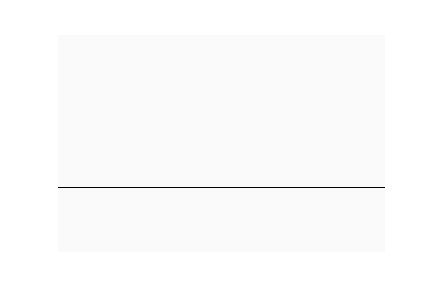
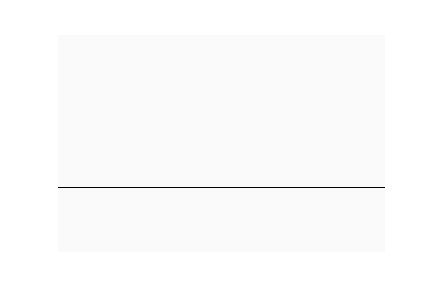
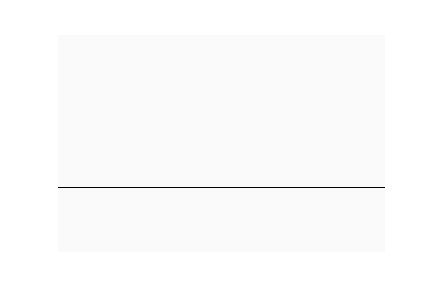
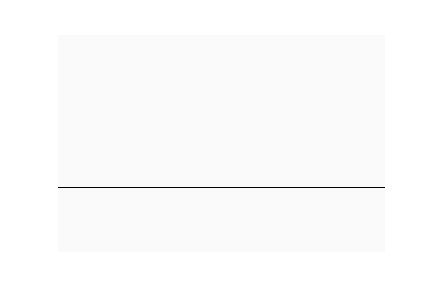
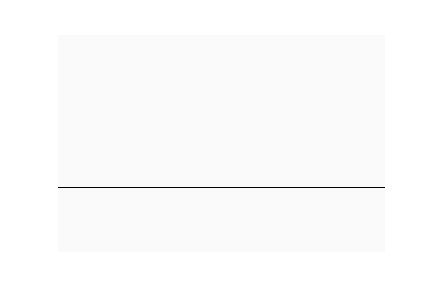
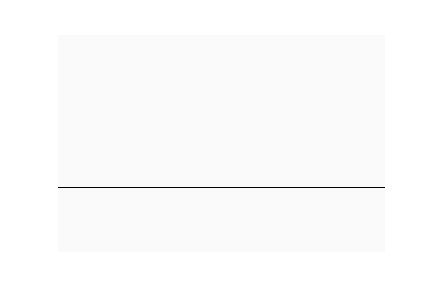
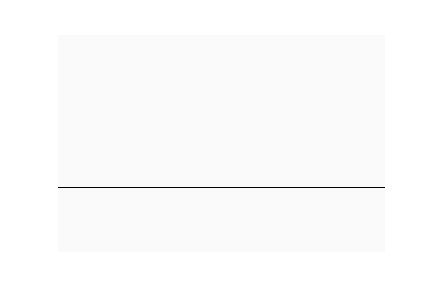
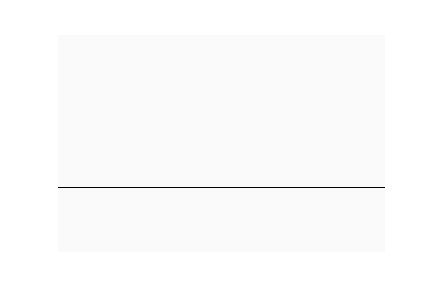
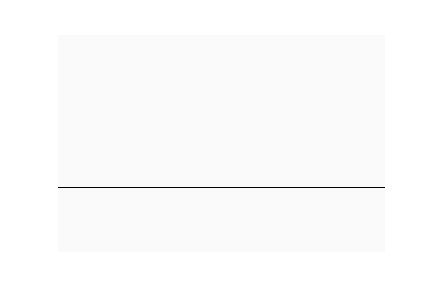
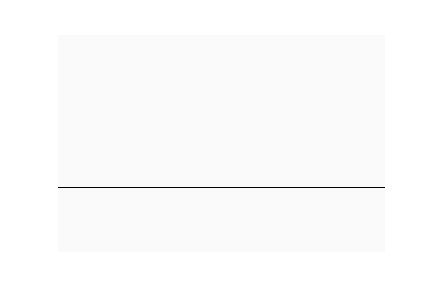
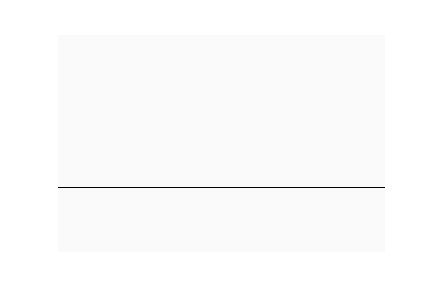
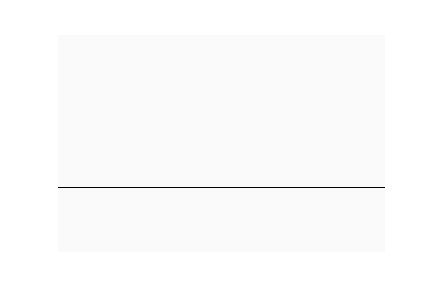
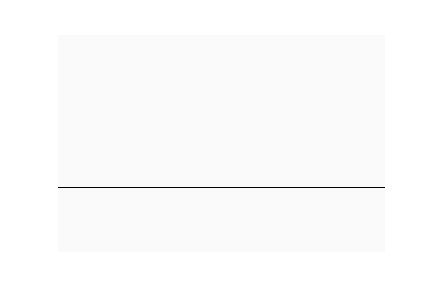
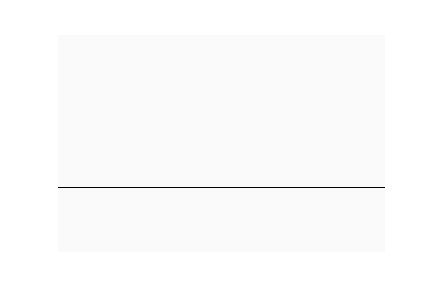
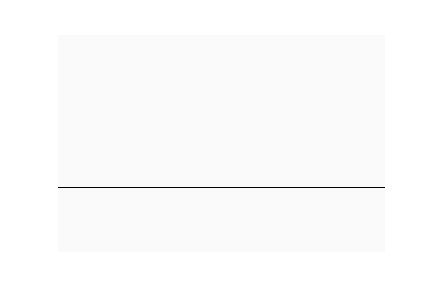
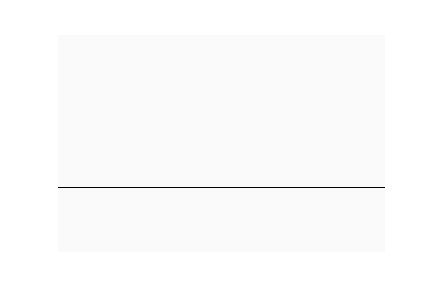
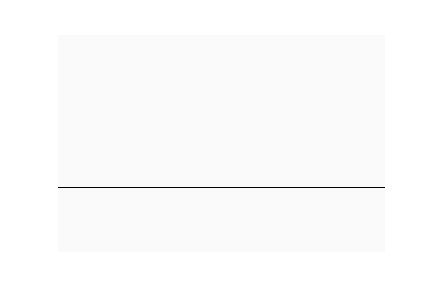
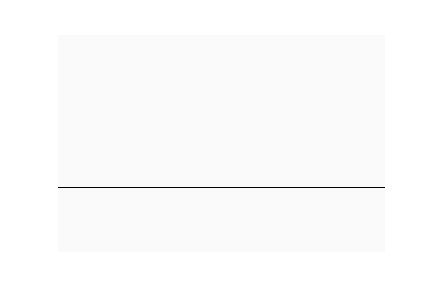
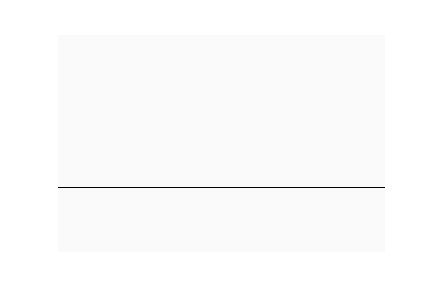
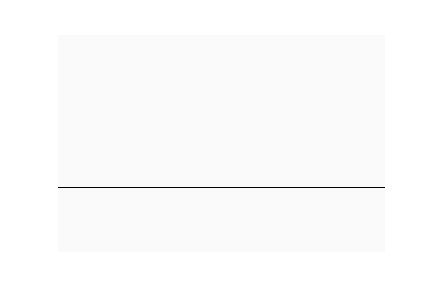
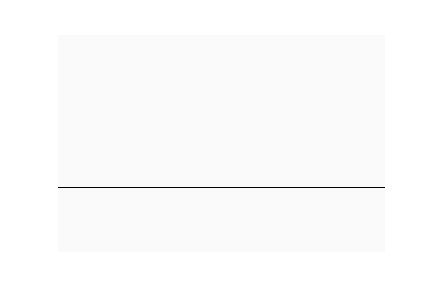
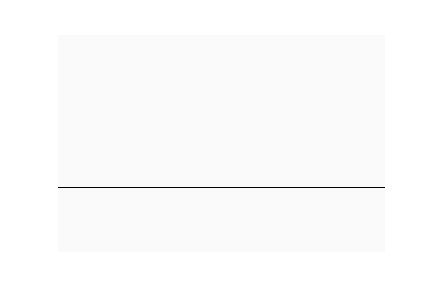
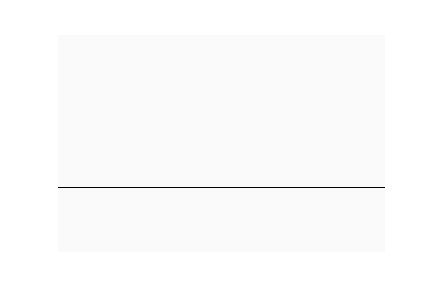
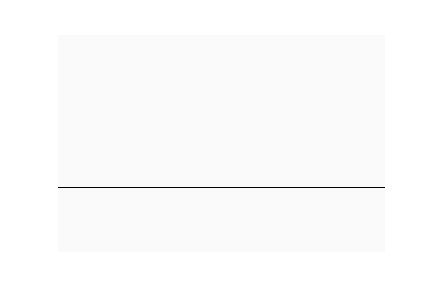
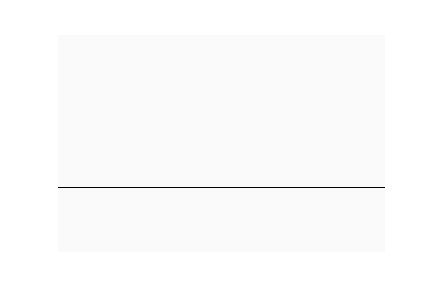
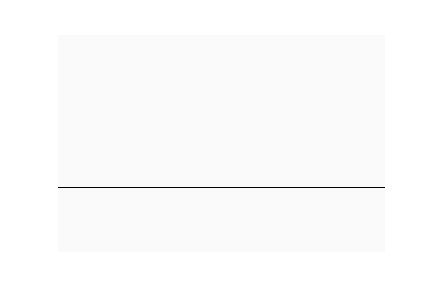
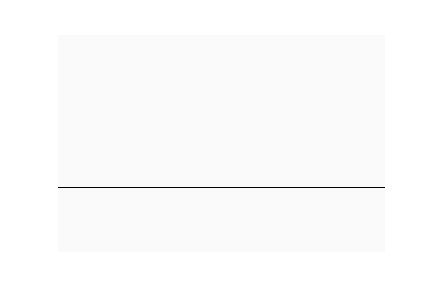
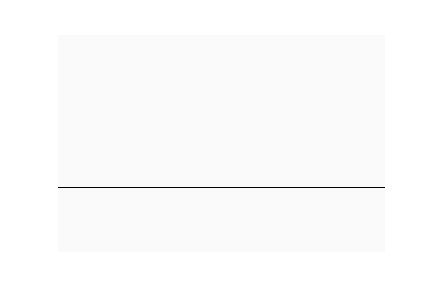
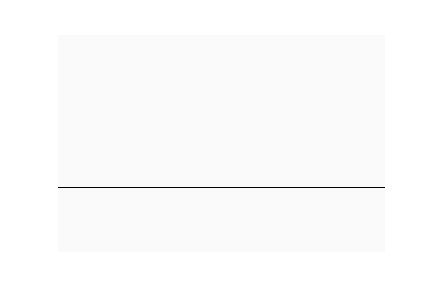
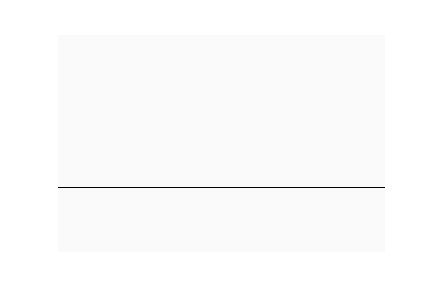
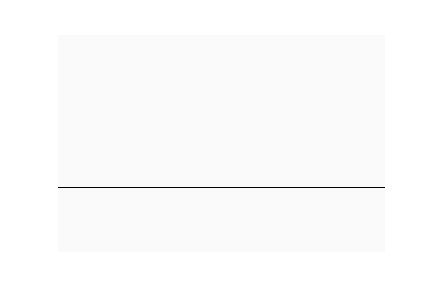
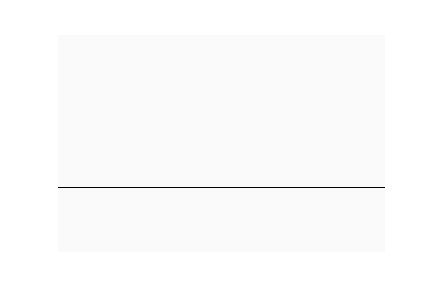
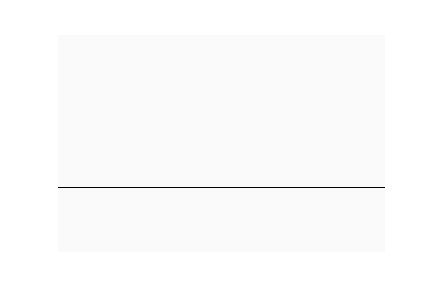
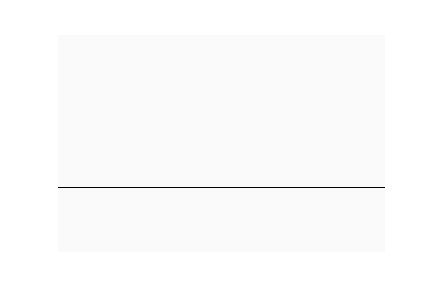
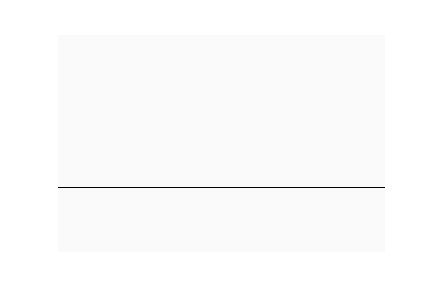
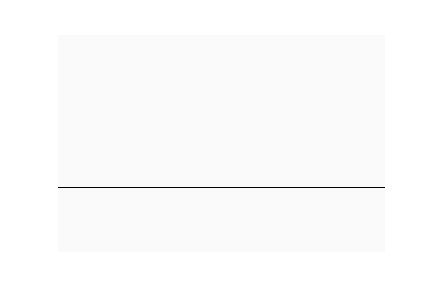
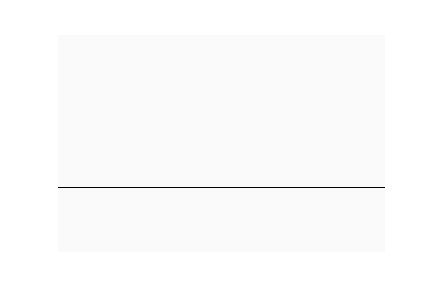
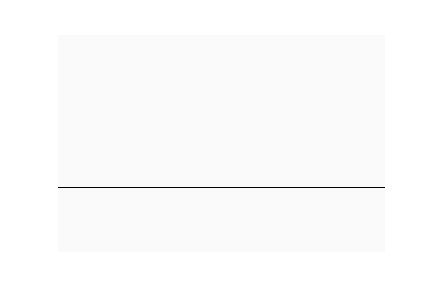
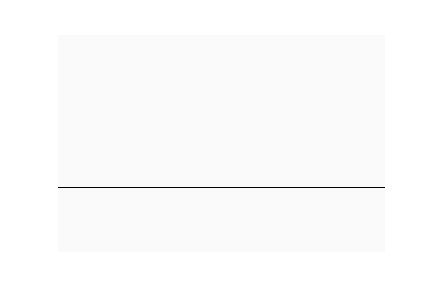
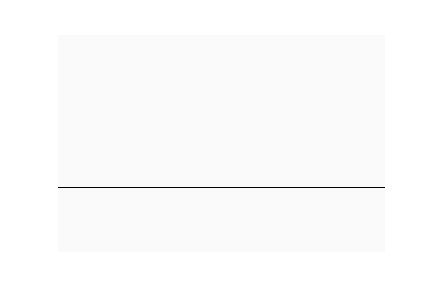
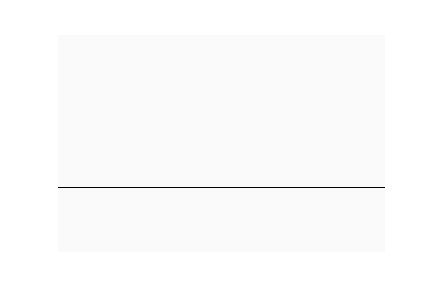
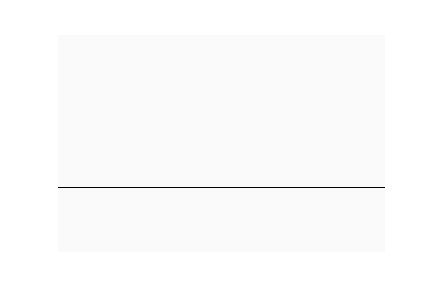
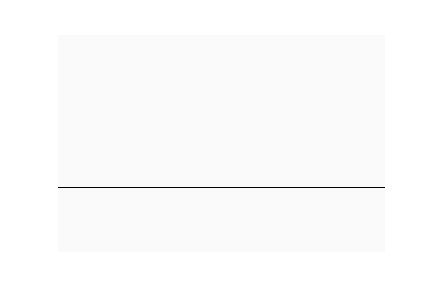
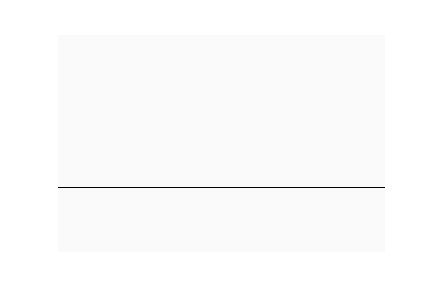
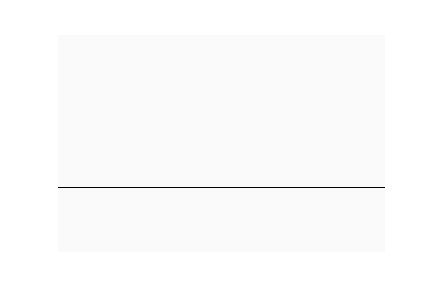
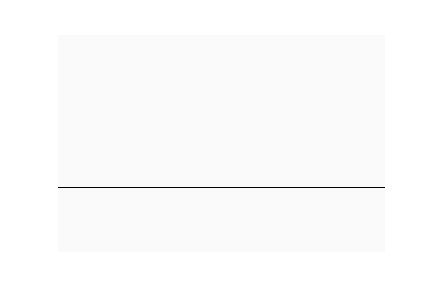
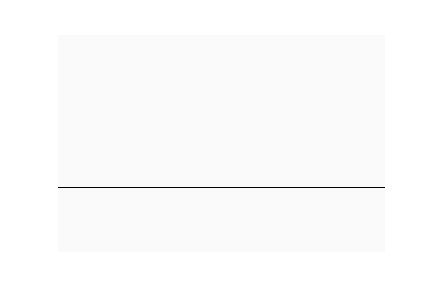
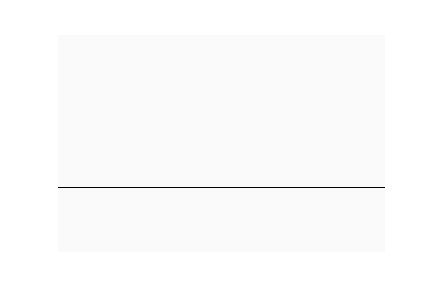
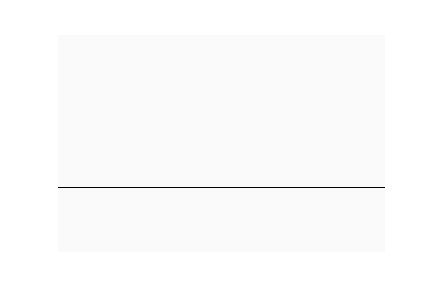
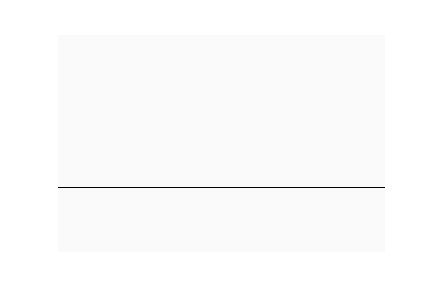
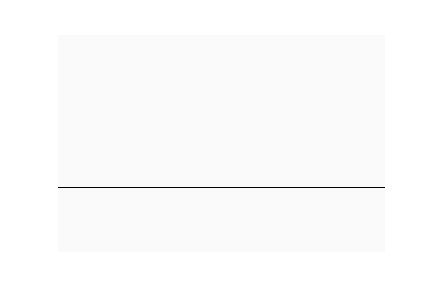
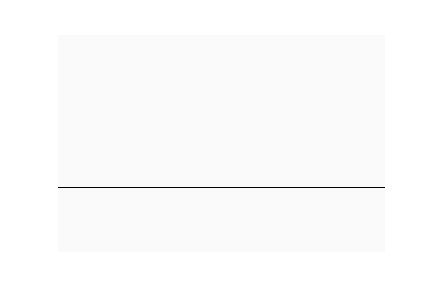
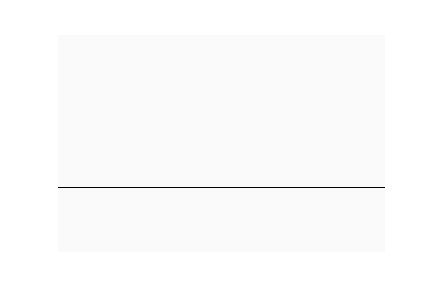
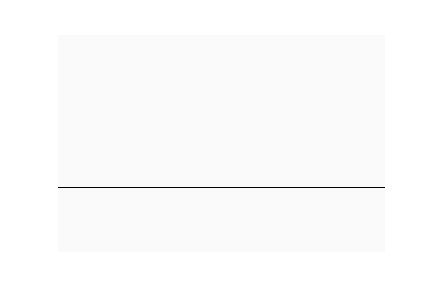
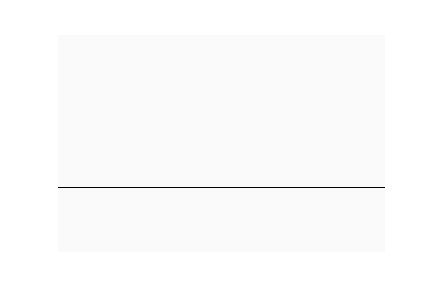
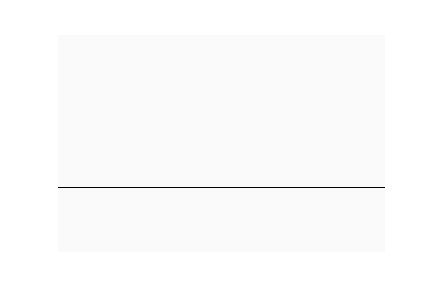
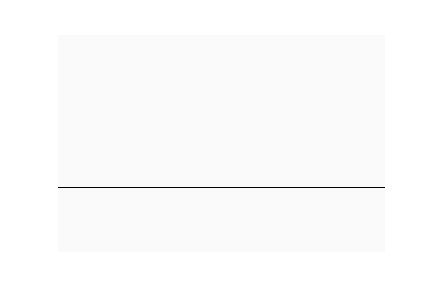
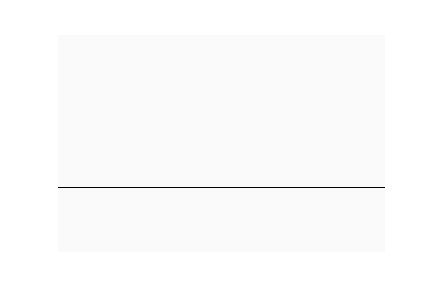
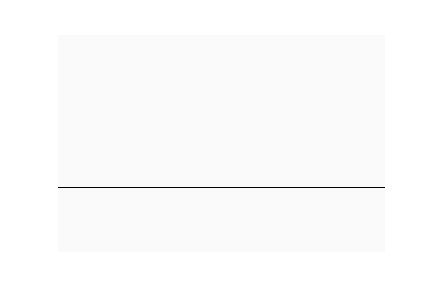
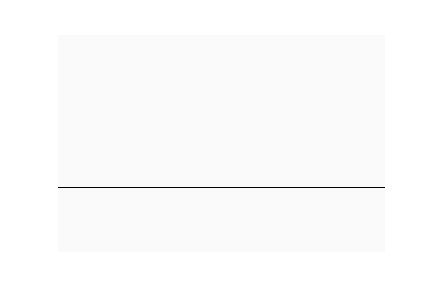
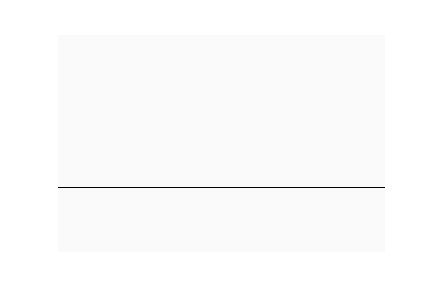
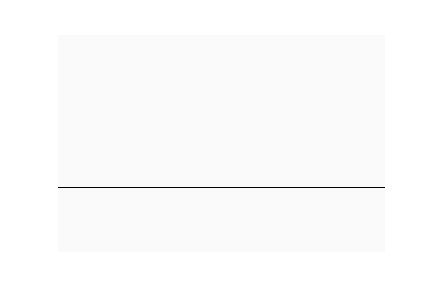
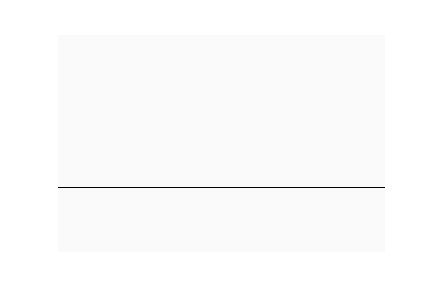
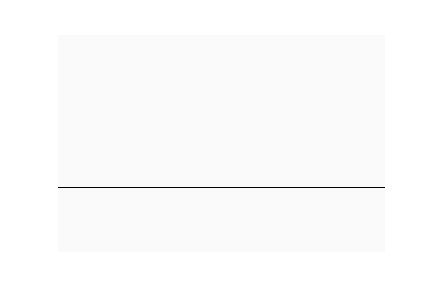
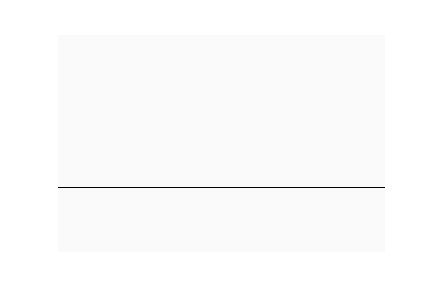
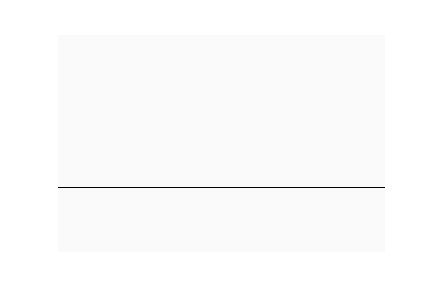
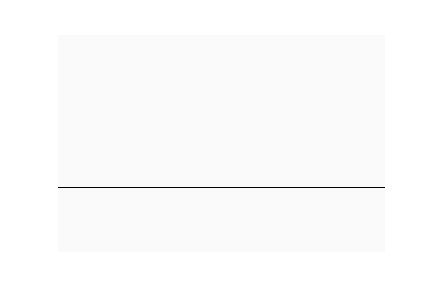
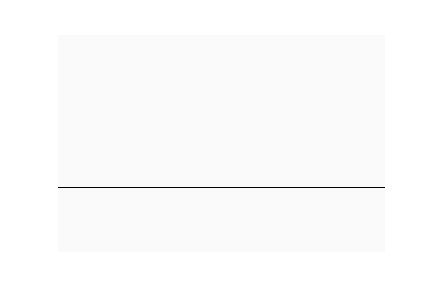
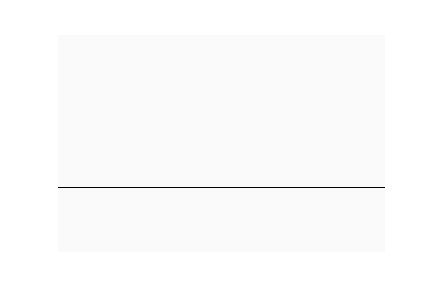
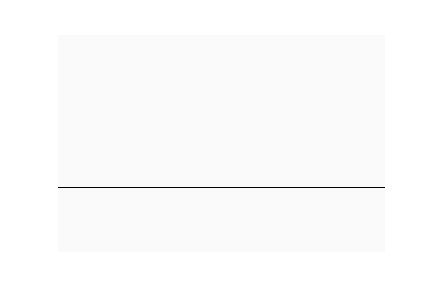
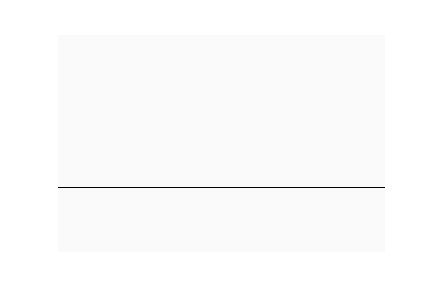
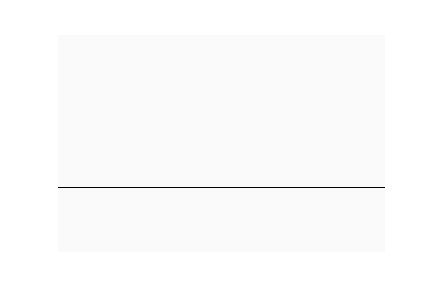
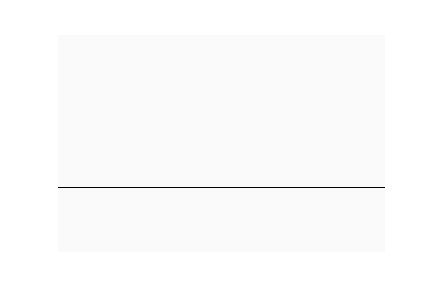
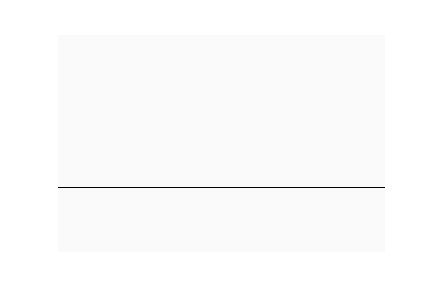
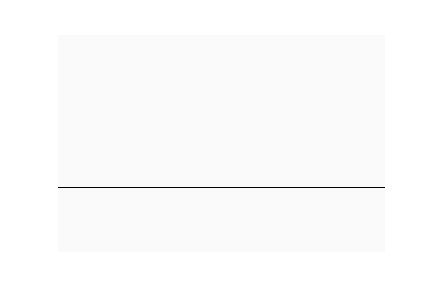
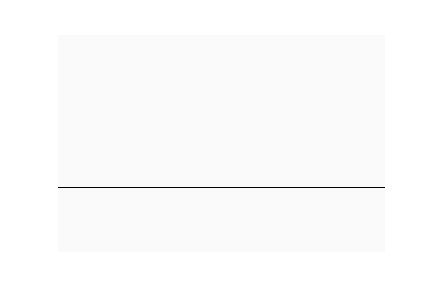
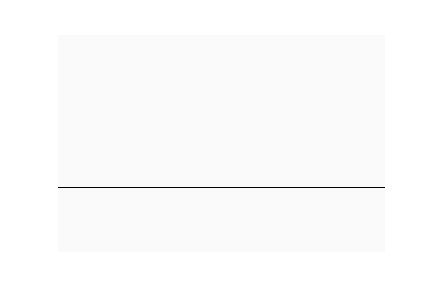
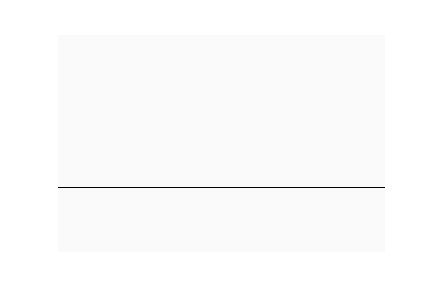
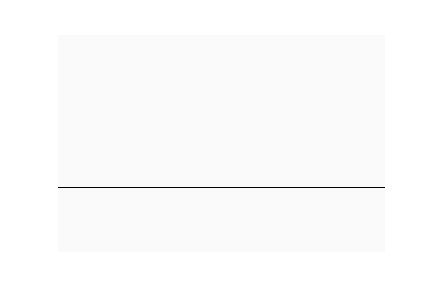
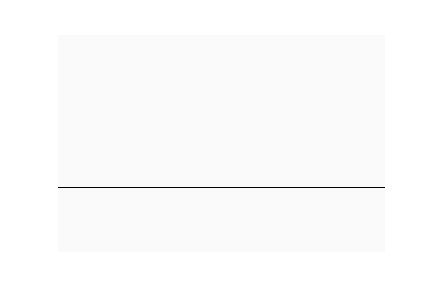
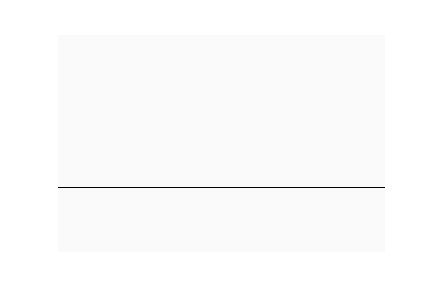
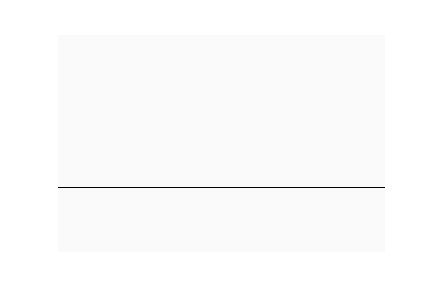
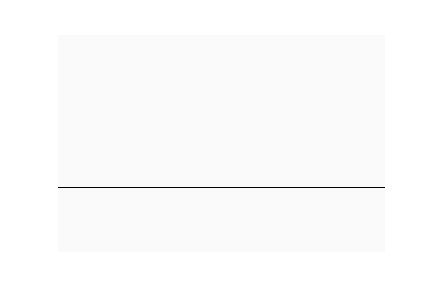
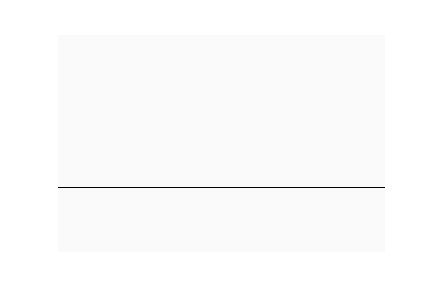
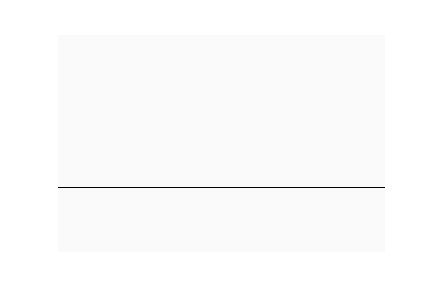
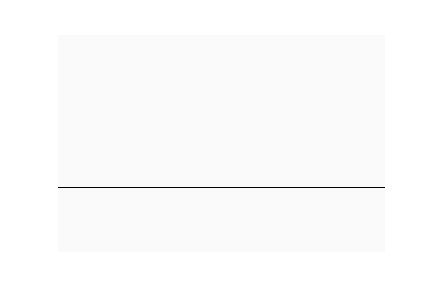
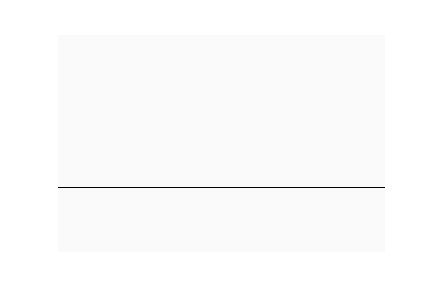
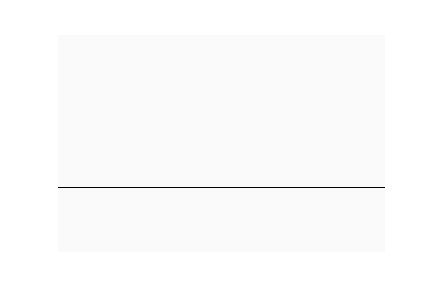
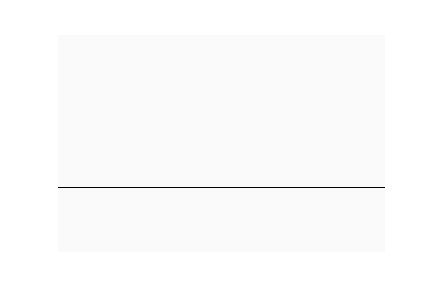
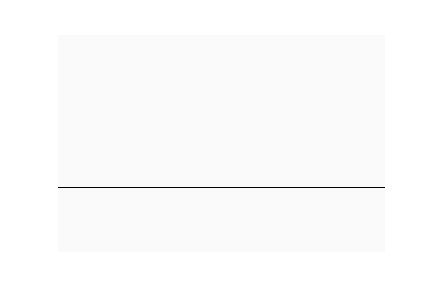
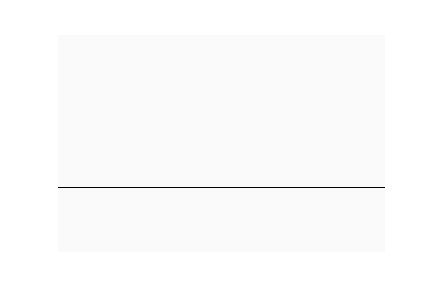
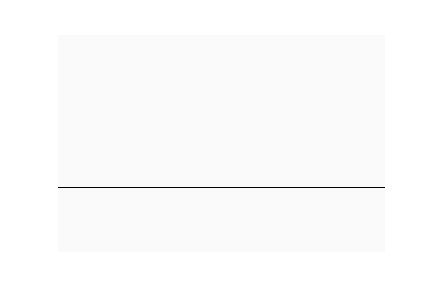
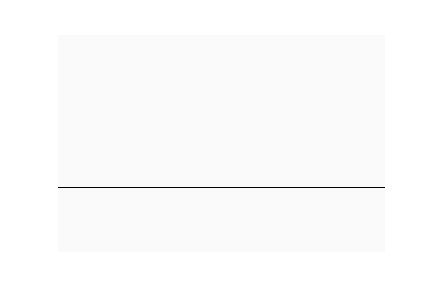
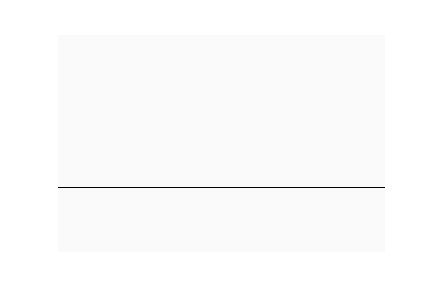
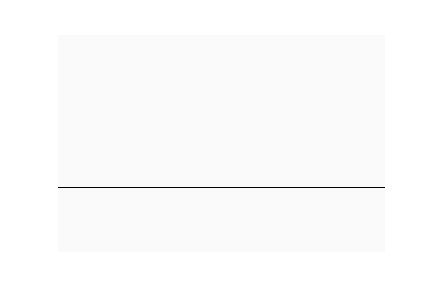
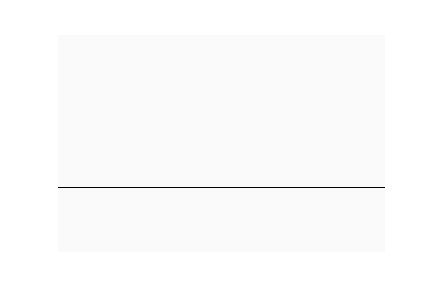
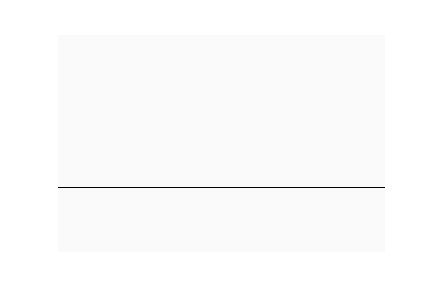
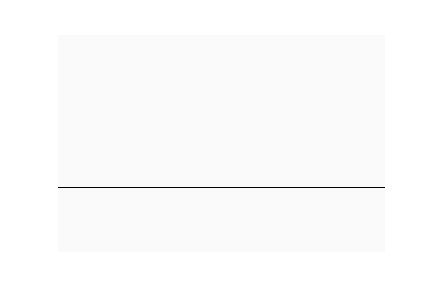
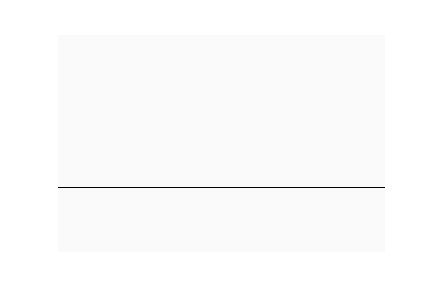
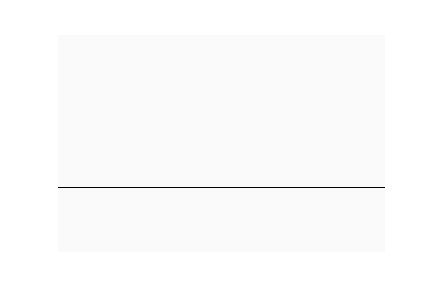
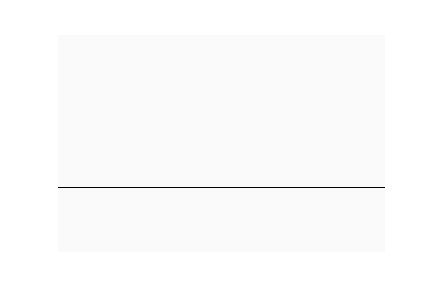
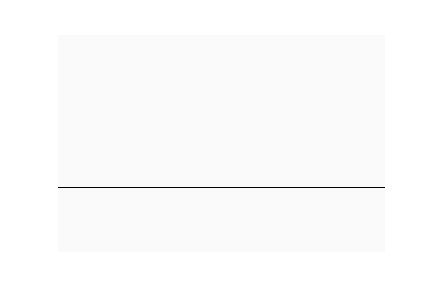
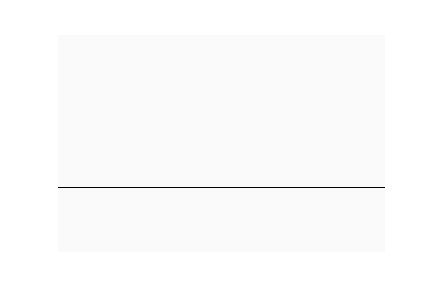
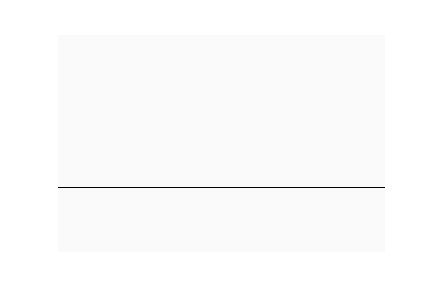
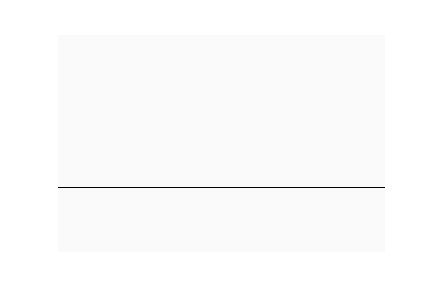
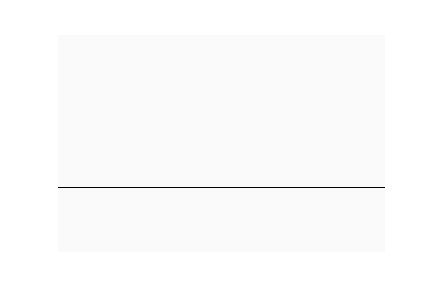
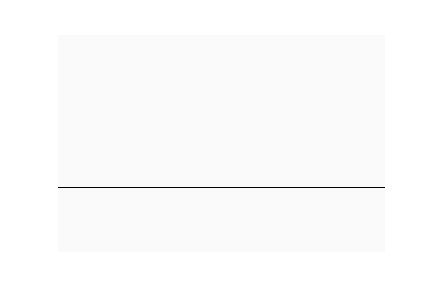
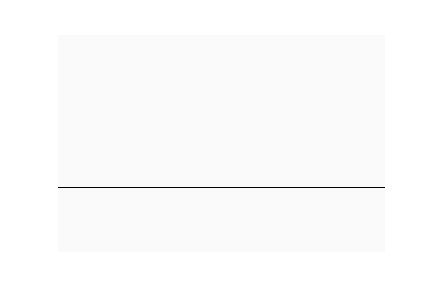
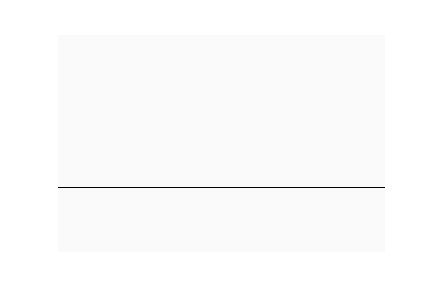
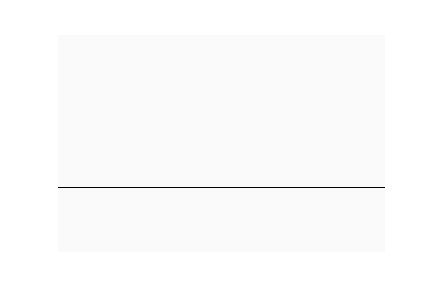
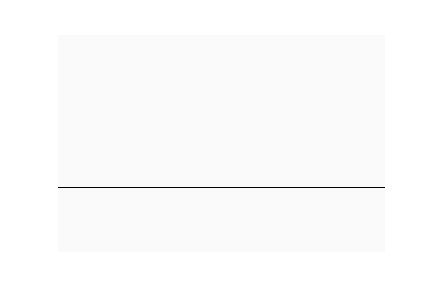
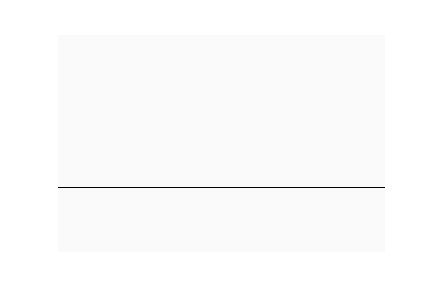
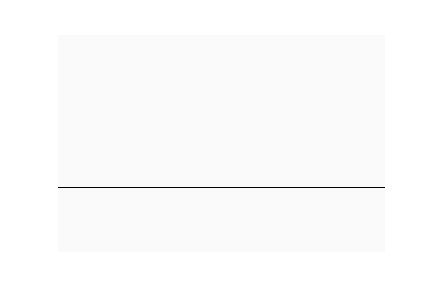
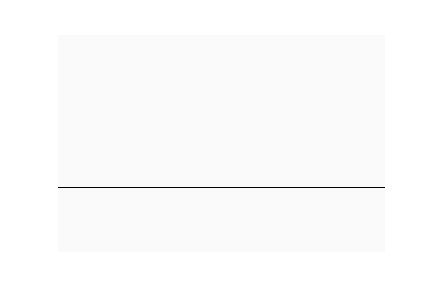
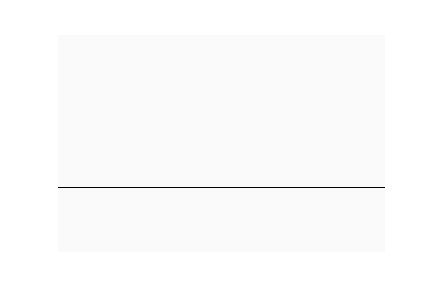
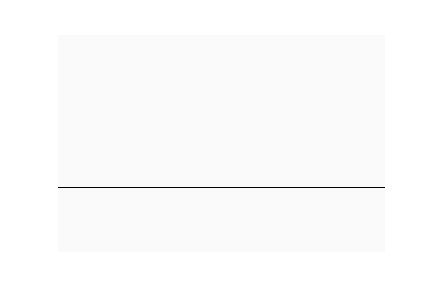
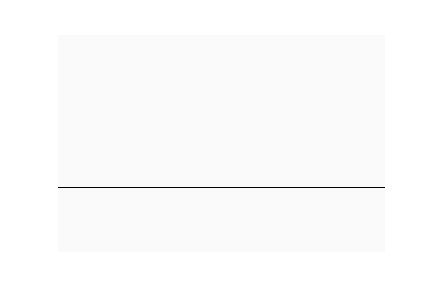
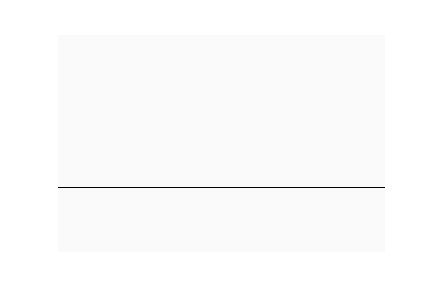
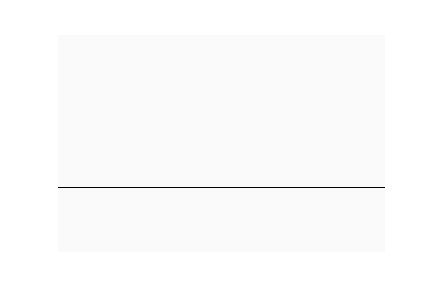
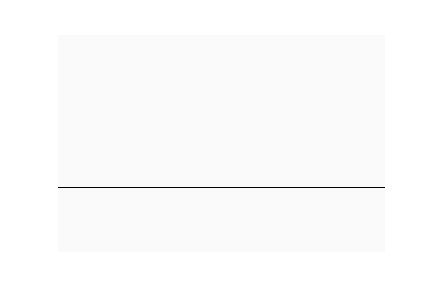
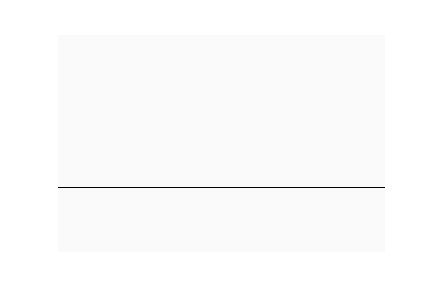
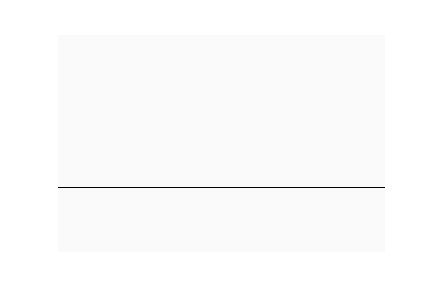
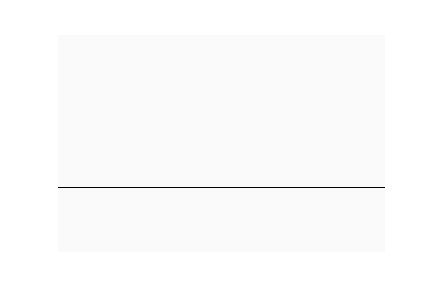
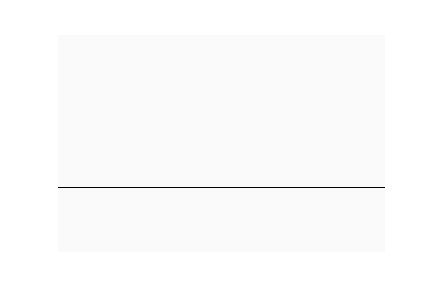
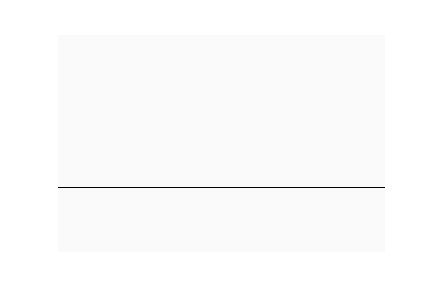
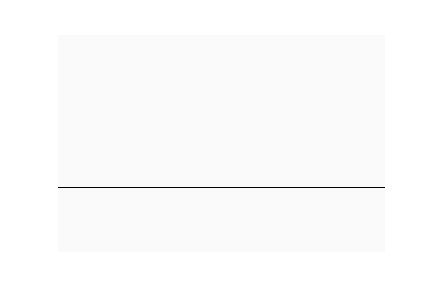
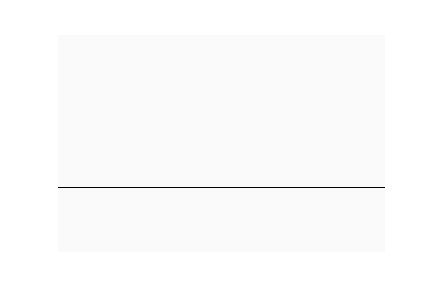
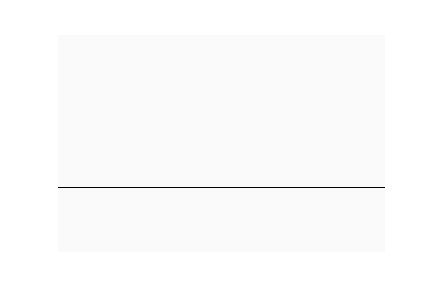
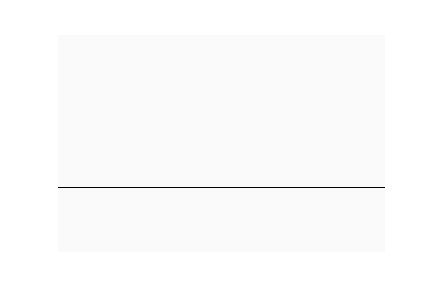
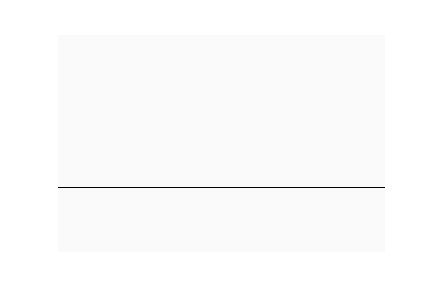
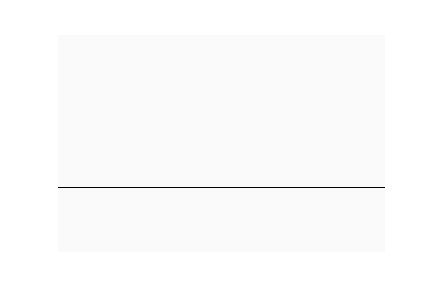
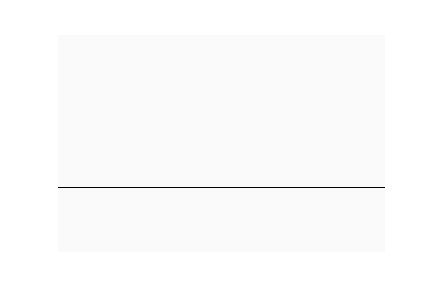
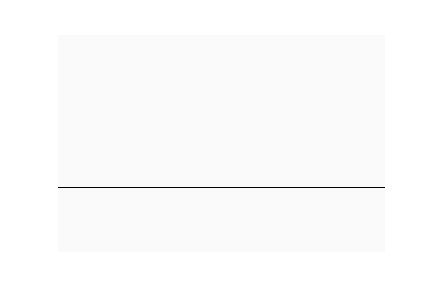
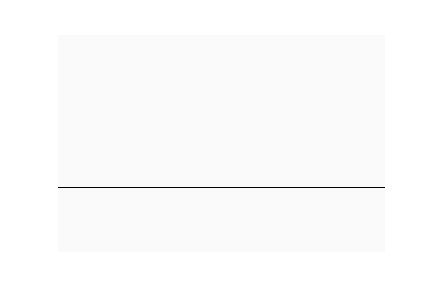
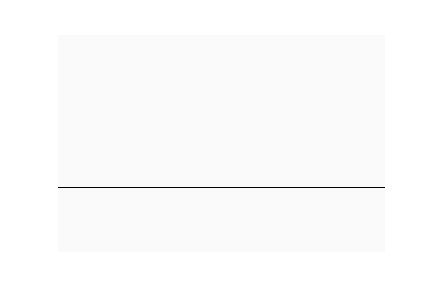
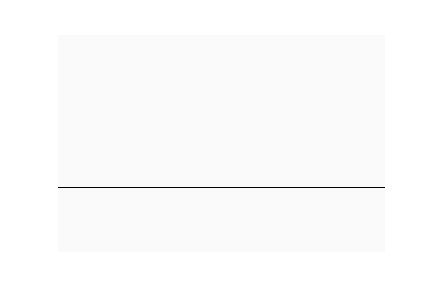
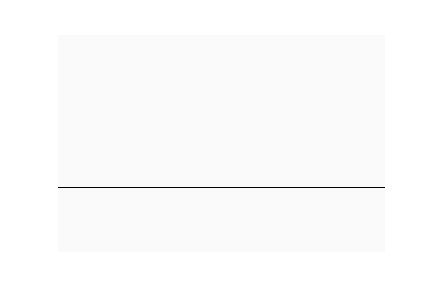
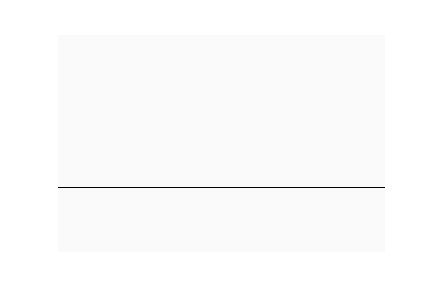
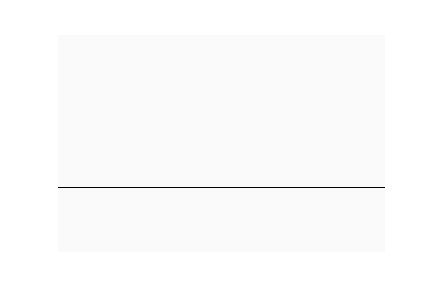
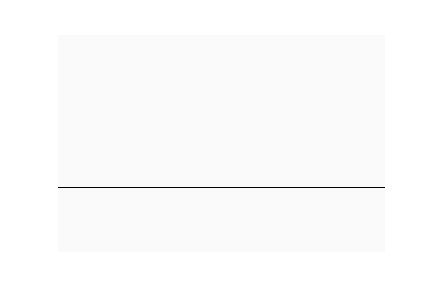
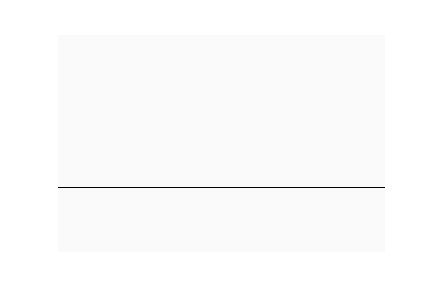
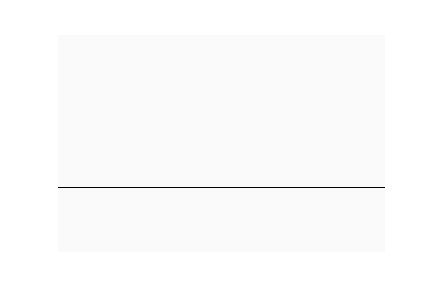
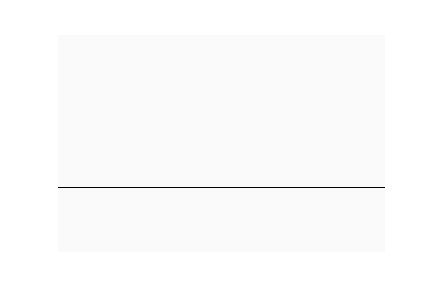
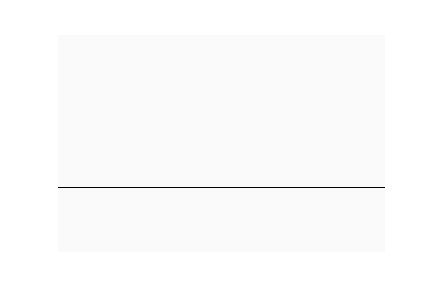
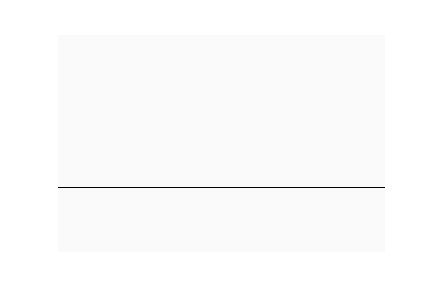
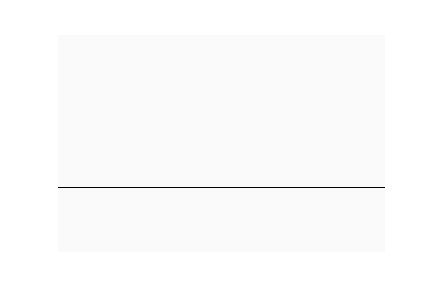
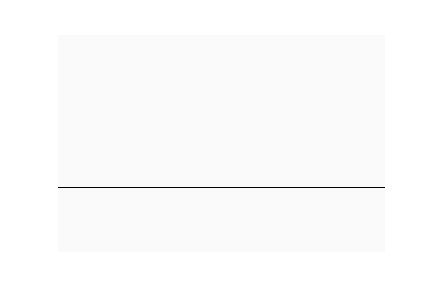
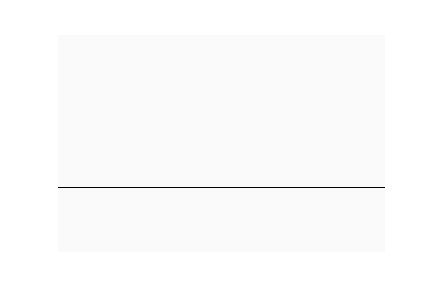
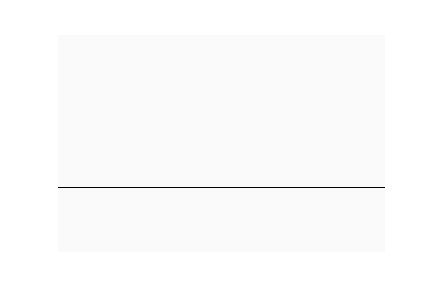
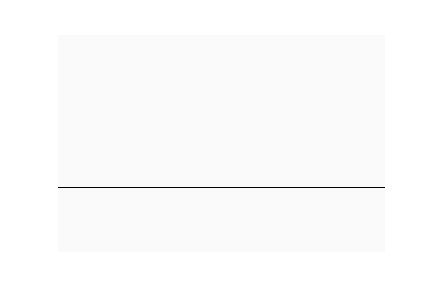
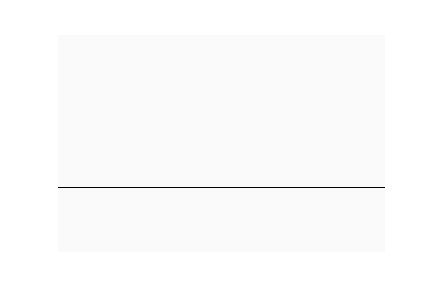
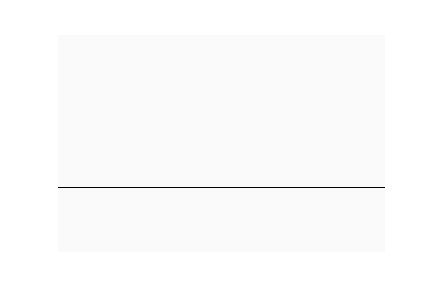
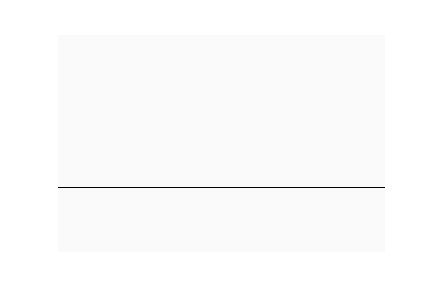
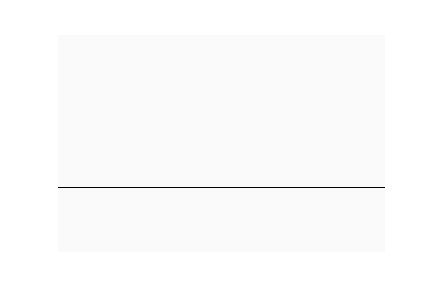
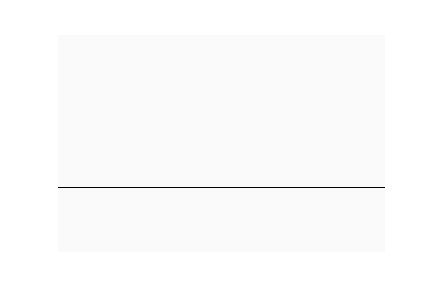
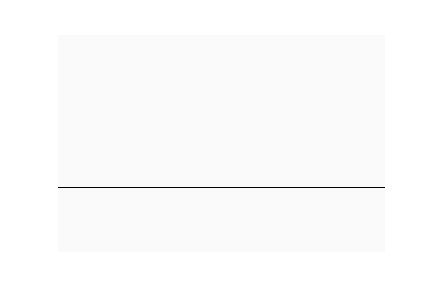
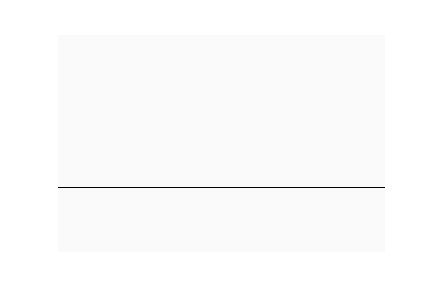
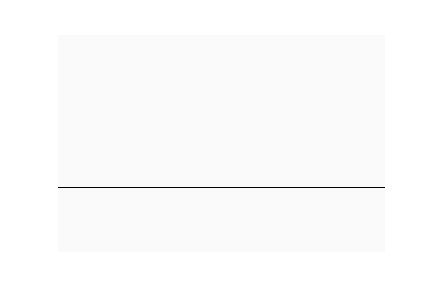
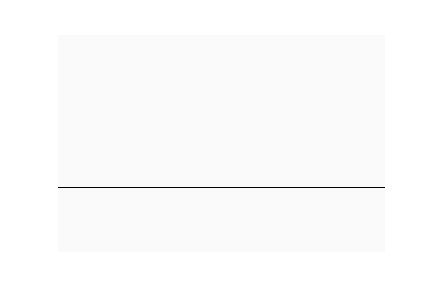
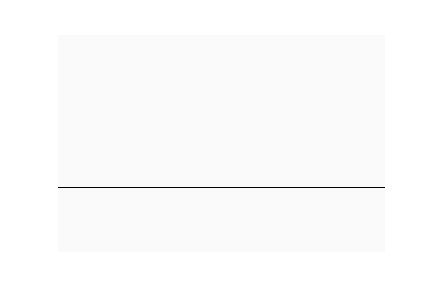
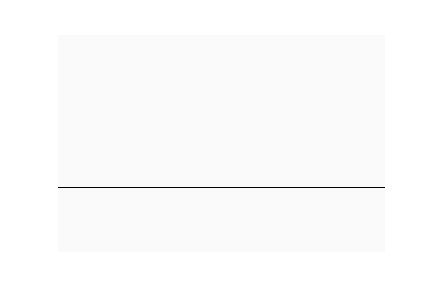
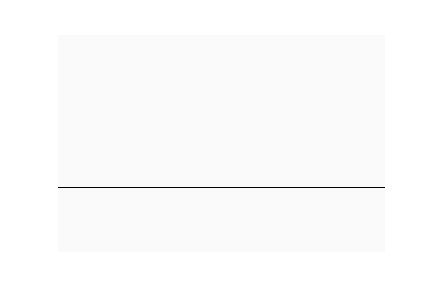
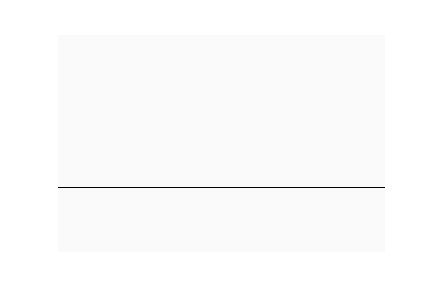
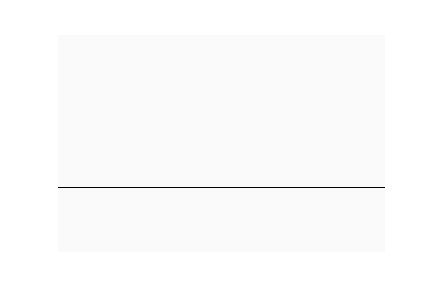
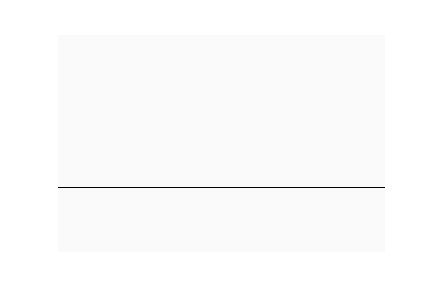
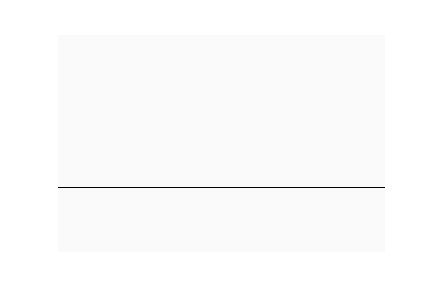
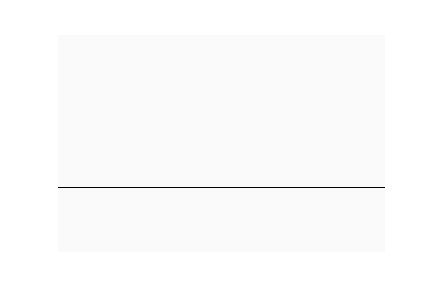
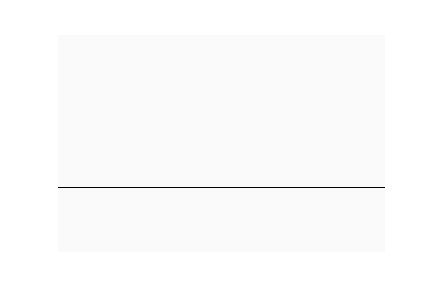
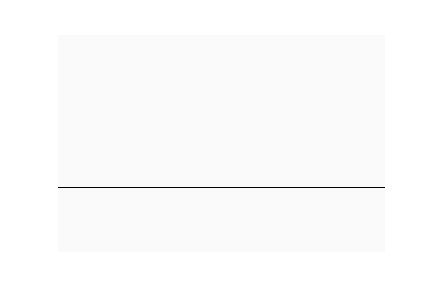
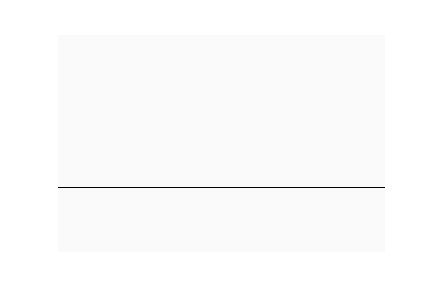
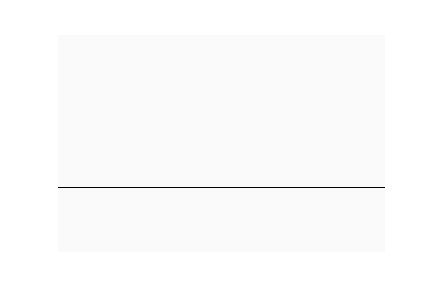
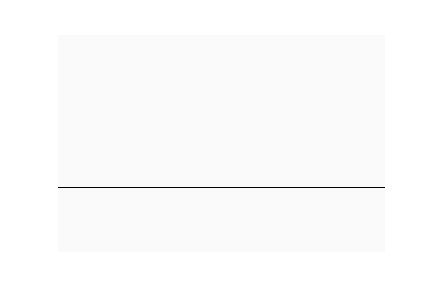
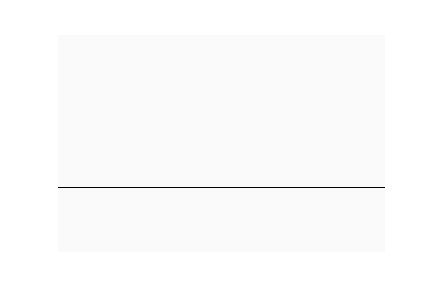
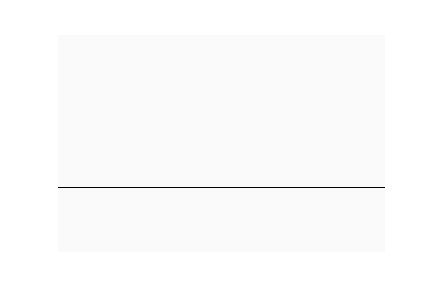
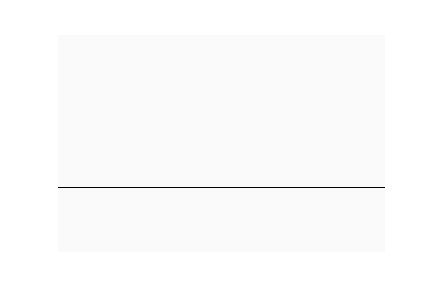
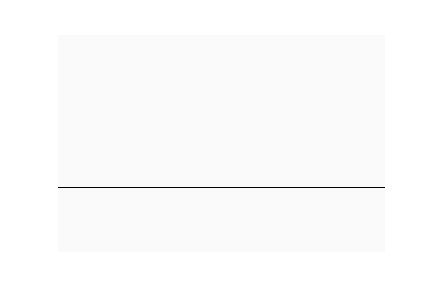
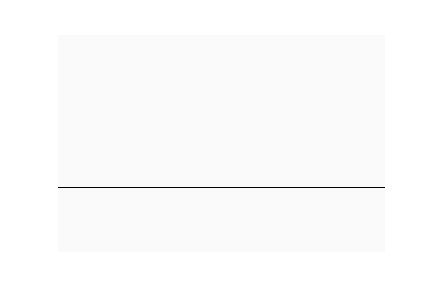
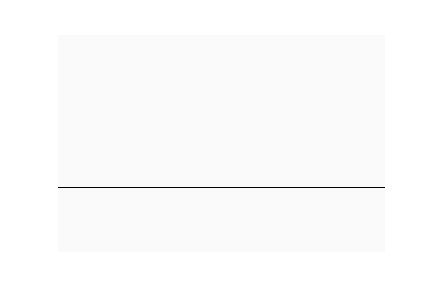
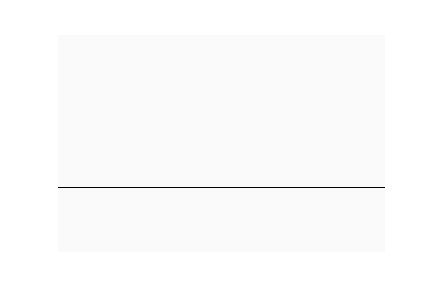
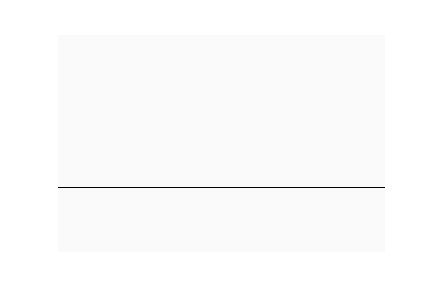
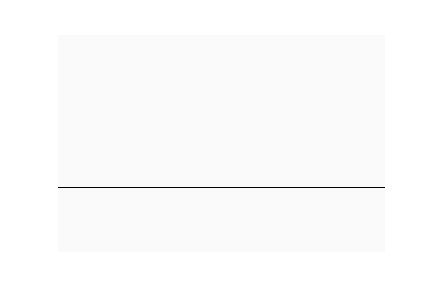
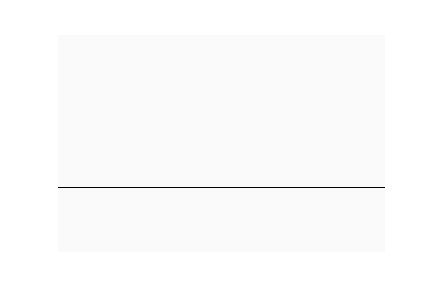
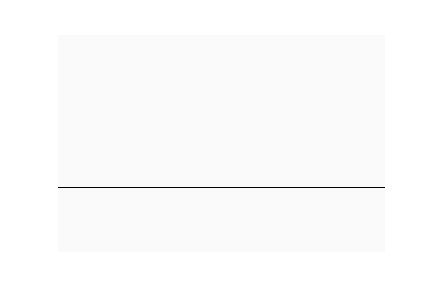
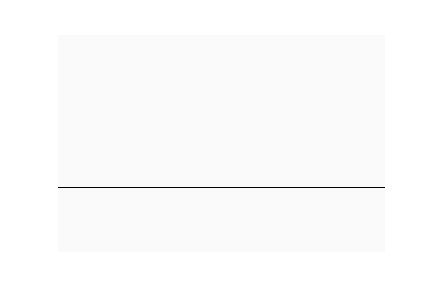
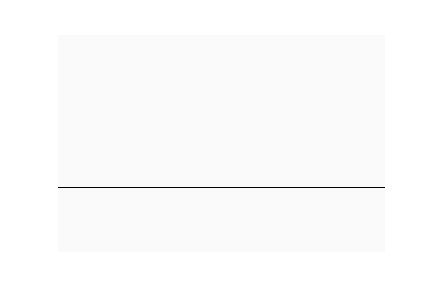
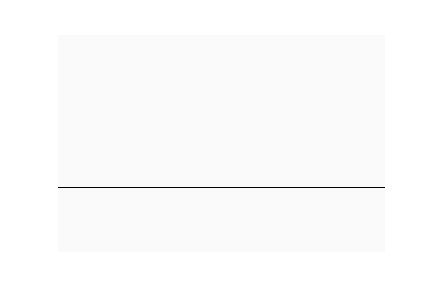
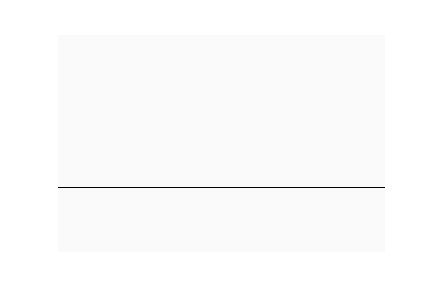
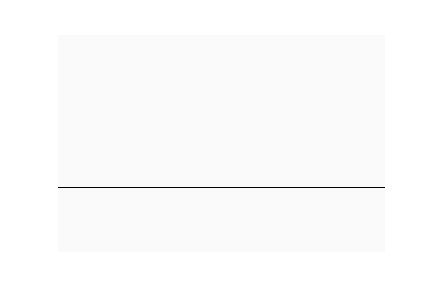

In [74]:
# review solution
with tf.Session() as sess:
    saver.restore(sess, "tmp/model.ckpt")
    s = env.reset()
    view = Viewer(env, custom_render=True)
    for _ in range(500):
        view.render()
        a = get_action(sess, s, stochastic=False)
        s, r, done, _ = env.step(a)
    view.render(close=True, display_gif=True)